# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-besra'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BUILD DATASET & DATALOADERS

In [9]:
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [10]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [15]:
def beta_score(p, y, alpha=0.1, beta=3):
    """Calculates Beta score for a given probability p and label y."""
    
    if y == 1:
        return -betaln(alpha, beta + 1) + betaln(alpha + p, beta + 1 - p)
    elif y == 0:
        return -betaln(alpha + 1, beta) + betaln(alpha + 1 - p, beta + p)
    else:
        raise ValueError("Invalid label: y must be 0 or 1.")

def bayesian_update(prior, likelihood, evidence, alpha=0.1, beta_param=3):
    """ 
    Bayes' Theorem: P(y'|x') = P(x'|y') * P(y') / P(x')
    P(y'|x') or likelihood = model probs
    p(y') or prior = class probabilities
    p(x') or evidence = 1 / number of data
    """
    
    # Using the Beta score to simulate the posterior
    posterior = (likelihood * prior) / evidence
    
    # We calculate the posterior using the Beta distribution
    return posterior

def compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx):
    scores_before = []
    scores_after = []

    # Before data addition: calculate Beta score for predicted prob
    scores_before.append(beta_score(predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    scores_before.append(beta_score(1-predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    
    # After data addition: use Bayesian update (posterior probability)
    for k in range(2):
        prior = predicted_prob
        likelihood = class_probs[class_idx][k]  # Likelihood is the true label (0 or 1)
        posterior = bayesian_update(prior, likelihood, 1)
        scores_after.append(beta_score(posterior, int(1 if posterior >= 0.5 else 0)))

    score_diff_0 = scores_after[0] - scores_before[0]
    score_diff_1 = scores_after[1] - scores_before[1]
    return label_probs['0'] * score_diff_0 + label_probs['1'] * score_diff_1

# Function to compute Expected Score Change (∆Q)
def besra_sampling(models, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    current_train_size = len(train_indices)
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    labeled_dataset = NetifierDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    label_probs = labeled_dataset.get_global_probs()
    class_probs = labeled_dataset.get_per_class_probs()

    for model in models:
        model.to(device)
        model.eval()
    start_time = time.time()
    score_changes = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        model_probs = []

        for model in models:
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.sigmoid(logits)  # Multi-label classification uses sigmoid
                model_probs.append(probs.unsqueeze(0))  # Add batch dimension for averaging
        
        # Stack all model predictions and compute the mean across models
        model_probs = torch.cat(model_probs, dim=0)  # Concatenate predictions across models
        probs = model_probs.mean(dim=0)  # Take the mean along the model axis

        # Calculate Beta scores before and after data addition
        for i in range(len(probs)):
            score_diff = []
            for class_idx in range(probs.shape[1]):
                predicted_prob = probs[i, class_idx].item()
                score_diff.append(compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx))
            
            score_changes.append(np.mean(score_diff))

    # Perform K-means clustering
    collected_indices = set()  # Initialize set to store selected indices
    
    accelerator.wait_for_everyone()
    
    if accelerator.is_local_main_process:
        num_of_candidates = len(score_changes[:math.ceil(0.1 * len(score_changes))])
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break

        # Determine number of clusters
        if num_of_candidates <= n_clusters and n_clusters < nearest_cp - current_train_size:
            n_clusters = n_clusters
        elif num_of_candidates > n_clusters and num_of_candidates < nearest_cp - current_train_size:
            n_clusters = num_of_candidates
        else:
            arrived_at_cp = True
            n_clusters = nearest_cp - current_train_size

        score_changes = np.array(score_changes)
        score_changes = score_changes.reshape(-1, 1)
            
        kmeans=KMeans(n_clusters=n_clusters, n_init=1)
        kmeans.fit(score_changes)

        if current_train_size > checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]  # Indices of samples in the current cluster
                
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances to the cluster center
                cluster_distances = np.linalg.norm(score_changes[cluster_indices] - cluster_center, axis=1)
                closest_sample_index = cluster_indices[np.argmin(cluster_distances)]  # Closest sample index
                collected_indices.add(closest_sample_index)

            end_time = time.time() 
            duration = end_time - start_time 
            
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

# MAIN LOOP

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")

        models = []
        for j in range(3):
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}')
            models.append(model)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (models, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [[50, 67, 42], [81, 90, 11], [14, 7, 33], [3, 44, 85], [94, 21, 5]]

## RUN 1

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.592, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4486, Accuracy: 0.7886, F1 Micro: 0.0174, F1 Macro: 0.0157
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3911, Accuracy: 0.8078, F1 Micro: 0.18, F1 Macro: 0.1337
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.381, Accuracy: 0.8263, F1 Micro: 0.3293, F1 Macro: 0.2231
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3204, Accuracy: 0.8355, F1 Micro: 0.416, F1 Macro: 0.3338
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.281, Accuracy: 0.8527, F1 Micro: 0.5464, F1 Macro: 0.5219
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2621, Accuracy: 0.8564, F1 Micro: 0.5767, F1 Macro: 0.5589
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2083, Accuracy: 0.8581, F1 Micro: 0.5979, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1662, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5474, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4335, Accuracy: 0.7931, F1 Micro: 0.0583, F1 Macro: 0.0499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3767, Accuracy: 0.8175, F1 Micro: 0.2561, F1 Macro: 0.1748
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3582, Accuracy: 0.8288, F1 Micro: 0.3613, F1 Macro: 0.2669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2972, Accuracy: 0.8455, F1 Micro: 0.5013, F1 Macro: 0.467
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2541, Accuracy: 0.855, F1 Micro: 0.5739, F1 Macro: 0.5572
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2294, Accuracy: 0.8559, F1 Micro: 0.582, F1 Macro: 0.5669
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1796, Accuracy: 0.8684, F1 Micro: 0.6509, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1463, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5779, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.456, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4117, Accuracy: 0.7941, F1 Micro: 0.0666, F1 Macro: 0.0564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3928, Accuracy: 0.8244, F1 Micro: 0.3237, F1 Macro: 0.2387
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3221, Accuracy: 0.8383, F1 Micro: 0.4396, F1 Macro: 0.4025
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2818, Accuracy: 0.8533, F1 Micro: 0.5802, F1 Macro: 0.5753
Epoch 7/10, Train Loss: 0.2525, Accuracy: 0.8531, F1 Micro: 0.5528, F1 Macro: 0.53
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1925, Accuracy: 0.8631, F1 Micro: 0.6244, F1 Macro: 0.6175
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1636, Accuracy: 0.8678, F1 Micro: 0.6672, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5729, Accuracy: 0.7919, F1 Micro: 0.0486, F1 Macro: 0.0419
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4673, Accuracy: 0.8453, F1 Micro: 0.4886, F1 Macro: 0.4393
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3886, Accuracy: 0.8614, F1 Micro: 0.6162, F1 Macro: 0.6173
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3268, Accuracy: 0.8702, F1 Micro: 0.6275, F1 Macro: 0.6124
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2812, Accuracy: 0.8733, F1 Micro: 0.6342, F1 Macro: 0.6136
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2197, Accuracy: 0.885, F1 Micro: 0.7208, F1 Macro: 0.7206
Epoch 7/10, Train Loss: 0.1814, Accuracy: 0.8841, F1 Micro: 0.6989, F1 Macro: 0.6911
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1398, Accuracy: 0.8852, F1 Micro: 0.7295, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1148, Accuracy: 0.8852, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5568, Accuracy: 0.7927, F1 Micro: 0.0595, F1 Macro: 0.0498
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4492, Accuracy: 0.8542, F1 Micro: 0.5662, F1 Macro: 0.5489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3721, Accuracy: 0.8647, F1 Micro: 0.6302, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3144, Accuracy: 0.8772, F1 Micro: 0.6534, F1 Macro: 0.6418
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2655, Accuracy: 0.8856, F1 Micro: 0.6864, F1 Macro: 0.6804
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2046, Accuracy: 0.8878, F1 Micro: 0.7198, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1678, Accuracy: 0.8855, F1 Micro: 0.7264, F1 Macro: 0.7239
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1203, Accuracy: 0.8892, F1 Micro: 0.7293, F1 Macro: 0.7265
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5792, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4891, Accuracy: 0.8447, F1 Micro: 0.5637, F1 Macro: 0.5587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3973, Accuracy: 0.8578, F1 Micro: 0.6147, F1 Macro: 0.6212
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3243, Accuracy: 0.8697, F1 Micro: 0.6316, F1 Macro: 0.6248
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2775, Accuracy: 0.8813, F1 Micro: 0.6782, F1 Macro: 0.674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2201, Accuracy: 0.885, F1 Micro: 0.7058, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1778, Accuracy: 0.8852, F1 Micro: 0.7234, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1319, Accuracy: 0.887, F1 Micro: 0.7262, F1 Macro: 0.726
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1073, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.558, Accuracy: 0.8309, F1 Micro: 0.4742, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4338, Accuracy: 0.8647, F1 Micro: 0.6659, F1 Macro: 0.6673
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3611, Accuracy: 0.8842, F1 Micro: 0.7095, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2931, Accuracy: 0.8873, F1 Micro: 0.7185, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2492, Accuracy: 0.8927, F1 Micro: 0.7275, F1 Macro: 0.7196
Epoch 6/10, Train Loss: 0.1951, Accuracy: 0.8878, F1 Micro: 0.7257, F1 Macro: 0.7121
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1425, Accuracy: 0.8933, F1 Micro: 0.741, F1 Macro: 0.7392
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1134, Accuracy: 0.8955, F1 Micro: 0.7488, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0915, Accuracy: 0.8958, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5374, Accuracy: 0.8458, F1 Micro: 0.5544, F1 Macro: 0.4903
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4123, Accuracy: 0.8691, F1 Micro: 0.6762, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3433, Accuracy: 0.8853, F1 Micro: 0.6994, F1 Macro: 0.6864
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2756, Accuracy: 0.8884, F1 Micro: 0.716, F1 Macro: 0.6941
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2342, Accuracy: 0.8941, F1 Micro: 0.7307, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1796, Accuracy: 0.8878, F1 Micro: 0.7412, F1 Macro: 0.7331
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1307, Accuracy: 0.895, F1 Micro: 0.7468, F1 Macro: 0.7446
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.8917, F1 Micro: 0.7417, F1 Macro: 0.7371
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0859, Accuracy: 0.8947, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5657, Accuracy: 0.7966, F1 Micro: 0.3219, F1 Macro: 0.1951
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4417, Accuracy: 0.8639, F1 Micro: 0.6443, F1 Macro: 0.6477
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3562, Accuracy: 0.8823, F1 Micro: 0.7131, F1 Macro: 0.705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2902, Accuracy: 0.8869, F1 Micro: 0.7161, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2538, Accuracy: 0.8894, F1 Micro: 0.7219, F1 Macro: 0.7115
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.197, Accuracy: 0.8856, F1 Micro: 0.753, F1 Macro: 0.75
Epoch 7/10, Train Loss: 0.158, Accuracy: 0.8947, F1 Micro: 0.741, F1 Macro: 0.7369
Epoch 8/10, Train Loss: 0.1288, Accuracy: 0.8977, F1 Micro: 0.7448, F1 Macro: 0.7403
Epoch 9/10, Train Loss: 0.1026, Accuracy: 0.8925, F1 Micro: 0.7378, F1 Macro: 0.7363
Epoch 10/10, Train Loss: 0.0711, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5574, Accuracy: 0.837, F1 Micro: 0.4834, F1 Macro: 0.4266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4238, Accuracy: 0.8745, F1 Micro: 0.6857, F1 Macro: 0.6837
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3414, Accuracy: 0.8861, F1 Micro: 0.7083, F1 Macro: 0.6883
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2828, Accuracy: 0.8938, F1 Micro: 0.7522, F1 Macro: 0.7458
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2252, Accuracy: 0.8959, F1 Micro: 0.7589, F1 Macro: 0.7531
Epoch 6/10, Train Loss: 0.1829, Accuracy: 0.8981, F1 Micro: 0.7461, F1 Macro: 0.7392
Epoch 7/10, Train Loss: 0.1426, Accuracy: 0.8969, F1 Micro: 0.745, F1 Macro: 0.7389
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1069, Accuracy: 0.8983, F1 Micro: 0.7604, F1 Macro: 0.7575
Epoch 9/10, Train Loss: 0.088, Accuracy: 0.8967, F1 Micro: 0.759, F1 Macro: 0.7574
Epoch 10/10, Train Loss: 0.0678, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5427, Accuracy: 0.842, F1 Micro: 0.4953, F1 Macro: 0.4477
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.411, Accuracy: 0.8748, F1 Micro: 0.6848, F1 Macro: 0.68
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3334, Accuracy: 0.8888, F1 Micro: 0.727, F1 Macro: 0.7097
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2736, Accuracy: 0.893, F1 Micro: 0.7524, F1 Macro: 0.747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2177, Accuracy: 0.8945, F1 Micro: 0.7532, F1 Macro: 0.7457
Epoch 6/10, Train Loss: 0.1778, Accuracy: 0.8925, F1 Micro: 0.7352, F1 Macro: 0.7218
Epoch 7/10, Train Loss: 0.1346, Accuracy: 0.8917, F1 Micro: 0.7342, F1 Macro: 0.7226
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.8945, F1 Micro: 0.746, F1 Macro: 0.739
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.8933, F1 Micro: 0.7404, F1 Macro: 0.7313
Epoch 10/10, Train Loss: 0.0608, Accuracy: 0.8922, F1 Micro: 0.735, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5626, Accuracy: 0.837, F1 Micro: 0.5261, F1 Macro: 0.5226
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4197, Accuracy: 0.8808, F1 Micro: 0.7082, F1 Macro: 0.701
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3381, Accuracy: 0.8878, F1 Micro: 0.7155, F1 Macro: 0.6965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2773, Accuracy: 0.8955, F1 Micro: 0.7521, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2264, Accuracy: 0.8927, F1 Micro: 0.7523, F1 Macro: 0.7492
Epoch 6/10, Train Loss: 0.1915, Accuracy: 0.8948, F1 Micro: 0.7276, F1 Macro: 0.7128
Epoch 7/10, Train Loss: 0.1445, Accuracy: 0.8958, F1 Micro: 0.7486, F1 Macro: 0.7439
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.113, Accuracy: 0.8944, F1 Micro: 0.7524, F1 Macro: 0.7467
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0892, Accuracy: 0.8952, F1 Micro: 0.7573, F1 Macro: 0.7555
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5292, Accuracy: 0.8541, F1 Micro: 0.6029, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3887, Accuracy: 0.8781, F1 Micro: 0.737, F1 Macro: 0.7428
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3357, Accuracy: 0.893, F1 Micro: 0.7408, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2655, Accuracy: 0.8975, F1 Micro: 0.75, F1 Macro: 0.7456
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2342, Accuracy: 0.8994, F1 Micro: 0.7702, F1 Macro: 0.7699
Epoch 6/10, Train Loss: 0.1764, Accuracy: 0.902, F1 Micro: 0.7578, F1 Macro: 0.7536
Epoch 7/10, Train Loss: 0.1388, Accuracy: 0.8998, F1 Micro: 0.752, F1 Macro: 0.7442
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.8992, F1 Micro: 0.7583, F1 Macro: 0.7525
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9008, F1 Micro: 0.7639, F1 Macro: 0.7646
Epoch 10/10, Train Loss: 0.0608, Accuracy: 0.9, F1 Micro: 0.7546, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5153, Accuracy: 0.8586, F1 Micro: 0.6215, F1 Macro: 0.6079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3781, Accuracy: 0.8803, F1 Micro: 0.7135, F1 Macro: 0.7125
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.32, Accuracy: 0.8923, F1 Micro: 0.7415, F1 Macro: 0.729
Epoch 4/10, Train Loss: 0.2546, Accuracy: 0.8948, F1 Micro: 0.7366, F1 Macro: 0.7304
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2182, Accuracy: 0.8989, F1 Micro: 0.7589, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1643, Accuracy: 0.9, F1 Micro: 0.7656, F1 Macro: 0.763
Epoch 7/10, Train Loss: 0.1214, Accuracy: 0.8998, F1 Micro: 0.7649, F1 Macro: 0.7614
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9002, F1 Micro: 0.7518, F1 Macro: 0.7398
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9, F1 Micro: 0.7512, F1 Macro: 0.7456
Epoch 10/10, Train Loss: 0.0536, Accuracy: 0.8991, F1 Micro: 0.7459, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5441, Accuracy: 0.8477, F1 Micro: 0.6029, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3957, Accuracy: 0.8755, F1 Micro: 0.7115, F1 Macro: 0.717
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.337, Accuracy: 0.8941, F1 Micro: 0.7466, F1 Macro: 0.7398
Epoch 4/10, Train Loss: 0.2657, Accuracy: 0.8938, F1 Micro: 0.7273, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2264, Accuracy: 0.8984, F1 Micro: 0.7536, F1 Macro: 0.7498
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1698, Accuracy: 0.8991, F1 Micro: 0.76, F1 Macro: 0.7564
Epoch 7/10, Train Loss: 0.1275, Accuracy: 0.8961, F1 Micro: 0.757, F1 Macro: 0.7523
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.8978, F1 Micro: 0.75, F1 Macro: 0.741
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.8963, F1 Micro: 0.7438, F1 Macro: 0.7419
Epoch 10/10, Train Loss: 0.0603, Accuracy: 0.8958, F1 Micro: 0.7552, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5119, Accuracy: 0.86, F1 Micro: 0.6257, F1 Macro: 0.6083
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3659, Accuracy: 0.8894, F1 Micro: 0.7256, F1 Macro: 0.7157
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3078, Accuracy: 0.8991, F1 Micro: 0.7473, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2534, Accuracy: 0.9005, F1 Micro: 0.7581, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1994, Accuracy: 0.8983, F1 Micro: 0.7777, F1 Macro: 0.78
Epoch 6/10, Train Loss: 0.1582, Accuracy: 0.8983, F1 Micro: 0.7511, F1 Macro: 0.7426
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.9002, F1 Micro: 0.7702, F1 Macro: 0.7712
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.9017, F1 Micro: 0.7682, F1 Macro: 0.767
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.9, F1 Micro: 0.7502, F1 Macro: 0.7439
Epoch 10/10, Train Loss: 0.0569, Accuracy: 0.8992, F1 Micro: 0.7645, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4958, Accuracy: 0.8591, F1 Micro: 0.6404, F1 Macro: 0.6342
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3577, Accuracy: 0.8919, F1 Micro: 0.7324, F1 Macro: 0.7253
Epoch 3/10, Train Loss: 0.2984, Accuracy: 0.8945, F1 Micro: 0.7318, F1 Macro: 0.7256
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2457, Accuracy: 0.8992, F1 Micro: 0.7589, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1882, Accuracy: 0.9011, F1 Micro: 0.7712, F1 Macro: 0.7677
Epoch 6/10, Train Loss: 0.1514, Accuracy: 0.898, F1 Micro: 0.7581, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9006, F1 Micro: 0.7724, F1 Macro: 0.7712
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9022, F1 Micro: 0.7614, F1 Macro: 0.7565
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.8977, F1 Micro: 0.7651, F1 Macro: 0.7627
Epoch 10/10, Train Loss: 0.0479, Accuracy: 0.8997, F1 Micro: 0.754, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5242, Accuracy: 0.8622, F1 Micro: 0.6497, F1 Macro: 0.622
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3728, Accuracy: 0.8917, F1 Micro: 0.74, F1 Macro: 0.7388
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3056, Accuracy: 0.8969, F1 Micro: 0.7492, F1 Macro: 0.7478
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2471, Accuracy: 0.8991, F1 Micro: 0.7604, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1964, Accuracy: 0.8916, F1 Micro: 0.7685, F1 Macro: 0.7698
Epoch 6/10, Train Loss: 0.1517, Accuracy: 0.8983, F1 Micro: 0.7577, F1 Macro: 0.7486
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.8984, F1 Micro: 0.7682, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9008, F1 Micro: 0.7703, F1 Macro: 0.7715
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.8978, F1 Micro: 0.7443, F1 Macro: 0.7391
Epoch 10/10, Train Loss: 0.053, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4993, Accuracy: 0.8683, F1 Micro: 0.6774, F1 Macro: 0.6765
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3572, Accuracy: 0.883, F1 Micro: 0.7078, F1 Macro: 0.7083
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2935, Accuracy: 0.8952, F1 Micro: 0.7608, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2376, Accuracy: 0.9005, F1 Micro: 0.7647, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1859, Accuracy: 0.8998, F1 Micro: 0.7667, F1 Macro: 0.7563
Epoch 6/10, Train Loss: 0.1461, Accuracy: 0.903, F1 Micro: 0.7552, F1 Macro: 0.7475
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9022, F1 Micro: 0.7693, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9025, F1 Micro: 0.7744, F1 Macro: 0.7713
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9044, F1 Micro: 0.7666, F1 Macro: 0.7602
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4873, Accuracy: 0.8705, F1 Micro: 0.6637, F1 Macro: 0.6581
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3518, Accuracy: 0.8839, F1 Micro: 0.706, F1 Macro: 0.7079
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2921, Accuracy: 0.8984, F1 Micro: 0.7655, F1 Macro: 0.7599
Epoch 4/10, Train Loss: 0.2358, Accuracy: 0.902, F1 Micro: 0.7569, F1 Macro: 0.7461
Epoch 5/10, Train Loss: 0.1871, Accuracy: 0.9023, F1 Micro: 0.7646, F1 Macro: 0.7552
Epoch 6/10, Train Loss: 0.1367, Accuracy: 0.8991, F1 Micro: 0.7408, F1 Macro: 0.7319
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.8991, F1 Micro: 0.7531, F1 Macro: 0.7433
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.897, F1 Micro: 0.7661, F1 Macro: 0.7636
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.8998, F1 Micro: 0.7573, F1 Macro: 0.7486
Epoch 10/10, Train Loss: 0.0542, Accuracy: 0.9, F1 Micro: 0.763, F1 Macro: 0.7589
Model 2 - Iteration 3122: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5065, Accuracy: 0.8677, F1 Micro: 0.655, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3621, Accuracy: 0.8817, F1 Micro: 0.6992, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2946, Accuracy: 0.8958, F1 Micro: 0.7665, F1 Macro: 0.7667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2331, Accuracy: 0.9034, F1 Micro: 0.7704, F1 Macro: 0.7652
Epoch 5/10, Train Loss: 0.1876, Accuracy: 0.8978, F1 Micro: 0.7488, F1 Macro: 0.7423
Epoch 6/10, Train Loss: 0.142, Accuracy: 0.9, F1 Micro: 0.744, F1 Macro: 0.7369
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.8998, F1 Micro: 0.7675, F1 Macro: 0.7629
Epoch 8/10, Train Loss: 0.083, Accuracy: 0.9011, F1 Micro: 0.7577, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.903, F1 Micro: 0.7734, F1 Macro: 0.7717
Epoch 10/10, Train Loss: 0.0546, Accuracy: 0.9006, F1 Micro: 0.7657, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4849, Accuracy: 0.8617, F1 Micro: 0.6723, F1 Macro: 0.6656
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.347, Accuracy: 0.8941, F1 Micro: 0.748, F1 Macro: 0.7486
Epoch 3/10, Train Loss: 0.2869, Accuracy: 0.8939, F1 Micro: 0.7423, F1 Macro: 0.7278
Epoch 4/10, Train Loss: 0.2416, Accuracy: 0.8998, F1 Micro: 0.7443, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1931, Accuracy: 0.9045, F1 Micro: 0.766, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1493, Accuracy: 0.8998, F1 Micro: 0.7718, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9039, F1 Micro: 0.7764, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.902, F1 Micro: 0.7769, F1 Macro: 0.777
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.8994, F1 Micro: 0.7572, F1 Macro: 0.7518
Epoch 10/10, Train Loss: 0.0547, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4728, Accuracy: 0.8653, F1 Micro: 0.6854, F1 Macro: 0.6873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3369, Accuracy: 0.8955, F1 Micro: 0.7525, F1 Macro: 0.7493
Epoch 3/10, Train Loss: 0.2779, Accuracy: 0.8984, F1 Micro: 0.7513, F1 Macro: 0.7381
Epoch 4/10, Train Loss: 0.2331, Accuracy: 0.8995, F1 Micro: 0.7447, F1 Macro: 0.7384
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1792, Accuracy: 0.9027, F1 Micro: 0.7542, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.142, Accuracy: 0.9017, F1 Micro: 0.7723, F1 Macro: 0.7703
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.8984, F1 Micro: 0.7638, F1 Macro: 0.7586
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.902, F1 Micro: 0.7679, F1 Macro: 0.7633
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9008, F1 Micro: 0.7575, F1 Macro: 0.7537
Epoch 10/10, Train Loss: 0.0465, Accuracy: 0.9027, F1 Micro: 0.7702, F1 Macro: 0.7665
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4929, Accuracy: 0.8586, F1 Micro: 0.676, F1 Macro: 0.6663
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3496, Accuracy: 0.8964, F1 Micro: 0.7531, F1 Macro: 0.7497
Epoch 3/10, Train Loss: 0.2863, Accuracy: 0.8963, F1 Micro: 0.75, F1 Macro: 0.7354
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2451, Accuracy: 0.8994, F1 Micro: 0.7575, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1904, Accuracy: 0.902, F1 Micro: 0.7584, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1464, Accuracy: 0.9023, F1 Micro: 0.7691, F1 Macro: 0.7651
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.8998, F1 Micro: 0.7658, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9022, F1 Micro: 0.7797, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9006, F1 Micro: 0.7712, F1 Macro: 0.7684
Epoch 10/10, Train Loss: 0.0524, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4719, Accuracy: 0.8672, F1 Micro: 0.6432, F1 Macro: 0.6394
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3373, Accuracy: 0.8952, F1 Micro: 0.739, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2746, Accuracy: 0.8978, F1 Micro: 0.7534, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2241, Accuracy: 0.9045, F1 Micro: 0.779, F1 Macro: 0.7741
Epoch 5/10, Train Loss: 0.1809, Accuracy: 0.9025, F1 Micro: 0.7602, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1442, Accuracy: 0.9055, F1 Micro: 0.782, F1 Macro: 0.7798
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9023, F1 Micro: 0.7753, F1 Macro: 0.7714
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.8978, F1 Micro: 0.7735, F1 Macro: 0.7721
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.9067, F1 Micro: 0.7831, F1 Macro: 0.7816
Epoch 10/10, Train Loss: 0.0541, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4578, Accuracy: 0.872, F1 Micro: 0.6614, F1 Macro: 0.6572
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3283, Accuracy: 0.8977, F1 Micro: 0.7555, F1 Macro: 0.7406
Epoch 3/10, Train Loss: 0.2688, Accuracy: 0.9009, F1 Micro: 0.7525, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2154, Accuracy: 0.9053, F1 Micro: 0.7764, F1 Macro: 0.7696
Epoch 5/10, Train Loss: 0.171, Accuracy: 0.9066, F1 Micro: 0.775, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.1331, Accuracy: 0.903, F1 Micro: 0.7675, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9016, F1 Micro: 0.7793, F1 Macro: 0.7763
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.8991, F1 Micro: 0.7757, F1 Macro: 0.7735
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9033, F1 Micro: 0.7684, F1 Macro: 0.7635
Epoch 10/10, Train Loss: 0.0445, Accuracy: 0.9039, F1 Micro: 0.7704, F1 Macro: 0.7656
Model 2 - Iteration 37

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4754, Accuracy: 0.8687, F1 Micro: 0.6571, F1 Macro: 0.6593
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3369, Accuracy: 0.8972, F1 Micro: 0.7563, F1 Macro: 0.7438
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2737, Accuracy: 0.9017, F1 Micro: 0.7671, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2209, Accuracy: 0.9064, F1 Micro: 0.781, F1 Macro: 0.776
Epoch 5/10, Train Loss: 0.1797, Accuracy: 0.9059, F1 Micro: 0.7767, F1 Macro: 0.7697
Epoch 6/10, Train Loss: 0.1424, Accuracy: 0.9031, F1 Micro: 0.7742, F1 Macro: 0.7712
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9027, F1 Micro: 0.7727, F1 Macro: 0.7664
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.8989, F1 Micro: 0.7679, F1 Macro: 0.767
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.9013, F1 Micro: 0.7666, F1 Macro: 0.7628
Epoch 10/10, Train Loss: 0.0482, Accuracy: 0.9031, F1 Micro: 0.7674, F1 Macro: 0.7639
Model 3 - Iteration 37

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4794, Accuracy: 0.8717, F1 Micro: 0.6481, F1 Macro: 0.6168
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3326, Accuracy: 0.8966, F1 Micro: 0.7548, F1 Macro: 0.7493
Epoch 3/10, Train Loss: 0.2808, Accuracy: 0.8989, F1 Micro: 0.7384, F1 Macro: 0.727
Epoch 4/10, Train Loss: 0.229, Accuracy: 0.8994, F1 Micro: 0.7536, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1751, Accuracy: 0.8995, F1 Micro: 0.7724, F1 Macro: 0.7698
Epoch 6/10, Train Loss: 0.1294, Accuracy: 0.9038, F1 Micro: 0.7713, F1 Macro: 0.7665
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9014, F1 Micro: 0.7657, F1 Macro: 0.7608
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9016, F1 Micro: 0.78, F1 Macro: 0.7797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.9009, F1 Micro: 0.7815, F1 Macro: 0.7822
Epoch 10/10, Train Loss: 0.0535, Accuracy: 0.9056, F1 Micro: 0.7766, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4687, Accuracy: 0.8806, F1 Micro: 0.7002, F1 Macro: 0.68
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3277, Accuracy: 0.8991, F1 Micro: 0.7628, F1 Macro: 0.7564
Epoch 3/10, Train Loss: 0.2736, Accuracy: 0.8955, F1 Micro: 0.7266, F1 Macro: 0.7144
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2186, Accuracy: 0.9044, F1 Micro: 0.7735, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1675, Accuracy: 0.9, F1 Micro: 0.7753, F1 Macro: 0.7694
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9047, F1 Micro: 0.7742, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.8991, F1 Micro: 0.7777, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9045, F1 Micro: 0.7819, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.9005, F1 Micro: 0.7761, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0454, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4914, Accuracy: 0.8712, F1 Micro: 0.6581, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3341, Accuracy: 0.8963, F1 Micro: 0.7526, F1 Macro: 0.7487
Epoch 3/10, Train Loss: 0.2791, Accuracy: 0.9003, F1 Micro: 0.7421, F1 Macro: 0.7324
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2295, Accuracy: 0.9028, F1 Micro: 0.7763, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1745, Accuracy: 0.9002, F1 Micro: 0.7808, F1 Macro: 0.7801
Epoch 6/10, Train Loss: 0.1314, Accuracy: 0.9033, F1 Micro: 0.7776, F1 Macro: 0.7741
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.8972, F1 Micro: 0.7747, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9017, F1 Micro: 0.7775, F1 Macro: 0.7769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9025, F1 Micro: 0.7817, F1 Macro: 0.7827
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.9047, F1 Micro: 0.7774, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4637, Accuracy: 0.8659, F1 Micro: 0.6146, F1 Macro: 0.5916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3172, Accuracy: 0.8964, F1 Micro: 0.7631, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2618, Accuracy: 0.9022, F1 Micro: 0.7709, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2181, Accuracy: 0.9077, F1 Micro: 0.7831, F1 Macro: 0.7812
Epoch 5/10, Train Loss: 0.1746, Accuracy: 0.9017, F1 Micro: 0.77, F1 Macro: 0.7686
Epoch 6/10, Train Loss: 0.1312, Accuracy: 0.9017, F1 Micro: 0.7521, F1 Macro: 0.7409
Epoch 7/10, Train Loss: 0.0968, Accuracy: 0.9014, F1 Micro: 0.763, F1 Macro: 0.7616
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9033, F1 Micro: 0.7801, F1 Macro: 0.7774
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9055, F1 Micro: 0.7794, F1 Macro: 0.774
Epoch 10/10, Train Loss: 0.0477, Accuracy: 0.9047, F1 Micro: 0.7767, F1 Macro: 0.77
Model 1 - Iteration 4120

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4537, Accuracy: 0.8677, F1 Micro: 0.6173, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3133, Accuracy: 0.8959, F1 Micro: 0.7665, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2621, Accuracy: 0.8992, F1 Micro: 0.7741, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2134, Accuracy: 0.9061, F1 Micro: 0.7831, F1 Macro: 0.7822
Epoch 5/10, Train Loss: 0.1738, Accuracy: 0.9031, F1 Micro: 0.7778, F1 Macro: 0.7758
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9048, F1 Micro: 0.7755, F1 Macro: 0.7703
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9052, F1 Micro: 0.7689, F1 Macro: 0.7634
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9058, F1 Micro: 0.7777, F1 Macro: 0.7732
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9028, F1 Micro: 0.7691, F1 Macro: 0.7666
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.9058, F1 Micro: 0.7742, F1 Macro: 0.7691
Model 2 - Iterati

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4707, Accuracy: 0.8592, F1 Micro: 0.588, F1 Macro: 0.5587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3182, Accuracy: 0.8928, F1 Micro: 0.7598, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2604, Accuracy: 0.8997, F1 Micro: 0.7664, F1 Macro: 0.7657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2154, Accuracy: 0.9067, F1 Micro: 0.7819, F1 Macro: 0.78
Epoch 5/10, Train Loss: 0.1746, Accuracy: 0.9006, F1 Micro: 0.7677, F1 Macro: 0.766
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9019, F1 Micro: 0.7426, F1 Macro: 0.7297
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.9017, F1 Micro: 0.7693, F1 Macro: 0.7692
Epoch 8/10, Train Loss: 0.072, Accuracy: 0.9031, F1 Micro: 0.7739, F1 Macro: 0.7701
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9025, F1 Micro: 0.7751, F1 Macro: 0.7755
Epoch 10/10, Train Loss: 0.0476, Accuracy: 0.9025, F1 Micro: 0.7773, F1 Macro: 0.7778
Model 3 - Iteration 412

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4535, Accuracy: 0.8839, F1 Micro: 0.7046, F1 Macro: 0.6878
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3146, Accuracy: 0.8955, F1 Micro: 0.7591, F1 Macro: 0.7511
Epoch 3/10, Train Loss: 0.2625, Accuracy: 0.9017, F1 Micro: 0.7521, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2117, Accuracy: 0.9005, F1 Micro: 0.7763, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1711, Accuracy: 0.9059, F1 Micro: 0.7805, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.9044, F1 Micro: 0.7819, F1 Macro: 0.7804
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.9033, F1 Micro: 0.772, F1 Macro: 0.7638
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.9038, F1 Micro: 0.7735, F1 Macro: 0.7689
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.905, F1 Micro: 0.77, F1 Macro: 0.7631
Epoch 10/10, Train Loss: 0.0416, Accuracy: 0.9062, F1 Micro: 0.7791, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4458, Accuracy: 0.878, F1 Micro: 0.6808, F1 Macro: 0.6771
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3077, Accuracy: 0.8984, F1 Micro: 0.7578, F1 Macro: 0.7502
Epoch 3/10, Train Loss: 0.2557, Accuracy: 0.8994, F1 Micro: 0.7463, F1 Macro: 0.737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2098, Accuracy: 0.9036, F1 Micro: 0.7778, F1 Macro: 0.7744
Epoch 5/10, Train Loss: 0.1656, Accuracy: 0.903, F1 Micro: 0.7772, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9028, F1 Micro: 0.7819, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.0952, Accuracy: 0.905, F1 Micro: 0.7771, F1 Macro: 0.77
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9036, F1 Micro: 0.7742, F1 Macro: 0.7687
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.903, F1 Micro: 0.7716, F1 Macro: 0.7673
Epoch 10/10, Train Loss: 0.0399, Accuracy: 0.9031, F1 Micro: 0.766, F1 Macro: 0.7582
Model 2 - Iteration 4330: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4628, Accuracy: 0.8791, F1 Micro: 0.6854, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3142, Accuracy: 0.8983, F1 Micro: 0.7584, F1 Macro: 0.7537
Epoch 3/10, Train Loss: 0.2571, Accuracy: 0.8989, F1 Micro: 0.746, F1 Macro: 0.7333
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2112, Accuracy: 0.9009, F1 Micro: 0.7805, F1 Macro: 0.7791
Epoch 5/10, Train Loss: 0.1684, Accuracy: 0.9038, F1 Micro: 0.7727, F1 Macro: 0.7681
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.902, F1 Micro: 0.779, F1 Macro: 0.7779
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.9002, F1 Micro: 0.7748, F1 Macro: 0.7725
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.9042, F1 Micro: 0.7698, F1 Macro: 0.7608
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9048, F1 Micro: 0.777, F1 Macro: 0.7756
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.9061, F1 Micro: 0.775, F1 Macro: 0.7718
Model 3 - Iteration 4330: Accuracy: 0.9009, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4468, Accuracy: 0.8844, F1 Micro: 0.7191, F1 Macro: 0.7105
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3109, Accuracy: 0.8995, F1 Micro: 0.763, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2523, Accuracy: 0.9072, F1 Micro: 0.7863, F1 Macro: 0.7806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2044, Accuracy: 0.9052, F1 Micro: 0.7878, F1 Macro: 0.7846
Epoch 5/10, Train Loss: 0.1638, Accuracy: 0.9052, F1 Micro: 0.7816, F1 Macro: 0.7781
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9052, F1 Micro: 0.785, F1 Macro: 0.7827
Epoch 7/10, Train Loss: 0.0921, Accuracy: 0.9045, F1 Micro: 0.7776, F1 Macro: 0.7734
Epoch 8/10, Train Loss: 0.0725, Accuracy: 0.9017, F1 Micro: 0.7784, F1 Macro: 0.7719
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9023, F1 Micro: 0.778, F1 Macro: 0.7777
Epoch 10/10, Train Loss: 0.0463, Accuracy: 0.905, F1 Micro: 0.7741, F1 Macro: 0.7726
Model 1 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.43, Accuracy: 0.8813, F1 Micro: 0.7034, F1 Macro: 0.6971
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3048, Accuracy: 0.9, F1 Micro: 0.7557, F1 Macro: 0.7456
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2487, Accuracy: 0.9053, F1 Micro: 0.782, F1 Macro: 0.7765
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1981, Accuracy: 0.9064, F1 Micro: 0.7852, F1 Macro: 0.7806
Epoch 5/10, Train Loss: 0.1629, Accuracy: 0.9045, F1 Micro: 0.7784, F1 Macro: 0.7726
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.9072, F1 Micro: 0.7837, F1 Macro: 0.7802
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.905, F1 Micro: 0.7699, F1 Macro: 0.7593
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9011, F1 Micro: 0.7766, F1 Macro: 0.7704
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9053, F1 Micro: 0.7815, F1 Macro: 0.7786
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.9006, F1 Micro: 0.758, F1 Macro: 0.7485
Model 2 - Iteration 4530:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4519, Accuracy: 0.88, F1 Micro: 0.7219, F1 Macro: 0.716
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3129, Accuracy: 0.9003, F1 Micro: 0.7673, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.254, Accuracy: 0.9045, F1 Micro: 0.7808, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2061, Accuracy: 0.9023, F1 Micro: 0.7834, F1 Macro: 0.7825
Epoch 5/10, Train Loss: 0.1656, Accuracy: 0.903, F1 Micro: 0.7796, F1 Macro: 0.7785
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9033, F1 Micro: 0.7784, F1 Macro: 0.7765
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9025, F1 Micro: 0.7723, F1 Macro: 0.7648
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.8997, F1 Micro: 0.7699, F1 Macro: 0.7606
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9022, F1 Micro: 0.7816, F1 Macro: 0.7803
Epoch 10/10, Train Loss: 0.045, Accuracy: 0.9008, F1 Micro: 0.7566, F1 Macro: 0.751
Model 3 - Iteration 4530:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4407, Accuracy: 0.8628, F1 Micro: 0.5943, F1 Macro: 0.5583
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3035, Accuracy: 0.9019, F1 Micro: 0.7691, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2513, Accuracy: 0.9019, F1 Micro: 0.7768, F1 Macro: 0.771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2106, Accuracy: 0.9062, F1 Micro: 0.7834, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1638, Accuracy: 0.9073, F1 Micro: 0.7865, F1 Macro: 0.7822
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9017, F1 Micro: 0.7617, F1 Macro: 0.7547
Epoch 7/10, Train Loss: 0.0953, Accuracy: 0.9022, F1 Micro: 0.7817, F1 Macro: 0.7794
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.9059, F1 Micro: 0.7787, F1 Macro: 0.7732
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9014, F1 Micro: 0.7757, F1 Macro: 0.7731
Epoch 10/10, Train Loss: 0.0425, Accuracy: 0.9027, F1 Micro: 0.7753, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4271, Accuracy: 0.8666, F1 Micro: 0.6065, F1 Macro: 0.5708
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2945, Accuracy: 0.9036, F1 Micro: 0.7681, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2447, Accuracy: 0.9036, F1 Micro: 0.7752, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2045, Accuracy: 0.9053, F1 Micro: 0.7815, F1 Macro: 0.7754
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.9056, F1 Micro: 0.7745, F1 Macro: 0.7695
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9048, F1 Micro: 0.7682, F1 Macro: 0.7607
Epoch 7/10, Train Loss: 0.0921, Accuracy: 0.8984, F1 Micro: 0.7697, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.905, F1 Micro: 0.7686, F1 Macro: 0.7613
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9011, F1 Micro: 0.7735, F1 Macro: 0.7699
Epoch 10/10, Train Loss: 0.0407, Accuracy: 0.9039, F1 Micro: 0.7704, F1 Macro: 0.7637
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4479, Accuracy: 0.8673, F1 Micro: 0.6314, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3042, Accuracy: 0.8991, F1 Micro: 0.7635, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2503, Accuracy: 0.9011, F1 Micro: 0.7762, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2094, Accuracy: 0.9038, F1 Micro: 0.7817, F1 Macro: 0.7758
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.9041, F1 Micro: 0.7812, F1 Macro: 0.779
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.9003, F1 Micro: 0.7692, F1 Macro: 0.7639
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9022, F1 Micro: 0.7783, F1 Macro: 0.7767
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9023, F1 Micro: 0.7746, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9042, F1 Micro: 0.7821, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0413, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4273, Accuracy: 0.8711, F1 Micro: 0.7314, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3012, Accuracy: 0.9033, F1 Micro: 0.7637, F1 Macro: 0.7564
Epoch 3/10, Train Loss: 0.2415, Accuracy: 0.9009, F1 Micro: 0.7575, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2025, Accuracy: 0.9073, F1 Micro: 0.7788, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9023, F1 Micro: 0.7838, F1 Macro: 0.7802
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.9056, F1 Micro: 0.7714, F1 Macro: 0.7599
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9052, F1 Micro: 0.7827, F1 Macro: 0.7782
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9041, F1 Micro: 0.7761, F1 Macro: 0.7718
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9055, F1 Micro: 0.7801, F1 Macro: 0.7767
Epoch 10/10, Train Loss: 0.0425, Accuracy: 0.9038, F1 Micro: 0.7742, F1 Macro: 0.7692
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4176, Accuracy: 0.8866, F1 Micro: 0.7454, F1 Macro: 0.745
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2925, Accuracy: 0.9048, F1 Micro: 0.762, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2365, Accuracy: 0.9058, F1 Micro: 0.7746, F1 Macro: 0.7726
Epoch 4/10, Train Loss: 0.1994, Accuracy: 0.9047, F1 Micro: 0.7715, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1475, Accuracy: 0.9034, F1 Micro: 0.7844, F1 Macro: 0.779
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.905, F1 Micro: 0.7718, F1 Macro: 0.7584
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.9034, F1 Micro: 0.7759, F1 Macro: 0.7746
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.905, F1 Micro: 0.7758, F1 Macro: 0.7719
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9062, F1 Micro: 0.7783, F1 Macro: 0.7706
Epoch 10/10, Train Loss: 0.0381, Accuracy: 0.9069, F1 Micro: 0.782, F1 Macro: 0.7795
Model 2 - Iteration 486

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4371, Accuracy: 0.8756, F1 Micro: 0.7305, F1 Macro: 0.7355
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3015, Accuracy: 0.9041, F1 Micro: 0.7688, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2397, Accuracy: 0.9048, F1 Micro: 0.7749, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2041, Accuracy: 0.9028, F1 Micro: 0.7758, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9045, F1 Micro: 0.779, F1 Macro: 0.774
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9045, F1 Micro: 0.7678, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9023, F1 Micro: 0.7805, F1 Macro: 0.7802
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9052, F1 Micro: 0.7661, F1 Macro: 0.7589
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.9031, F1 Micro: 0.7765, F1 Macro: 0.7696
Epoch 10/10, Train Loss: 0.0391, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4139, Accuracy: 0.8847, F1 Micro: 0.7146, F1 Macro: 0.711
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2855, Accuracy: 0.9017, F1 Micro: 0.7783, F1 Macro: 0.7718
Epoch 3/10, Train Loss: 0.2424, Accuracy: 0.8975, F1 Micro: 0.7521, F1 Macro: 0.7415
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.897, F1 Micro: 0.7733, F1 Macro: 0.7713
Epoch 5/10, Train Loss: 0.1513, Accuracy: 0.9062, F1 Micro: 0.7743, F1 Macro: 0.7695
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.9045, F1 Micro: 0.7635, F1 Macro: 0.7521
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9045, F1 Micro: 0.7745, F1 Macro: 0.7699
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9055, F1 Micro: 0.7747, F1 Macro: 0.7678
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.8988, F1 Micro: 0.7775, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.9011, F1 Micro: 0.7794, F1 Macro: 0.7751
Model 1 - Iteration 5063: Accuracy: 0.9011, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4011, Accuracy: 0.8886, F1 Micro: 0.7294, F1 Macro: 0.7276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2808, Accuracy: 0.9022, F1 Micro: 0.7808, F1 Macro: 0.7775
Epoch 3/10, Train Loss: 0.2331, Accuracy: 0.9019, F1 Micro: 0.759, F1 Macro: 0.7472
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.9023, F1 Micro: 0.7802, F1 Macro: 0.7803
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9072, F1 Micro: 0.7757, F1 Macro: 0.7714
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9027, F1 Micro: 0.7544, F1 Macro: 0.7426
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9036, F1 Micro: 0.7685, F1 Macro: 0.7608
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9028, F1 Micro: 0.7722, F1 Macro: 0.7641
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9023, F1 Micro: 0.7748, F1 Macro: 0.7696
Epoch 10/10, Train Loss: 0.0379, Accuracy: 0.9003, F1 Micro: 0.7769, F1 Macro: 0.7745
Model 2 - Iteration 5063: Accuracy: 0.9022, F1 Micro: 0.7808, F1 Macro: 0.7775
      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4223, Accuracy: 0.8838, F1 Micro: 0.7169, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2871, Accuracy: 0.8977, F1 Micro: 0.7728, F1 Macro: 0.7688
Epoch 3/10, Train Loss: 0.2384, Accuracy: 0.9005, F1 Micro: 0.7557, F1 Macro: 0.7439
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.8984, F1 Micro: 0.7771, F1 Macro: 0.7792
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9048, F1 Micro: 0.7675, F1 Macro: 0.7547
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.8997, F1 Micro: 0.7422, F1 Macro: 0.7297
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.9011, F1 Micro: 0.7635, F1 Macro: 0.7557
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9028, F1 Micro: 0.7741, F1 Macro: 0.7675
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.9005, F1 Micro: 0.774, F1 Macro: 0.7699
Epoch 10/10, Train Loss: 0.0378, Accuracy: 0.8997, F1 Micro: 0.7758, F1 Macro: 0.7726
Model 3 - Iteration 5063: Accuracy: 0.8984, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4124, Accuracy: 0.8844, F1 Micro: 0.7169, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.8958, F1 Micro: 0.7735, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2278, Accuracy: 0.9061, F1 Micro: 0.7758, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1886, Accuracy: 0.9016, F1 Micro: 0.7788, F1 Macro: 0.7758
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.903, F1 Micro: 0.7842, F1 Macro: 0.7813
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9016, F1 Micro: 0.7732, F1 Macro: 0.7696
Epoch 7/10, Train Loss: 0.0941, Accuracy: 0.9009, F1 Micro: 0.776, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9002, F1 Micro: 0.7788, F1 Macro: 0.7791
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9017, F1 Micro: 0.7656, F1 Macro: 0.7608
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.898, F1 Micro: 0.7637, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3973, Accuracy: 0.888, F1 Micro: 0.7328, F1 Macro: 0.7298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2661, Accuracy: 0.8973, F1 Micro: 0.7732, F1 Macro: 0.7657
Epoch 3/10, Train Loss: 0.2225, Accuracy: 0.9053, F1 Micro: 0.7706, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.9044, F1 Micro: 0.7794, F1 Macro: 0.7739
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9052, F1 Micro: 0.7746, F1 Macro: 0.7626
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9031, F1 Micro: 0.7595, F1 Macro: 0.7537
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9061, F1 Micro: 0.775, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9039, F1 Micro: 0.7821, F1 Macro: 0.7785
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9008, F1 Micro: 0.7722, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.9059, F1 Micro: 0.7862, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4164, Accuracy: 0.8853, F1 Micro: 0.7249, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.273, Accuracy: 0.8988, F1 Micro: 0.7717, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2286, Accuracy: 0.9055, F1 Micro: 0.7762, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.9025, F1 Micro: 0.7793, F1 Macro: 0.7756
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9045, F1 Micro: 0.7746, F1 Macro: 0.7648
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9022, F1 Micro: 0.757, F1 Macro: 0.7439
Epoch 7/10, Train Loss: 0.087, Accuracy: 0.9028, F1 Micro: 0.772, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.9038, F1 Micro: 0.7822, F1 Macro: 0.779
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9009, F1 Micro: 0.7736, F1 Macro: 0.7684
Epoch 10/10, Train Loss: 0.0358, Accuracy: 0.9062, F1 Micro: 0.782, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3904, Accuracy: 0.8875, F1 Micro: 0.726, F1 Macro: 0.7203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2705, Accuracy: 0.9, F1 Micro: 0.764, F1 Macro: 0.7603
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.902, F1 Micro: 0.7493, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9062, F1 Micro: 0.7719, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1376, Accuracy: 0.8998, F1 Micro: 0.7822, F1 Macro: 0.7826
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9009, F1 Micro: 0.7744, F1 Macro: 0.7711
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.902, F1 Micro: 0.7757, F1 Macro: 0.7732
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.8947, F1 Micro: 0.7771, F1 Macro: 0.7776
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9055, F1 Micro: 0.7843, F1 Macro: 0.782
Epoch 10/10, Train Loss: 0.0384, Accuracy: 0.8989, F1 Micro: 0.7745, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3799, Accuracy: 0.8884, F1 Micro: 0.7334, F1 Macro: 0.7294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2666, Accuracy: 0.9005, F1 Micro: 0.7683, F1 Macro: 0.7663
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.9039, F1 Micro: 0.7533, F1 Macro: 0.7406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9047, F1 Micro: 0.7698, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1372, Accuracy: 0.9025, F1 Micro: 0.7818, F1 Macro: 0.7793
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9045, F1 Micro: 0.7764, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9023, F1 Micro: 0.7846, F1 Macro: 0.7818
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9047, F1 Micro: 0.7807, F1 Macro: 0.7765
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.9042, F1 Micro: 0.7772, F1 Macro: 0.7705
Epoch 10/10, Train Loss: 0.0342, Accuracy: 0.9003, F1 Micro: 0.7746, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3979, Accuracy: 0.8867, F1 Micro: 0.7234, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2732, Accuracy: 0.8997, F1 Micro: 0.7612, F1 Macro: 0.7576
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.9013, F1 Micro: 0.7456, F1 Macro: 0.7317
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.9019, F1 Micro: 0.7657, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.8983, F1 Micro: 0.7803, F1 Macro: 0.776
Epoch 6/10, Train Loss: 0.1069, Accuracy: 0.9023, F1 Micro: 0.7716, F1 Macro: 0.7668
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9, F1 Micro: 0.775, F1 Macro: 0.7693
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.9013, F1 Micro: 0.7754, F1 Macro: 0.7701
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9045, F1 Micro: 0.7751, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.907, F1 Micro: 0.7817, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3914, Accuracy: 0.8855, F1 Micro: 0.689, F1 Macro: 0.6784
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.898, F1 Micro: 0.7542, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.216, Accuracy: 0.9013, F1 Micro: 0.7844, F1 Macro: 0.7829
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9072, F1 Micro: 0.7916, F1 Macro: 0.7885
Epoch 5/10, Train Loss: 0.1335, Accuracy: 0.9073, F1 Micro: 0.784, F1 Macro: 0.7773
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9014, F1 Micro: 0.7801, F1 Macro: 0.7778
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9014, F1 Micro: 0.7638, F1 Macro: 0.7524
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9034, F1 Micro: 0.7838, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9038, F1 Micro: 0.7786, F1 Macro: 0.7732
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.9053, F1 Micro: 0.7869, F1 Macro: 0.7858
Model 1 - Iteration 56

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.378, Accuracy: 0.8809, F1 Micro: 0.6809, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.9016, F1 Micro: 0.7677, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.9061, F1 Micro: 0.789, F1 Macro: 0.7864
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9069, F1 Micro: 0.7907, F1 Macro: 0.7884
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9114, F1 Micro: 0.7893, F1 Macro: 0.7818
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9048, F1 Micro: 0.7841, F1 Macro: 0.7806
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9045, F1 Micro: 0.7768, F1 Macro: 0.7657
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9059, F1 Micro: 0.7784, F1 Macro: 0.7726
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9059, F1 Micro: 0.7853, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.903, F1 Micro: 0.7772, F1 Macro: 0.7734
Model 2 - Iteration 56

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3972, Accuracy: 0.883, F1 Micro: 0.6949, F1 Macro: 0.6845
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2596, Accuracy: 0.8988, F1 Micro: 0.7598, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.213, Accuracy: 0.9047, F1 Micro: 0.7837, F1 Macro: 0.7803
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.9023, F1 Micro: 0.7794, F1 Macro: 0.7723
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.908, F1 Micro: 0.7778, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9066, F1 Micro: 0.785, F1 Macro: 0.7804
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9006, F1 Micro: 0.7738, F1 Macro: 0.7666
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.9034, F1 Micro: 0.7725, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9052, F1 Micro: 0.7854, F1 Macro: 0.7841
Epoch 10/10, Train Loss: 0.039, Accuracy: 0.9039, F1 Micro: 0.784, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8923, F1 Micro: 0.7297, F1 Macro: 0.7206
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.8941, F1 Micro: 0.723, F1 Macro: 0.701
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2059, Accuracy: 0.9061, F1 Micro: 0.7639, F1 Macro: 0.7569
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9028, F1 Micro: 0.7524, F1 Macro: 0.7396
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.9019, F1 Micro: 0.7653, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9053, F1 Micro: 0.7747, F1 Macro: 0.7669
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9062, F1 Micro: 0.7865, F1 Macro: 0.7841
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.905, F1 Micro: 0.7845, F1 Macro: 0.7827
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.9027, F1 Micro: 0.7847, F1 Macro: 0.7847
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9008, F1 Micro: 0.767, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.367, Accuracy: 0.8922, F1 Micro: 0.7433, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.8983, F1 Micro: 0.7474, F1 Macro: 0.7319
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2053, Accuracy: 0.9086, F1 Micro: 0.7792, F1 Macro: 0.7738
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9078, F1 Micro: 0.7774, F1 Macro: 0.7681
Epoch 5/10, Train Loss: 0.1229, Accuracy: 0.9048, F1 Micro: 0.7757, F1 Macro: 0.771
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9077, F1 Micro: 0.7812, F1 Macro: 0.7743
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9023, F1 Micro: 0.7786, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9066, F1 Micro: 0.7875, F1 Macro: 0.784
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.902, F1 Micro: 0.7808, F1 Macro: 0.7775
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9052, F1 Micro: 0.7841, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.387, Accuracy: 0.8903, F1 Micro: 0.7256, F1 Macro: 0.7151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2528, Accuracy: 0.8952, F1 Micro: 0.7359, F1 Macro: 0.7201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9061, F1 Micro: 0.7703, F1 Macro: 0.7645
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.8998, F1 Micro: 0.7453, F1 Macro: 0.7346
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9005, F1 Micro: 0.7645, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9059, F1 Micro: 0.7723, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9011, F1 Micro: 0.7709, F1 Macro: 0.7666
Epoch 8/10, Train Loss: 0.0473, Accuracy: 0.9019, F1 Micro: 0.77, F1 Macro: 0.7657
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9023, F1 Micro: 0.7808, F1 Macro: 0.777
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9006, F1 Micro: 0.7765, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3807, Accuracy: 0.8867, F1 Micro: 0.7213, F1 Macro: 0.7029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.246, Accuracy: 0.8995, F1 Micro: 0.7534, F1 Macro: 0.7437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9034, F1 Micro: 0.7718, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9048, F1 Micro: 0.7749, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.903, F1 Micro: 0.7765, F1 Macro: 0.7746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0895, Accuracy: 0.907, F1 Micro: 0.7857, F1 Macro: 0.7826
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9056, F1 Micro: 0.786, F1 Macro: 0.7827
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9052, F1 Micro: 0.7776, F1 Macro: 0.7759
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9058, F1 Micro: 0.7792, F1 Macro: 0.7779
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3648, Accuracy: 0.8856, F1 Micro: 0.7354, F1 Macro: 0.7246
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.9022, F1 Micro: 0.7647, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1946, Accuracy: 0.9091, F1 Micro: 0.7849, F1 Macro: 0.7799
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9038, F1 Micro: 0.7753, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.905, F1 Micro: 0.7879, F1 Macro: 0.7852
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9072, F1 Micro: 0.7832, F1 Macro: 0.7771
Epoch 7/10, Train Loss: 0.0645, Accuracy: 0.9059, F1 Micro: 0.7825, F1 Macro: 0.7771
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9064, F1 Micro: 0.7846, F1 Macro: 0.7796
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9059, F1 Micro: 0.7811, F1 Macro: 0.7758
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9059, F1 Micro: 0.7806, F1 Macro: 0.7746
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3875, Accuracy: 0.8817, F1 Micro: 0.7256, F1 Macro: 0.7123
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2426, Accuracy: 0.9017, F1 Micro: 0.7615, F1 Macro: 0.7503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.907, F1 Micro: 0.7824, F1 Macro: 0.7771
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.9036, F1 Micro: 0.7773, F1 Macro: 0.7694
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.9019, F1 Micro: 0.7813, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.9044, F1 Micro: 0.7836, F1 Macro: 0.7819
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.8977, F1 Micro: 0.7782, F1 Macro: 0.7781
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9034, F1 Micro: 0.785, F1 Macro: 0.7842
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.9058, F1 Micro: 0.7864, F1 Macro: 0.7864
Epoch 10/10, Train Loss: 0.0312, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3636, Accuracy: 0.8845, F1 Micro: 0.6786, F1 Macro: 0.6612
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2368, Accuracy: 0.9002, F1 Micro: 0.7613, F1 Macro: 0.7503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1991, Accuracy: 0.9087, F1 Micro: 0.7917, F1 Macro: 0.7872
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.903, F1 Micro: 0.7736, F1 Macro: 0.7695
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9022, F1 Micro: 0.7678, F1 Macro: 0.7582
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9052, F1 Micro: 0.7724, F1 Macro: 0.7648
Epoch 7/10, Train Loss: 0.064, Accuracy: 0.903, F1 Micro: 0.78, F1 Macro: 0.7797
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.9062, F1 Micro: 0.7832, F1 Macro: 0.7784
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9038, F1 Micro: 0.7715, F1 Macro: 0.7634
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9048, F1 Micro: 0.783, F1 Macro: 0.7804
Model 1 - Iteration 6218: Accuracy: 0.9087, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3479, Accuracy: 0.8877, F1 Micro: 0.7023, F1 Macro: 0.6899
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2314, Accuracy: 0.9019, F1 Micro: 0.7701, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9066, F1 Micro: 0.7854, F1 Macro: 0.7811
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9042, F1 Micro: 0.7765, F1 Macro: 0.772
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9036, F1 Micro: 0.7746, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.0847, Accuracy: 0.9059, F1 Micro: 0.773, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.0598, Accuracy: 0.905, F1 Micro: 0.7811, F1 Macro: 0.778
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9034, F1 Micro: 0.7796, F1 Macro: 0.7729
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9025, F1 Micro: 0.7752, F1 Macro: 0.7708
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.902, F1 Micro: 0.7737, F1 Macro: 0.7711
Model 2 - Iteration 6218: Accuracy: 0.9066, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3686, Accuracy: 0.8881, F1 Micro: 0.7058, F1 Macro: 0.6876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2333, Accuracy: 0.8995, F1 Micro: 0.7644, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9045, F1 Micro: 0.7816, F1 Macro: 0.7789
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.9039, F1 Micro: 0.7793, F1 Macro: 0.7739
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9048, F1 Micro: 0.7754, F1 Macro: 0.7598
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9034, F1 Micro: 0.7767, F1 Macro: 0.7693
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.9003, F1 Micro: 0.7717, F1 Macro: 0.7696
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9014, F1 Micro: 0.771, F1 Macro: 0.7634
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9003, F1 Micro: 0.7758, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9014, F1 Micro: 0.7811, F1 Macro: 0.7804
Model 3 - Iteration 6218: Accuracy: 0.9045, F1 Micr

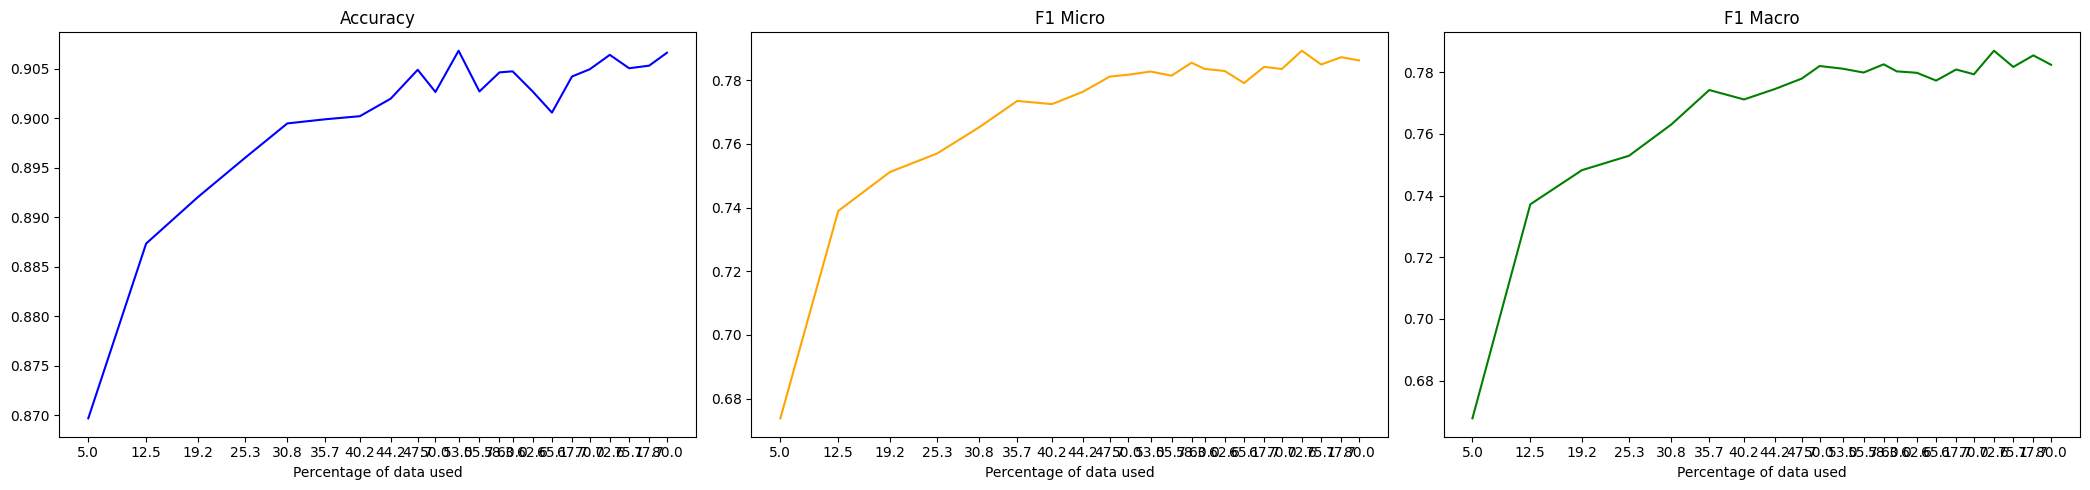

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: [81, 90, 11]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6045, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4429, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3839, Accuracy: 0.8116, F1 Micro: 0.2087, F1 Macro: 0.1506
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3762, Accuracy: 0.8338, F1 Micro: 0.4095, F1 Macro: 0.342
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3143, Accuracy: 0.8447, F1 Micro: 0.4918, F1 Macro: 0.4438
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2621, Accuracy: 0.8547, F1 Micro: 0.565, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2351, Accuracy: 0.8594, F1 Micro: 0.6053, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1834, Accuracy: 0.8698, F1 Micro: 0.6445, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1462, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5934, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.439, Accuracy: 0.7909, F1 Micro: 0.0388, F1 Macro: 0.034
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3734, Accuracy: 0.8158, F1 Micro: 0.2398, F1 Macro: 0.1687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3544, Accuracy: 0.8344, F1 Micro: 0.4137, F1 Macro: 0.3332
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2904, Accuracy: 0.8481, F1 Micro: 0.5272, F1 Macro: 0.4925
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2499, Accuracy: 0.8531, F1 Micro: 0.5595, F1 Macro: 0.547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2281, Accuracy: 0.8608, F1 Micro: 0.607, F1 Macro: 0.5951
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1774, Accuracy: 0.8648, F1 Micro: 0.6211, F1 Macro: 0.6062
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1432, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6052, Accuracy: 0.788, F1 Micro: 0.0117, F1 Macro: 0.0106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4376, Accuracy: 0.7931, F1 Micro: 0.0583, F1 Macro: 0.0499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3737, Accuracy: 0.8203, F1 Micro: 0.274, F1 Macro: 0.1872
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3629, Accuracy: 0.8316, F1 Micro: 0.3896, F1 Macro: 0.2908
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3015, Accuracy: 0.842, F1 Micro: 0.4648, F1 Macro: 0.4003
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2601, Accuracy: 0.8594, F1 Micro: 0.5917, F1 Macro: 0.565
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2378, Accuracy: 0.8631, F1 Micro: 0.6158, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1836, Accuracy: 0.8686, F1 Micro: 0.6453, F1 Macro: 0.6355
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5695, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4711, Accuracy: 0.8388, F1 Micro: 0.4522, F1 Macro: 0.3757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3769, Accuracy: 0.86, F1 Micro: 0.5733, F1 Macro: 0.5361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3032, Accuracy: 0.8739, F1 Micro: 0.6647, F1 Macro: 0.6584
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2593, Accuracy: 0.8873, F1 Micro: 0.7211, F1 Macro: 0.7135
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1989, Accuracy: 0.8906, F1 Micro: 0.7222, F1 Macro: 0.716
Epoch 7/10, Train Loss: 0.1619, Accuracy: 0.8888, F1 Micro: 0.6975, F1 Macro: 0.6793
Epoch 8/10, Train Loss: 0.1331, Accuracy: 0.8913, F1 Micro: 0.7196, F1 Macro: 0.701
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1113, Accuracy: 0.8917, F1 Micro: 0.7405, F1 Macro: 0.732
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5561, Accuracy: 0.7872, F1 Micro: 0.0044, F1 Macro: 0.004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4578, Accuracy: 0.8417, F1 Micro: 0.4738, F1 Macro: 0.4045
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3668, Accuracy: 0.8616, F1 Micro: 0.5921, F1 Macro: 0.5801
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3096, Accuracy: 0.8763, F1 Micro: 0.6675, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.262, Accuracy: 0.8839, F1 Micro: 0.7139, F1 Macro: 0.7134
Epoch 6/10, Train Loss: 0.2003, Accuracy: 0.8844, F1 Micro: 0.7077, F1 Macro: 0.7078
Epoch 7/10, Train Loss: 0.1725, Accuracy: 0.8819, F1 Micro: 0.6772, F1 Macro: 0.6632
Epoch 8/10, Train Loss: 0.1465, Accuracy: 0.8883, F1 Micro: 0.7095, F1 Macro: 0.6961
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1156, Accuracy: 0.8867, F1 Micro: 0.7324, F1 Macro: 0.7226
Epoch 10/10, Train Loss: 0.087, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5591, Accuracy: 0.7955, F1 Micro: 0.0788, F1 Macro: 0.0657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4608, Accuracy: 0.8377, F1 Micro: 0.45, F1 Macro: 0.3568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3732, Accuracy: 0.8644, F1 Micro: 0.6104, F1 Macro: 0.5798
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3122, Accuracy: 0.8795, F1 Micro: 0.6826, F1 Macro: 0.6626
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2644, Accuracy: 0.8884, F1 Micro: 0.7328, F1 Macro: 0.7263
Epoch 6/10, Train Loss: 0.2067, Accuracy: 0.8897, F1 Micro: 0.7071, F1 Macro: 0.6982
Epoch 7/10, Train Loss: 0.1627, Accuracy: 0.8889, F1 Micro: 0.7058, F1 Macro: 0.6949
Epoch 8/10, Train Loss: 0.1314, Accuracy: 0.89, F1 Micro: 0.7115, F1 Macro: 0.6898
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1089, Accuracy: 0.8867, F1 Micro: 0.7484, F1 Macro: 0.7439
Epoch 10/10, Train Loss: 0.0874, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5502, Accuracy: 0.8347, F1 Micro: 0.4602, F1 Macro: 0.4093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4221, Accuracy: 0.8666, F1 Micro: 0.6293, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3474, Accuracy: 0.8792, F1 Micro: 0.6644, F1 Macro: 0.6374
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3024, Accuracy: 0.8847, F1 Micro: 0.676, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.245, Accuracy: 0.8969, F1 Micro: 0.7655, F1 Macro: 0.7641
Epoch 6/10, Train Loss: 0.1816, Accuracy: 0.8994, F1 Micro: 0.7636, F1 Macro: 0.7594
Epoch 7/10, Train Loss: 0.139, Accuracy: 0.8927, F1 Micro: 0.7407, F1 Macro: 0.7332
Epoch 8/10, Train Loss: 0.1142, Accuracy: 0.898, F1 Micro: 0.7516, F1 Macro: 0.7439
Epoch 9/10, Train Loss: 0.0823, Accuracy: 0.8948, F1 Micro: 0.7456, F1 Macro: 0.7421
Epoch 10/10, Train Loss: 0.0721, Accuracy: 0.8936, F1 Micro: 0.7299, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5436, Accuracy: 0.8386, F1 Micro: 0.4812, F1 Macro: 0.4239
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4111, Accuracy: 0.8681, F1 Micro: 0.6321, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.338, Accuracy: 0.8816, F1 Micro: 0.6899, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2957, Accuracy: 0.8884, F1 Micro: 0.7114, F1 Macro: 0.6919
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2413, Accuracy: 0.8953, F1 Micro: 0.7533, F1 Macro: 0.7466
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1772, Accuracy: 0.8972, F1 Micro: 0.7568, F1 Macro: 0.7483
Epoch 7/10, Train Loss: 0.1382, Accuracy: 0.8953, F1 Micro: 0.746, F1 Macro: 0.7374
Epoch 8/10, Train Loss: 0.115, Accuracy: 0.8944, F1 Micro: 0.7317, F1 Macro: 0.7233
Epoch 9/10, Train Loss: 0.0879, Accuracy: 0.8948, F1 Micro: 0.7514, F1 Macro: 0.7488
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5381, Accuracy: 0.853, F1 Micro: 0.5939, F1 Macro: 0.4997
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4128, Accuracy: 0.8686, F1 Micro: 0.621, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3374, Accuracy: 0.8794, F1 Micro: 0.6655, F1 Macro: 0.6384
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2933, Accuracy: 0.8872, F1 Micro: 0.6956, F1 Macro: 0.6699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2393, Accuracy: 0.8961, F1 Micro: 0.7712, F1 Macro: 0.7698
Epoch 6/10, Train Loss: 0.1767, Accuracy: 0.8975, F1 Micro: 0.7565, F1 Macro: 0.75
Epoch 7/10, Train Loss: 0.1356, Accuracy: 0.895, F1 Micro: 0.7464, F1 Macro: 0.7392
Epoch 8/10, Train Loss: 0.1074, Accuracy: 0.8967, F1 Micro: 0.7482, F1 Macro: 0.745
Epoch 9/10, Train Loss: 0.0833, Accuracy: 0.8966, F1 Micro: 0.7543, F1 Macro: 0.7464
Epoch 10/10, Train Loss: 0.0674, Accuracy: 0.8945, F1 Micro: 0.7501, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5469, Accuracy: 0.85, F1 Micro: 0.5707, F1 Macro: 0.5408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4075, Accuracy: 0.8705, F1 Micro: 0.6709, F1 Macro: 0.6619
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3155, Accuracy: 0.8892, F1 Micro: 0.7462, F1 Macro: 0.7407
Epoch 4/10, Train Loss: 0.2619, Accuracy: 0.893, F1 Micro: 0.7422, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2049, Accuracy: 0.8973, F1 Micro: 0.7533, F1 Macro: 0.7466
Epoch 6/10, Train Loss: 0.1599, Accuracy: 0.8958, F1 Micro: 0.7398, F1 Macro: 0.7363
Epoch 7/10, Train Loss: 0.1262, Accuracy: 0.8945, F1 Micro: 0.7461, F1 Macro: 0.7398
Epoch 8/10, Train Loss: 0.0941, Accuracy: 0.8988, F1 Micro: 0.7488, F1 Macro: 0.7364
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.8981, F1 Micro: 0.7591, F1 Macro: 0.7507
Epoch 10/10, Train Loss: 0.0609, Accuracy: 0.8981, F1 Micro: 0.7419, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5386, Accuracy: 0.848, F1 Micro: 0.5875, F1 Macro: 0.5822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3955, Accuracy: 0.8759, F1 Micro: 0.6934, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.313, Accuracy: 0.8861, F1 Micro: 0.7455, F1 Macro: 0.7429
Epoch 4/10, Train Loss: 0.2634, Accuracy: 0.8909, F1 Micro: 0.7413, F1 Macro: 0.7332
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2088, Accuracy: 0.8956, F1 Micro: 0.7645, F1 Macro: 0.7614
Epoch 6/10, Train Loss: 0.1682, Accuracy: 0.8942, F1 Micro: 0.7377, F1 Macro: 0.7295
Epoch 7/10, Train Loss: 0.1255, Accuracy: 0.895, F1 Micro: 0.7383, F1 Macro: 0.7293
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.8923, F1 Micro: 0.7223, F1 Macro: 0.7038
Epoch 9/10, Train Loss: 0.0801, Accuracy: 0.8955, F1 Micro: 0.7473, F1 Macro: 0.7399
Epoch 10/10, Train Loss: 0.0642, Accuracy: 0.8944, F1 Micro: 0.7406, F1 Macro: 0.732
Model 2 - Iteration 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5392, Accuracy: 0.8469, F1 Micro: 0.5765, F1 Macro: 0.5555
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3974, Accuracy: 0.8828, F1 Micro: 0.7176, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3113, Accuracy: 0.8897, F1 Micro: 0.7549, F1 Macro: 0.7566
Epoch 4/10, Train Loss: 0.2613, Accuracy: 0.8969, F1 Micro: 0.7496, F1 Macro: 0.7451
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.209, Accuracy: 0.9023, F1 Micro: 0.7637, F1 Macro: 0.7576
Epoch 6/10, Train Loss: 0.1653, Accuracy: 0.8981, F1 Micro: 0.7622, F1 Macro: 0.7596
Epoch 7/10, Train Loss: 0.1294, Accuracy: 0.8989, F1 Micro: 0.7514, F1 Macro: 0.7465
Epoch 8/10, Train Loss: 0.0934, Accuracy: 0.8977, F1 Micro: 0.7546, F1 Macro: 0.7456
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.8953, F1 Micro: 0.7476, F1 Macro: 0.7423
Epoch 10/10, Train Loss: 0.0554, Accuracy: 0.8981, F1 Micro: 0.7506, F1 Macro: 0.7442
Model 3 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5288, Accuracy: 0.8562, F1 Micro: 0.5564, F1 Macro: 0.494
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3823, Accuracy: 0.8863, F1 Micro: 0.7093, F1 Macro: 0.702
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3051, Accuracy: 0.8931, F1 Micro: 0.7237, F1 Macro: 0.7118
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2377, Accuracy: 0.9006, F1 Micro: 0.7578, F1 Macro: 0.7454
Epoch 5/10, Train Loss: 0.192, Accuracy: 0.8956, F1 Micro: 0.7356, F1 Macro: 0.7281
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1482, Accuracy: 0.903, F1 Micro: 0.7751, F1 Macro: 0.7708
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.898, F1 Micro: 0.7605, F1 Macro: 0.7619
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.9005, F1 Micro: 0.7691, F1 Macro: 0.7645
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.8988, F1 Micro: 0.7713, F1 Macro: 0.7673
Epoch 10/10, Train Loss: 0.0615, Accuracy: 0.9019, F1 Micro: 0.7625, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5218, Accuracy: 0.8525, F1 Micro: 0.5551, F1 Macro: 0.5157
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3777, Accuracy: 0.883, F1 Micro: 0.6966, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3067, Accuracy: 0.8927, F1 Micro: 0.7315, F1 Macro: 0.7268
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2401, Accuracy: 0.8931, F1 Micro: 0.7377, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1964, Accuracy: 0.8963, F1 Micro: 0.7428, F1 Macro: 0.7347
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1478, Accuracy: 0.9052, F1 Micro: 0.7693, F1 Macro: 0.7616
Epoch 7/10, Train Loss: 0.1215, Accuracy: 0.9013, F1 Micro: 0.7678, F1 Macro: 0.767
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.8936, F1 Micro: 0.7644, F1 Macro: 0.7636
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.8948, F1 Micro: 0.7611, F1 Macro: 0.7595
Epoch 10/10, Train Loss: 0.0569, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5246, Accuracy: 0.8527, F1 Micro: 0.5357, F1 Macro: 0.4575
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3817, Accuracy: 0.8844, F1 Micro: 0.6914, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3069, Accuracy: 0.8944, F1 Micro: 0.7315, F1 Macro: 0.7252
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2437, Accuracy: 0.8975, F1 Micro: 0.7423, F1 Macro: 0.7298
Epoch 5/10, Train Loss: 0.2001, Accuracy: 0.8984, F1 Micro: 0.739, F1 Macro: 0.7288
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1555, Accuracy: 0.902, F1 Micro: 0.7699, F1 Macro: 0.766
Epoch 7/10, Train Loss: 0.1226, Accuracy: 0.8992, F1 Micro: 0.7522, F1 Macro: 0.7485
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.8975, F1 Micro: 0.7721, F1 Macro: 0.7698
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.8986, F1 Micro: 0.7646, F1 Macro: 0.7619
Epoch 10/10, Train Loss: 0.0539, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5061, Accuracy: 0.858, F1 Micro: 0.6239, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.366, Accuracy: 0.8927, F1 Micro: 0.7313, F1 Macro: 0.7302
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2987, Accuracy: 0.8948, F1 Micro: 0.7424, F1 Macro: 0.7279
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2435, Accuracy: 0.9009, F1 Micro: 0.76, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1888, Accuracy: 0.9033, F1 Micro: 0.7769, F1 Macro: 0.7701
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.9003, F1 Micro: 0.7692, F1 Macro: 0.7674
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9052, F1 Micro: 0.77, F1 Macro: 0.7628
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.902, F1 Micro: 0.7679, F1 Macro: 0.7612
Epoch 9/10, Train Loss: 0.0635, Accuracy: 0.8995, F1 Micro: 0.7479, F1 Macro: 0.742
Epoch 10/10, Train Loss: 0.0583, Accuracy: 0.8991, F1 Micro: 0.7647, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4941, Accuracy: 0.8559, F1 Micro: 0.6196, F1 Macro: 0.582
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3654, Accuracy: 0.8888, F1 Micro: 0.719, F1 Macro: 0.718
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2989, Accuracy: 0.8955, F1 Micro: 0.7408, F1 Macro: 0.7249
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2502, Accuracy: 0.8984, F1 Micro: 0.7534, F1 Macro: 0.7422
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1921, Accuracy: 0.9022, F1 Micro: 0.771, F1 Macro: 0.7671
Epoch 6/10, Train Loss: 0.1493, Accuracy: 0.8995, F1 Micro: 0.7686, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1172, Accuracy: 0.902, F1 Micro: 0.7719, F1 Macro: 0.7676
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.8981, F1 Micro: 0.7655, F1 Macro: 0.7611
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.8991, F1 Micro: 0.7496, F1 Macro: 0.7376
Epoch 10/10, Train Loss: 0.0561, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4966, Accuracy: 0.8573, F1 Micro: 0.6204, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3699, Accuracy: 0.8903, F1 Micro: 0.7339, F1 Macro: 0.7324
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2978, Accuracy: 0.8977, F1 Micro: 0.7478, F1 Macro: 0.7337
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2484, Accuracy: 0.9008, F1 Micro: 0.7617, F1 Macro: 0.7513
Epoch 5/10, Train Loss: 0.1879, Accuracy: 0.9013, F1 Micro: 0.7597, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1431, Accuracy: 0.9036, F1 Micro: 0.7704, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9027, F1 Micro: 0.772, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.8988, F1 Micro: 0.7705, F1 Macro: 0.7675
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9013, F1 Micro: 0.7608, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.0528, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5023, Accuracy: 0.8702, F1 Micro: 0.676, F1 Macro: 0.6556
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3492, Accuracy: 0.8911, F1 Micro: 0.7522, F1 Macro: 0.7485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2844, Accuracy: 0.8973, F1 Micro: 0.7577, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2318, Accuracy: 0.9041, F1 Micro: 0.7774, F1 Macro: 0.7753
Epoch 5/10, Train Loss: 0.1829, Accuracy: 0.8984, F1 Micro: 0.7504, F1 Macro: 0.7502
Epoch 6/10, Train Loss: 0.1533, Accuracy: 0.8981, F1 Micro: 0.7683, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.8995, F1 Micro: 0.7584, F1 Macro: 0.7539
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9, F1 Micro: 0.7599, F1 Macro: 0.7564
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.9019, F1 Micro: 0.7583, F1 Macro: 0.7528
Epoch 10/10, Train Loss: 0.0496, Accuracy: 0.9016, F1 Micro: 0.7729, F1 Macro: 0.7713
Model 1 - Iteration 31

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4959, Accuracy: 0.8739, F1 Micro: 0.7073, F1 Macro: 0.6936
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3485, Accuracy: 0.8919, F1 Micro: 0.7504, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.283, Accuracy: 0.8955, F1 Micro: 0.7617, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2325, Accuracy: 0.9025, F1 Micro: 0.7763, F1 Macro: 0.7745
Epoch 5/10, Train Loss: 0.1852, Accuracy: 0.9002, F1 Micro: 0.7522, F1 Macro: 0.751
Epoch 6/10, Train Loss: 0.1488, Accuracy: 0.9008, F1 Micro: 0.7597, F1 Macro: 0.7579
Epoch 7/10, Train Loss: 0.1133, Accuracy: 0.8981, F1 Micro: 0.7556, F1 Macro: 0.7528
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.9005, F1 Micro: 0.7633, F1 Macro: 0.7575
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.8972, F1 Micro: 0.7487, F1 Macro: 0.7396
Epoch 10/10, Train Loss: 0.0576, Accuracy: 0.8977, F1 Micro: 0.7657, F1 Macro: 0.7621
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.497, Accuracy: 0.873, F1 Micro: 0.7008, F1 Macro: 0.6718
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3549, Accuracy: 0.8909, F1 Micro: 0.7554, F1 Macro: 0.7524
Epoch 3/10, Train Loss: 0.2882, Accuracy: 0.8936, F1 Micro: 0.7501, F1 Macro: 0.7417
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2391, Accuracy: 0.9011, F1 Micro: 0.7804, F1 Macro: 0.7811
Epoch 5/10, Train Loss: 0.1854, Accuracy: 0.9011, F1 Micro: 0.7612, F1 Macro: 0.761
Epoch 6/10, Train Loss: 0.1555, Accuracy: 0.9009, F1 Micro: 0.7747, F1 Macro: 0.7735
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9002, F1 Micro: 0.7571, F1 Macro: 0.7522
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9023, F1 Micro: 0.7672, F1 Macro: 0.7621
Epoch 9/10, Train Loss: 0.066, Accuracy: 0.9002, F1 Micro: 0.7582, F1 Macro: 0.7475
Epoch 10/10, Train Loss: 0.0502, Accuracy: 0.9013, F1 Micro: 0.7692, F1 Macro: 0.7648
Model 3 - Iteration 3122: Accuracy: 0.9011, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4843, Accuracy: 0.8759, F1 Micro: 0.6879, F1 Macro: 0.6682
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3345, Accuracy: 0.8964, F1 Micro: 0.7523, F1 Macro: 0.743
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2705, Accuracy: 0.9002, F1 Micro: 0.7591, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.214, Accuracy: 0.9017, F1 Micro: 0.7717, F1 Macro: 0.7648
Epoch 5/10, Train Loss: 0.1822, Accuracy: 0.9048, F1 Micro: 0.7594, F1 Macro: 0.7503
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9055, F1 Micro: 0.7707, F1 Macro: 0.7675
Epoch 7/10, Train Loss: 0.1062, Accuracy: 0.9041, F1 Micro: 0.7702, F1 Macro: 0.7644
Epoch 8/10, Train Loss: 0.0859, Accuracy: 0.9038, F1 Micro: 0.7696, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.907, F1 Micro: 0.7723, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0495, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4771, Accuracy: 0.8731, F1 Micro: 0.6694, F1 Macro: 0.6567
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3354, Accuracy: 0.8959, F1 Micro: 0.756, F1 Macro: 0.7484
Epoch 3/10, Train Loss: 0.2718, Accuracy: 0.8991, F1 Micro: 0.7557, F1 Macro: 0.7455
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.219, Accuracy: 0.9055, F1 Micro: 0.7733, F1 Macro: 0.764
Epoch 5/10, Train Loss: 0.1925, Accuracy: 0.9019, F1 Micro: 0.7539, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9047, F1 Micro: 0.7747, F1 Macro: 0.7721
Epoch 7/10, Train Loss: 0.1062, Accuracy: 0.9009, F1 Micro: 0.7655, F1 Macro: 0.7592
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9014, F1 Micro: 0.7684, F1 Macro: 0.763
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.903, F1 Micro: 0.7592, F1 Macro: 0.7461
Epoch 10/10, Train Loss: 0.0557, Accuracy: 0.903, F1 Micro: 0.7709, F1 Macro: 0.7662
Model 2 - Iteration 343

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4829, Accuracy: 0.8803, F1 Micro: 0.6911, F1 Macro: 0.6759
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3376, Accuracy: 0.8969, F1 Micro: 0.7574, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2715, Accuracy: 0.9034, F1 Micro: 0.772, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.22, Accuracy: 0.9044, F1 Micro: 0.7743, F1 Macro: 0.7663
Epoch 5/10, Train Loss: 0.1909, Accuracy: 0.9052, F1 Micro: 0.7621, F1 Macro: 0.749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1357, Accuracy: 0.9062, F1 Micro: 0.7758, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9073, F1 Micro: 0.7877, F1 Macro: 0.7867
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.9064, F1 Micro: 0.7674, F1 Macro: 0.7602
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.9059, F1 Micro: 0.7747, F1 Macro: 0.7679
Epoch 10/10, Train Loss: 0.0517, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4741, Accuracy: 0.8737, F1 Micro: 0.6499, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3269, Accuracy: 0.8981, F1 Micro: 0.7587, F1 Macro: 0.7556
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2723, Accuracy: 0.8916, F1 Micro: 0.7676, F1 Macro: 0.769
Epoch 4/10, Train Loss: 0.2359, Accuracy: 0.9011, F1 Micro: 0.7505, F1 Macro: 0.7427
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.9047, F1 Micro: 0.7647, F1 Macro: 0.753
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9048, F1 Micro: 0.765, F1 Macro: 0.7566
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9045, F1 Micro: 0.7629, F1 Macro: 0.7552
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.902, F1 Micro: 0.7613, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9041, F1 Micro: 0.7709, F1 Macro: 0.7668
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.9027, F1 Micro: 0.7685, F1 Macro: 0.7653
Model 1 - Iteration 371

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4669, Accuracy: 0.8783, F1 Micro: 0.6801, F1 Macro: 0.67
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3276, Accuracy: 0.8978, F1 Micro: 0.7651, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2715, Accuracy: 0.8931, F1 Micro: 0.7714, F1 Macro: 0.7718
Epoch 4/10, Train Loss: 0.2336, Accuracy: 0.9002, F1 Micro: 0.7461, F1 Macro: 0.7388
Epoch 5/10, Train Loss: 0.1818, Accuracy: 0.902, F1 Micro: 0.7461, F1 Macro: 0.7327
Epoch 6/10, Train Loss: 0.1375, Accuracy: 0.9028, F1 Micro: 0.7637, F1 Macro: 0.7582
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.905, F1 Micro: 0.7695, F1 Macro: 0.7629
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9027, F1 Micro: 0.7639, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.8998, F1 Micro: 0.7758, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0517, Accuracy: 0.9023, F1 Micro: 0.7761, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4665, Accuracy: 0.8727, F1 Micro: 0.6574, F1 Macro: 0.6416
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3274, Accuracy: 0.8972, F1 Micro: 0.7588, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2747, Accuracy: 0.8961, F1 Micro: 0.7759, F1 Macro: 0.7767
Epoch 4/10, Train Loss: 0.2356, Accuracy: 0.905, F1 Micro: 0.7645, F1 Macro: 0.7559
Epoch 5/10, Train Loss: 0.1815, Accuracy: 0.9039, F1 Micro: 0.7593, F1 Macro: 0.7432
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1346, Accuracy: 0.9052, F1 Micro: 0.7789, F1 Macro: 0.7734
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.9019, F1 Micro: 0.7639, F1 Macro: 0.7555
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.9034, F1 Micro: 0.7709, F1 Macro: 0.7685
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.902, F1 Micro: 0.7731, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0.9059, F1 Micro: 0.7774, F1 Macro: 0.7752
Model 3 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4706, Accuracy: 0.8737, F1 Micro: 0.6669, F1 Macro: 0.6627
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3353, Accuracy: 0.8975, F1 Micro: 0.7604, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2744, Accuracy: 0.9013, F1 Micro: 0.7764, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2204, Accuracy: 0.9023, F1 Micro: 0.7794, F1 Macro: 0.7739
Epoch 5/10, Train Loss: 0.1716, Accuracy: 0.9014, F1 Micro: 0.7676, F1 Macro: 0.7613
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.8989, F1 Micro: 0.7762, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.905, F1 Micro: 0.7813, F1 Macro: 0.7782
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9031, F1 Micro: 0.7763, F1 Macro: 0.7721
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9022, F1 Micro: 0.7759, F1 Macro: 0.7712
Epoch 10/10, Train Loss: 0.0539, Accuracy: 0.9013, F1 Micro: 0.7687, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.464, Accuracy: 0.8731, F1 Micro: 0.6775, F1 Macro: 0.6792
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3334, Accuracy: 0.8964, F1 Micro: 0.7614, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2724, Accuracy: 0.902, F1 Micro: 0.7784, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.22, Accuracy: 0.9019, F1 Micro: 0.7812, F1 Macro: 0.7776
Epoch 5/10, Train Loss: 0.1691, Accuracy: 0.9009, F1 Micro: 0.7673, F1 Macro: 0.764
Epoch 6/10, Train Loss: 0.1372, Accuracy: 0.9003, F1 Micro: 0.7715, F1 Macro: 0.7617
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.8983, F1 Micro: 0.7644, F1 Macro: 0.7563
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9016, F1 Micro: 0.7701, F1 Macro: 0.7683
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.8986, F1 Micro: 0.7708, F1 Macro: 0.7679
Epoch 10/10, Train Loss: 0.0501, Accuracy: 0.9003, F1 Micro: 0.7717, F1 Macro: 0.7666
Model 2 - Iteration 388

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4619, Accuracy: 0.8778, F1 Micro: 0.6964, F1 Macro: 0.6928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3315, Accuracy: 0.8981, F1 Micro: 0.769, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.272, Accuracy: 0.8995, F1 Micro: 0.7797, F1 Macro: 0.7775
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2183, Accuracy: 0.9006, F1 Micro: 0.7826, F1 Macro: 0.7808
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.9045, F1 Micro: 0.7781, F1 Macro: 0.7743
Epoch 6/10, Train Loss: 0.1354, Accuracy: 0.8991, F1 Micro: 0.7794, F1 Macro: 0.7795
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.9031, F1 Micro: 0.7716, F1 Macro: 0.7684
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9052, F1 Micro: 0.7712, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9038, F1 Micro: 0.7795, F1 Macro: 0.7778
Epoch 10/10, Train Loss: 0.0433, Accuracy: 0.903, F1 Micro: 0.7656, F1 Macro: 0.7602
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4554, Accuracy: 0.8802, F1 Micro: 0.712, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3125, Accuracy: 0.8983, F1 Micro: 0.7474, F1 Macro: 0.7408
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2535, Accuracy: 0.9033, F1 Micro: 0.7753, F1 Macro: 0.7706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2063, Accuracy: 0.903, F1 Micro: 0.7777, F1 Macro: 0.7726
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9033, F1 Micro: 0.7579, F1 Macro: 0.7433
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.9055, F1 Micro: 0.7768, F1 Macro: 0.7709
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9038, F1 Micro: 0.7701, F1 Macro: 0.767
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9036, F1 Micro: 0.7752, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9028, F1 Micro: 0.7801, F1 Macro: 0.7799
Epoch 10/10, Train Loss: 0.0427, Accuracy: 0.9008, F1 Micro: 0.7763, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4497, Accuracy: 0.8766, F1 Micro: 0.7059, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3136, Accuracy: 0.898, F1 Micro: 0.7497, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2583, Accuracy: 0.903, F1 Micro: 0.7831, F1 Macro: 0.7798
Epoch 4/10, Train Loss: 0.2138, Accuracy: 0.9019, F1 Micro: 0.7786, F1 Macro: 0.7705
Epoch 5/10, Train Loss: 0.1707, Accuracy: 0.9034, F1 Micro: 0.7753, F1 Macro: 0.767
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9036, F1 Micro: 0.7765, F1 Macro: 0.7698
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.902, F1 Micro: 0.7766, F1 Macro: 0.7723
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9022, F1 Micro: 0.775, F1 Macro: 0.7711
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9044, F1 Micro: 0.7773, F1 Macro: 0.7742
Epoch 10/10, Train Loss: 0.0463, Accuracy: 0.8973, F1 Micro: 0.7626, F1 Macro: 0.7587
Model 2 - Iteration 4120: Accuracy: 0.903, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4564, Accuracy: 0.8798, F1 Micro: 0.7048, F1 Macro: 0.7048
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3142, Accuracy: 0.8994, F1 Micro: 0.7498, F1 Macro: 0.7438
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.258, Accuracy: 0.903, F1 Micro: 0.7826, F1 Macro: 0.7781
Epoch 4/10, Train Loss: 0.2101, Accuracy: 0.903, F1 Micro: 0.7819, F1 Macro: 0.7782
Epoch 5/10, Train Loss: 0.1708, Accuracy: 0.9027, F1 Micro: 0.7784, F1 Macro: 0.7748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1309, Accuracy: 0.9058, F1 Micro: 0.7827, F1 Macro: 0.7795
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.8984, F1 Micro: 0.7708, F1 Macro: 0.7657
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9039, F1 Micro: 0.7779, F1 Macro: 0.7745
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9044, F1 Micro: 0.7748, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.8977, F1 Micro: 0.7676, F1 Macro: 0.7662
Model 3 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4524, Accuracy: 0.8878, F1 Micro: 0.7325, F1 Macro: 0.7308
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3067, Accuracy: 0.8984, F1 Micro: 0.7496, F1 Macro: 0.7382
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2509, Accuracy: 0.9013, F1 Micro: 0.7819, F1 Macro: 0.7795
Epoch 4/10, Train Loss: 0.2049, Accuracy: 0.9059, F1 Micro: 0.7685, F1 Macro: 0.7605
Epoch 5/10, Train Loss: 0.1622, Accuracy: 0.9023, F1 Micro: 0.774, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9055, F1 Micro: 0.7821, F1 Macro: 0.7806
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9044, F1 Micro: 0.7716, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.9036, F1 Micro: 0.7765, F1 Macro: 0.7731
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9061, F1 Micro: 0.7834, F1 Macro: 0.7834
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.9052, F1 Micro: 0.7698, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4403, Accuracy: 0.8842, F1 Micro: 0.7169, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3056, Accuracy: 0.8988, F1 Micro: 0.7566, F1 Macro: 0.7457
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2554, Accuracy: 0.8998, F1 Micro: 0.7818, F1 Macro: 0.7784
Epoch 4/10, Train Loss: 0.207, Accuracy: 0.9048, F1 Micro: 0.7715, F1 Macro: 0.7638
Epoch 5/10, Train Loss: 0.1644, Accuracy: 0.9008, F1 Micro: 0.7663, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1226, Accuracy: 0.9039, F1 Micro: 0.7838, F1 Macro: 0.786
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9019, F1 Micro: 0.7857, F1 Macro: 0.7848
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9058, F1 Micro: 0.7844, F1 Macro: 0.7829
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9044, F1 Micro: 0.7792, F1 Macro: 0.7777
Epoch 10/10, Train Loss: 0.0452, Accuracy: 0.903, F1 Micro: 0.7729, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4447, Accuracy: 0.8883, F1 Micro: 0.7262, F1 Macro: 0.7165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3053, Accuracy: 0.9005, F1 Micro: 0.7628, F1 Macro: 0.7553
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2546, Accuracy: 0.8992, F1 Micro: 0.778, F1 Macro: 0.7755
Epoch 4/10, Train Loss: 0.2043, Accuracy: 0.9053, F1 Micro: 0.7703, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1632, Accuracy: 0.9044, F1 Micro: 0.7784, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.9038, F1 Micro: 0.7809, F1 Macro: 0.7772
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.907, F1 Micro: 0.7757, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9077, F1 Micro: 0.7855, F1 Macro: 0.7825
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9056, F1 Micro: 0.7823, F1 Macro: 0.7804
Epoch 10/10, Train Loss: 0.0423, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4375, Accuracy: 0.8766, F1 Micro: 0.6815, F1 Macro: 0.6727
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3044, Accuracy: 0.8953, F1 Micro: 0.7765, F1 Macro: 0.7737
Epoch 3/10, Train Loss: 0.253, Accuracy: 0.9023, F1 Micro: 0.7569, F1 Macro: 0.7449
Epoch 4/10, Train Loss: 0.2057, Accuracy: 0.9006, F1 Micro: 0.7525, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1559, Accuracy: 0.9022, F1 Micro: 0.7852, F1 Macro: 0.7842
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9047, F1 Micro: 0.7754, F1 Macro: 0.7701
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9031, F1 Micro: 0.7602, F1 Macro: 0.7493
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9045, F1 Micro: 0.7795, F1 Macro: 0.7759
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.903, F1 Micro: 0.7749, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.041, Accuracy: 0.9034, F1 Micro: 0.7754, F1 Macro: 0.7756
Model 1 - Iteration 4530: Accuracy: 0.9022, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4313, Accuracy: 0.8819, F1 Micro: 0.707, F1 Macro: 0.6968
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3035, Accuracy: 0.8906, F1 Micro: 0.7703, F1 Macro: 0.7685
Epoch 3/10, Train Loss: 0.2521, Accuracy: 0.9027, F1 Micro: 0.7632, F1 Macro: 0.7526
Epoch 4/10, Train Loss: 0.2047, Accuracy: 0.9008, F1 Micro: 0.7652, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1579, Accuracy: 0.9023, F1 Micro: 0.78, F1 Macro: 0.7784
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.9005, F1 Micro: 0.7643, F1 Macro: 0.7619
Epoch 7/10, Train Loss: 0.0962, Accuracy: 0.9031, F1 Micro: 0.7567, F1 Macro: 0.7472
Epoch 8/10, Train Loss: 0.072, Accuracy: 0.9025, F1 Micro: 0.7741, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9038, F1 Micro: 0.7845, F1 Macro: 0.7843
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.9034, F1 Micro: 0.7723, F1 Macro: 0.7685
Model 2 - Iteration 45

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4335, Accuracy: 0.8825, F1 Micro: 0.7211, F1 Macro: 0.7093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3017, Accuracy: 0.8948, F1 Micro: 0.7778, F1 Macro: 0.7766
Epoch 3/10, Train Loss: 0.2486, Accuracy: 0.9048, F1 Micro: 0.7696, F1 Macro: 0.7585
Epoch 4/10, Train Loss: 0.2056, Accuracy: 0.9033, F1 Micro: 0.7602, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1575, Accuracy: 0.9069, F1 Micro: 0.7904, F1 Macro: 0.7889
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.905, F1 Micro: 0.7833, F1 Macro: 0.7831
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.905, F1 Micro: 0.7797, F1 Macro: 0.7744
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9014, F1 Micro: 0.7684, F1 Macro: 0.7599
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9038, F1 Micro: 0.7817, F1 Macro: 0.7808
Epoch 10/10, Train Loss: 0.0405, Accuracy: 0.9044, F1 Micro: 0.7786, F1 Macro: 0.7756
Model 3 - Iteration 4530: Accuracy: 0.9069, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4309, Accuracy: 0.8797, F1 Micro: 0.6973, F1 Macro: 0.6906
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2937, Accuracy: 0.9008, F1 Micro: 0.7614, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2502, Accuracy: 0.9002, F1 Micro: 0.7741, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2026, Accuracy: 0.9048, F1 Micro: 0.7847, F1 Macro: 0.7838
Epoch 5/10, Train Loss: 0.1506, Accuracy: 0.9016, F1 Micro: 0.7783, F1 Macro: 0.7738
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.8998, F1 Micro: 0.7756, F1 Macro: 0.7749
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9034, F1 Micro: 0.7779, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9067, F1 Micro: 0.7798, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9025, F1 Micro: 0.7658, F1 Macro: 0.7557
Epoch 10/10, Train Loss: 0.037, Accuracy: 0.9055, F1 Micro: 0.7793, F1 Macro: 0.7745
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4286, Accuracy: 0.8791, F1 Micro: 0.7028, F1 Macro: 0.6993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2936, Accuracy: 0.8989, F1 Micro: 0.7537, F1 Macro: 0.7472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2488, Accuracy: 0.8953, F1 Micro: 0.771, F1 Macro: 0.7725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2039, Accuracy: 0.9067, F1 Micro: 0.7858, F1 Macro: 0.7828
Epoch 5/10, Train Loss: 0.1578, Accuracy: 0.8997, F1 Micro: 0.7819, F1 Macro: 0.7805
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9047, F1 Micro: 0.7898, F1 Macro: 0.7885
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.9075, F1 Micro: 0.7871, F1 Macro: 0.7853
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9016, F1 Micro: 0.7726, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9048, F1 Micro: 0.772, F1 Macro: 0.7627
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.9023, F1 Micro: 0.7784, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4291, Accuracy: 0.8795, F1 Micro: 0.6973, F1 Macro: 0.6897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2956, Accuracy: 0.8983, F1 Micro: 0.7512, F1 Macro: 0.7442
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2502, Accuracy: 0.9, F1 Micro: 0.7792, F1 Macro: 0.7798
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2042, Accuracy: 0.907, F1 Micro: 0.7854, F1 Macro: 0.7844
Epoch 5/10, Train Loss: 0.1587, Accuracy: 0.8967, F1 Micro: 0.7812, F1 Macro: 0.7832
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9061, F1 Micro: 0.7898, F1 Macro: 0.7892
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9039, F1 Micro: 0.7694, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0685, Accuracy: 0.9016, F1 Micro: 0.7655, F1 Macro: 0.7597
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9053, F1 Micro: 0.7752, F1 Macro: 0.7705
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.9052, F1 Micro: 0.7756, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4252, Accuracy: 0.8864, F1 Micro: 0.7048, F1 Macro: 0.6927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2857, Accuracy: 0.902, F1 Micro: 0.7691, F1 Macro: 0.7631
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.231, Accuracy: 0.9033, F1 Micro: 0.7788, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9056, F1 Micro: 0.7898, F1 Macro: 0.7883
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.9052, F1 Micro: 0.7698, F1 Macro: 0.769
Epoch 6/10, Train Loss: 0.1077, Accuracy: 0.9075, F1 Micro: 0.7804, F1 Macro: 0.7777
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9, F1 Micro: 0.7676, F1 Macro: 0.7649
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.9091, F1 Micro: 0.7815, F1 Macro: 0.7778
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9036, F1 Micro: 0.7797, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0399, Accuracy: 0.9027, F1 Micro: 0.7707, F1 Macro: 0.7666
Model 1 - Iteration 486

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4205, Accuracy: 0.8803, F1 Micro: 0.6779, F1 Macro: 0.6627
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2869, Accuracy: 0.9017, F1 Micro: 0.7692, F1 Macro: 0.7655
Epoch 3/10, Train Loss: 0.2346, Accuracy: 0.8991, F1 Micro: 0.7639, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9036, F1 Micro: 0.7869, F1 Macro: 0.7855
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9036, F1 Micro: 0.7587, F1 Macro: 0.7495
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9027, F1 Micro: 0.7687, F1 Macro: 0.7637
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9038, F1 Micro: 0.7675, F1 Macro: 0.7637
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.9038, F1 Micro: 0.7775, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9064, F1 Micro: 0.7776, F1 Macro: 0.775
Epoch 10/10, Train Loss: 0.0403, Accuracy: 0.9036, F1 Micro: 0.7705, F1 Macro: 0.7667
Model 2 - Iteration 4863: Accuracy: 0.9036, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4238, Accuracy: 0.8844, F1 Micro: 0.6994, F1 Macro: 0.6808
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2853, Accuracy: 0.9013, F1 Micro: 0.7697, F1 Macro: 0.7617
Epoch 3/10, Train Loss: 0.2343, Accuracy: 0.9013, F1 Micro: 0.7656, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1858, Accuracy: 0.9069, F1 Micro: 0.7891, F1 Macro: 0.788
Epoch 5/10, Train Loss: 0.1547, Accuracy: 0.9033, F1 Micro: 0.7605, F1 Macro: 0.7555
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9027, F1 Micro: 0.7787, F1 Macro: 0.7769
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9044, F1 Micro: 0.7776, F1 Macro: 0.777
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9042, F1 Micro: 0.7802, F1 Macro: 0.7785
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9042, F1 Micro: 0.7827, F1 Macro: 0.7841
Epoch 10/10, Train Loss: 0.0392, Accuracy: 0.9042, F1 Micro: 0.7752, F1 Macro: 0.773
Model 3 - Iteration 4863: Accuracy: 0.9069, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.422, Accuracy: 0.8878, F1 Micro: 0.7498, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2731, Accuracy: 0.9014, F1 Micro: 0.7723, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2279, Accuracy: 0.9045, F1 Micro: 0.7759, F1 Macro: 0.7738
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.9002, F1 Micro: 0.738, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1387, Accuracy: 0.9031, F1 Micro: 0.7817, F1 Macro: 0.779
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9039, F1 Micro: 0.7696, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9036, F1 Micro: 0.7854, F1 Macro: 0.784
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9017, F1 Micro: 0.7741, F1 Macro: 0.7702
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9036, F1 Micro: 0.7714, F1 Macro: 0.7687
Epoch 10/10, Train Loss: 0.0384, Accuracy: 0.9056, F1 Micro: 0.7746, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.417, Accuracy: 0.8842, F1 Micro: 0.7468, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2751, Accuracy: 0.8969, F1 Micro: 0.7609, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2323, Accuracy: 0.9022, F1 Micro: 0.773, F1 Macro: 0.7698
Epoch 4/10, Train Loss: 0.1871, Accuracy: 0.8978, F1 Micro: 0.7311, F1 Macro: 0.7131
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9017, F1 Micro: 0.7769, F1 Macro: 0.7708
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.9006, F1 Micro: 0.7609, F1 Macro: 0.7556
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9013, F1 Micro: 0.7756, F1 Macro: 0.7699
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.8994, F1 Micro: 0.7713, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9016, F1 Micro: 0.7834, F1 Macro: 0.7847
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.902, F1 Micro: 0.7812, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4193, Accuracy: 0.8861, F1 Micro: 0.7506, F1 Macro: 0.7489
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2738, Accuracy: 0.898, F1 Micro: 0.7698, F1 Macro: 0.7693
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2308, Accuracy: 0.9067, F1 Micro: 0.7806, F1 Macro: 0.7761
Epoch 4/10, Train Loss: 0.1871, Accuracy: 0.8969, F1 Micro: 0.7229, F1 Macro: 0.7
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.9002, F1 Micro: 0.7793, F1 Macro: 0.7776
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9033, F1 Micro: 0.7707, F1 Macro: 0.7639
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9028, F1 Micro: 0.7791, F1 Macro: 0.7768
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9041, F1 Micro: 0.7767, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9052, F1 Micro: 0.7875, F1 Macro: 0.7901
Epoch 10/10, Train Loss: 0.037, Accuracy: 0.9066, F1 Micro: 0.7857, F1 Macro: 0.7846
Model 3 - Iteration 50

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.404, Accuracy: 0.8902, F1 Micro: 0.7176, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2735, Accuracy: 0.9009, F1 Micro: 0.7728, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2228, Accuracy: 0.9078, F1 Micro: 0.7828, F1 Macro: 0.7786
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9042, F1 Micro: 0.7755, F1 Macro: 0.7687
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9067, F1 Micro: 0.7767, F1 Macro: 0.7695
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9006, F1 Micro: 0.7753, F1 Macro: 0.7718
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9052, F1 Micro: 0.7731, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9027, F1 Micro: 0.7872, F1 Macro: 0.7857
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9039, F1 Micro: 0.7829, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.9047, F1 Micro: 0.772, F1 Macro: 0.7672
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4012, Accuracy: 0.8859, F1 Micro: 0.7052, F1 Macro: 0.6849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2734, Accuracy: 0.9017, F1 Micro: 0.7685, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.223, Accuracy: 0.905, F1 Micro: 0.7709, F1 Macro: 0.7627
Epoch 4/10, Train Loss: 0.1901, Accuracy: 0.9062, F1 Micro: 0.7708, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9028, F1 Micro: 0.7743, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.9052, F1 Micro: 0.7785, F1 Macro: 0.7703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9028, F1 Micro: 0.7814, F1 Macro: 0.7808
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9006, F1 Micro: 0.7776, F1 Macro: 0.7733
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9042, F1 Micro: 0.7762, F1 Macro: 0.7708
Epoch 10/10, Train Loss: 0.035, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4011, Accuracy: 0.8884, F1 Micro: 0.7119, F1 Macro: 0.6907
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2733, Accuracy: 0.898, F1 Micro: 0.7682, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2259, Accuracy: 0.907, F1 Micro: 0.7807, F1 Macro: 0.777
Epoch 4/10, Train Loss: 0.1909, Accuracy: 0.9062, F1 Micro: 0.7761, F1 Macro: 0.7724
Epoch 5/10, Train Loss: 0.1435, Accuracy: 0.9048, F1 Micro: 0.7777, F1 Macro: 0.7729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9059, F1 Micro: 0.7828, F1 Macro: 0.7792
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9052, F1 Micro: 0.7748, F1 Macro: 0.7705
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9055, F1 Micro: 0.7767, F1 Macro: 0.7709
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9052, F1 Micro: 0.7736, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9052, F1 Micro: 0.7794, F1 Macro: 0.7756
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3978, Accuracy: 0.8922, F1 Micro: 0.739, F1 Macro: 0.7221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.27, Accuracy: 0.903, F1 Micro: 0.7627, F1 Macro: 0.7537
Epoch 3/10, Train Loss: 0.2197, Accuracy: 0.8998, F1 Micro: 0.7389, F1 Macro: 0.7311
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9033, F1 Micro: 0.7609, F1 Macro: 0.7538
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.9017, F1 Micro: 0.7574, F1 Macro: 0.7467
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9023, F1 Micro: 0.7705, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9017, F1 Micro: 0.7772, F1 Macro: 0.7722
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.8952, F1 Micro: 0.7754, F1 Macro: 0.7764
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9053, F1 Micro: 0.7746, F1 Macro: 0.7706
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.9052, F1 Micro: 0.7734, F1 Macro: 0.7681
Model 1 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.391, Accuracy: 0.8859, F1 Micro: 0.7207, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2741, Accuracy: 0.9017, F1 Micro: 0.7624, F1 Macro: 0.7522
Epoch 3/10, Train Loss: 0.224, Accuracy: 0.9025, F1 Micro: 0.7536, F1 Macro: 0.7492
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9031, F1 Micro: 0.7667, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9, F1 Micro: 0.7668, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9022, F1 Micro: 0.7719, F1 Macro: 0.7666
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9025, F1 Micro: 0.7629, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9013, F1 Micro: 0.779, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9016, F1 Micro: 0.7663, F1 Macro: 0.7617
Epoch 10/10, Train Loss: 0.0378, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3951, Accuracy: 0.8911, F1 Micro: 0.7371, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2712, Accuracy: 0.9, F1 Micro: 0.7626, F1 Macro: 0.75
Epoch 3/10, Train Loss: 0.2199, Accuracy: 0.9044, F1 Micro: 0.7626, F1 Macro: 0.7564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9059, F1 Micro: 0.776, F1 Macro: 0.7726
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9033, F1 Micro: 0.772, F1 Macro: 0.7639
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.9036, F1 Micro: 0.7648, F1 Macro: 0.7565
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9041, F1 Micro: 0.7807, F1 Macro: 0.7781
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.8986, F1 Micro: 0.7814, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9059, F1 Micro: 0.7811, F1 Macro: 0.7754
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.386, Accuracy: 0.8923, F1 Micro: 0.7407, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2558, Accuracy: 0.8992, F1 Micro: 0.7778, F1 Macro: 0.7743
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.9038, F1 Micro: 0.7563, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9084, F1 Micro: 0.778, F1 Macro: 0.774
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9017, F1 Micro: 0.7735, F1 Macro: 0.7711
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9069, F1 Micro: 0.7723, F1 Macro: 0.7663
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9048, F1 Micro: 0.7768, F1 Macro: 0.7712
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.9055, F1 Micro: 0.7706, F1 Macro: 0.7633
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9002, F1 Micro: 0.7727, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9023, F1 Micro: 0.785, F1 Macro: 0.7852
Model 1 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3809, Accuracy: 0.8898, F1 Micro: 0.7343, F1 Macro: 0.7221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2555, Accuracy: 0.8994, F1 Micro: 0.7788, F1 Macro: 0.7747
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9038, F1 Micro: 0.755, F1 Macro: 0.7437
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9069, F1 Micro: 0.769, F1 Macro: 0.7621
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.8988, F1 Micro: 0.7722, F1 Macro: 0.7698
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.9014, F1 Micro: 0.7423, F1 Macro: 0.7292
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9038, F1 Micro: 0.7758, F1 Macro: 0.7714
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9038, F1 Micro: 0.7698, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9023, F1 Micro: 0.7751, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9066, F1 Micro: 0.7801, F1 Macro: 0.7747
Model 2 - Iteration 5641: Accuracy: 0.9066, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3817, Accuracy: 0.8936, F1 Micro: 0.7479, F1 Macro: 0.7395
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2557, Accuracy: 0.8983, F1 Micro: 0.7773, F1 Macro: 0.7735
Epoch 3/10, Train Loss: 0.211, Accuracy: 0.9075, F1 Micro: 0.7696, F1 Macro: 0.7592
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9073, F1 Micro: 0.7753, F1 Macro: 0.7695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9038, F1 Micro: 0.7867, F1 Macro: 0.7868
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9058, F1 Micro: 0.7667, F1 Macro: 0.7607
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9038, F1 Micro: 0.775, F1 Macro: 0.7727
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9062, F1 Micro: 0.7748, F1 Macro: 0.7727
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.905, F1 Micro: 0.7844, F1 Macro: 0.7822
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.9062, F1 Micro: 0.7878, F1 Macro: 0.7862
Model 3 - Iteration 56

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.378, Accuracy: 0.8925, F1 Micro: 0.7329, F1 Macro: 0.7232
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2508, Accuracy: 0.9016, F1 Micro: 0.7682, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9, F1 Micro: 0.7849, F1 Macro: 0.7858
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9031, F1 Micro: 0.7565, F1 Macro: 0.7493
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.9013, F1 Micro: 0.7865, F1 Macro: 0.7878
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9034, F1 Micro: 0.7701, F1 Macro: 0.7658
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.903, F1 Micro: 0.7799, F1 Macro: 0.7764
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9013, F1 Micro: 0.7772, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9044, F1 Micro: 0.7776, F1 Macro: 0.7702
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.9059, F1 Micro: 0.7767, F1 Macro: 0.7727
Model 1 - Iteration 5841:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3725, Accuracy: 0.8917, F1 Micro: 0.7279, F1 Macro: 0.7195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.251, Accuracy: 0.8989, F1 Micro: 0.7643, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.8986, F1 Micro: 0.7823, F1 Macro: 0.7808
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9022, F1 Micro: 0.757, F1 Macro: 0.7518
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.893, F1 Micro: 0.7708, F1 Macro: 0.7704
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9006, F1 Micro: 0.7643, F1 Macro: 0.7582
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9034, F1 Micro: 0.7682, F1 Macro: 0.7577
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9019, F1 Micro: 0.7683, F1 Macro: 0.7633
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9006, F1 Micro: 0.7754, F1 Macro: 0.7722
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.9053, F1 Micro: 0.777, F1 Macro: 0.7741
Model 2 - Iteration 5841: Accuracy: 0.8986, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3776, Accuracy: 0.8914, F1 Micro: 0.7278, F1 Macro: 0.7142
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.9, F1 Micro: 0.7708, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.902, F1 Micro: 0.7846, F1 Macro: 0.7847
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.9031, F1 Micro: 0.7547, F1 Macro: 0.7499
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.8981, F1 Micro: 0.7784, F1 Macro: 0.7793
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9042, F1 Micro: 0.7749, F1 Macro: 0.7708
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9047, F1 Micro: 0.7782, F1 Macro: 0.7745
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9038, F1 Micro: 0.7819, F1 Macro: 0.7808
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.905, F1 Micro: 0.7779, F1 Macro: 0.7737
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9048, F1 Micro: 0.7777, F1 Macro: 0.7735
Model 3 - Iteration 5841: Accuracy: 0.902, F1 Micro: 0.78

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3694, Accuracy: 0.8911, F1 Micro: 0.7587, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.9039, F1 Micro: 0.7796, F1 Macro: 0.7752
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.9023, F1 Micro: 0.7523, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9045, F1 Micro: 0.7845, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9039, F1 Micro: 0.7859, F1 Macro: 0.7856
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.905, F1 Micro: 0.7686, F1 Macro: 0.7592
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.9094, F1 Micro: 0.7757, F1 Macro: 0.7706
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9027, F1 Micro: 0.7766, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9066, F1 Micro: 0.7869, F1 Macro: 0.7811
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.8991, F1 Micro: 0.7748, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3649, Accuracy: 0.8895, F1 Micro: 0.7553, F1 Macro: 0.7507
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2437, Accuracy: 0.902, F1 Micro: 0.7801, F1 Macro: 0.7772
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.9047, F1 Micro: 0.7663, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9055, F1 Micro: 0.7848, F1 Macro: 0.7804
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9025, F1 Micro: 0.7752, F1 Macro: 0.7738
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.8995, F1 Micro: 0.7676, F1 Macro: 0.7613
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9083, F1 Micro: 0.7774, F1 Macro: 0.7697
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9053, F1 Micro: 0.7764, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.898, F1 Micro: 0.7718, F1 Macro: 0.7696
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9013, F1 Micro: 0.7813, F1 Macro: 0.7795
Model 2 - Iteration 6041: Accuracy: 0.9055, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3664, Accuracy: 0.8878, F1 Micro: 0.7563, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2415, Accuracy: 0.9031, F1 Micro: 0.7806, F1 Macro: 0.777
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.9047, F1 Micro: 0.7742, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9056, F1 Micro: 0.7927, F1 Macro: 0.789
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9045, F1 Micro: 0.7839, F1 Macro: 0.7815
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9008, F1 Micro: 0.7754, F1 Macro: 0.7691
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9019, F1 Micro: 0.7723, F1 Macro: 0.7624
Epoch 8/10, Train Loss: 0.0447, Accuracy: 0.9052, F1 Micro: 0.7814, F1 Macro: 0.7801
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9034, F1 Micro: 0.7736, F1 Macro: 0.7664
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9014, F1 Micro: 0.7813, F1 Macro: 0.7778
Model 3 - Iteration 6041: Accuracy: 0.9056, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.365, Accuracy: 0.8811, F1 Micro: 0.6749, F1 Macro: 0.6358
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2275, Accuracy: 0.9014, F1 Micro: 0.7684, F1 Macro: 0.7575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1905, Accuracy: 0.9059, F1 Micro: 0.7795, F1 Macro: 0.7731
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9038, F1 Micro: 0.7753, F1 Macro: 0.7725
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9042, F1 Micro: 0.7724, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0819, Accuracy: 0.9056, F1 Micro: 0.7805, F1 Macro: 0.7755
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.903, F1 Micro: 0.7729, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9045, F1 Micro: 0.774, F1 Macro: 0.7704
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9055, F1 Micro: 0.7772, F1 Macro: 0.7725
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9038, F1 Micro: 0.7665, F1 Macro: 0.762
Model 1 - Iteration 62

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3591, Accuracy: 0.8792, F1 Micro: 0.6644, F1 Macro: 0.6227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2277, Accuracy: 0.8994, F1 Micro: 0.7636, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.9047, F1 Micro: 0.7703, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9027, F1 Micro: 0.7855, F1 Macro: 0.7858
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.9089, F1 Micro: 0.7825, F1 Macro: 0.7749
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9039, F1 Micro: 0.7751, F1 Macro: 0.7691
Epoch 7/10, Train Loss: 0.0629, Accuracy: 0.9025, F1 Micro: 0.7636, F1 Macro: 0.7558
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.9016, F1 Micro: 0.763, F1 Macro: 0.76
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9025, F1 Micro: 0.7786, F1 Macro: 0.7753
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.9067, F1 Micro: 0.7773, F1 Macro: 0.7769
Model 2 - Iteration 62

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3611, Accuracy: 0.882, F1 Micro: 0.6775, F1 Macro: 0.6346
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2278, Accuracy: 0.8998, F1 Micro: 0.77, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1902, Accuracy: 0.9053, F1 Micro: 0.7705, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.9047, F1 Micro: 0.7875, F1 Macro: 0.7876
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9028, F1 Micro: 0.7777, F1 Macro: 0.7774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0823, Accuracy: 0.9075, F1 Micro: 0.7878, F1 Macro: 0.7869
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.9022, F1 Micro: 0.7657, F1 Macro: 0.759
Epoch 8/10, Train Loss: 0.0433, Accuracy: 0.9044, F1 Micro: 0.7716, F1 Macro: 0.7673
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9041, F1 Micro: 0.7759, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.9017, F1 Micro: 0.7735, F1 Ma

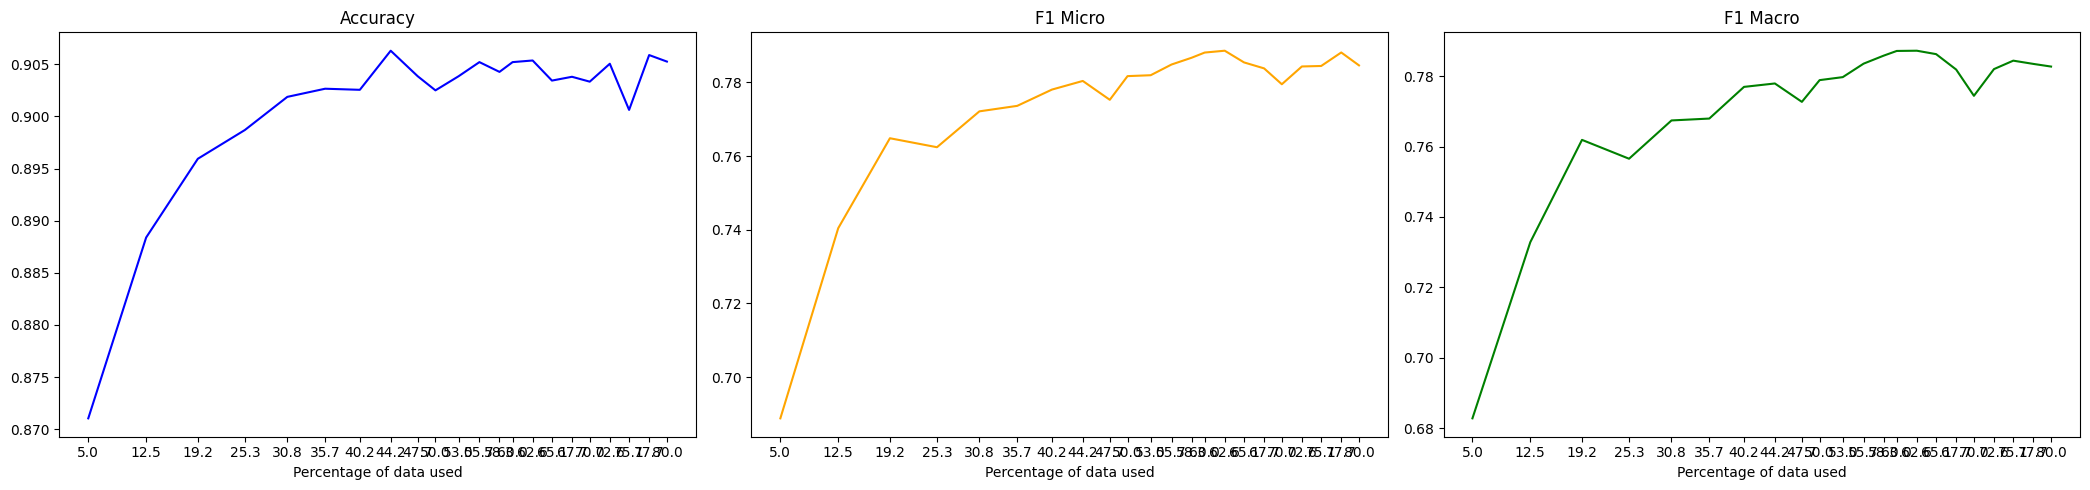

In [19]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: [14, 7, 33]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5968, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5341, Accuracy: 0.7977, F1 Micro: 0.0988, F1 Macro: 0.0805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4743, Accuracy: 0.8219, F1 Micro: 0.2893, F1 Macro: 0.1949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.39, Accuracy: 0.8345, F1 Micro: 0.4638, F1 Macro: 0.3804
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3545, Accuracy: 0.8441, F1 Micro: 0.5035, F1 Macro: 0.4353
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3005, Accuracy: 0.8581, F1 Micro: 0.6093, F1 Macro: 0.5602
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2678, Accuracy: 0.8648, F1 Micro: 0.628, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2021, Accuracy: 0.8675, F1 Micro: 0.657, F1 Macro: 0.6496
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1931, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5772, Accuracy: 0.7869, F1 Micro: 0.0015, F1 Macro: 0.001
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5189, Accuracy: 0.795, F1 Micro: 0.0787, F1 Macro: 0.0656
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4483, Accuracy: 0.832, F1 Micro: 0.4173, F1 Macro: 0.3637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3743, Accuracy: 0.8405, F1 Micro: 0.4734, F1 Macro: 0.426
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3321, Accuracy: 0.8566, F1 Micro: 0.5977, F1 Macro: 0.5621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2774, Accuracy: 0.8625, F1 Micro: 0.6474, F1 Macro: 0.6397
Epoch 7/10, Train Loss: 0.2571, Accuracy: 0.863, F1 Micro: 0.6375, F1 Macro: 0.6287
Epoch 8/10, Train Loss: 0.1862, Accuracy: 0.8658, F1 Micro: 0.6419, F1 Macro: 0.6313
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1764, Accuracy: 0.8667, F1 Micro: 0.6537, F1 Macro: 0.6414
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5975, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5331, Accuracy: 0.7891, F1 Micro: 0.0217, F1 Macro: 0.0195
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4706, Accuracy: 0.8233, F1 Micro: 0.2988, F1 Macro: 0.2114
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4013, Accuracy: 0.8339, F1 Micro: 0.4337, F1 Macro: 0.3452
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3537, Accuracy: 0.8436, F1 Micro: 0.5086, F1 Macro: 0.441
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2988, Accuracy: 0.8544, F1 Micro: 0.6077, F1 Macro: 0.5773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2637, Accuracy: 0.8564, F1 Micro: 0.6114, F1 Macro: 0.5816
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2036, Accuracy: 0.8642, F1 Micro: 0.6393, F1 Macro: 0.628
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1917,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5599, Accuracy: 0.793, F1 Micro: 0.098, F1 Macro: 0.0755
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4595, Accuracy: 0.8477, F1 Micro: 0.5796, F1 Macro: 0.5079
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3881, Accuracy: 0.867, F1 Micro: 0.6748, F1 Macro: 0.6779
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3269, Accuracy: 0.8778, F1 Micro: 0.675, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2563, Accuracy: 0.882, F1 Micro: 0.6861, F1 Macro: 0.6664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2151, Accuracy: 0.892, F1 Micro: 0.7401, F1 Macro: 0.7352
Epoch 7/10, Train Loss: 0.1758, Accuracy: 0.8878, F1 Micro: 0.7289, F1 Macro: 0.7233
Epoch 8/10, Train Loss: 0.1392, Accuracy: 0.8863, F1 Micro: 0.7217, F1 Macro: 0.7175
Epoch 9/10, Train Loss: 0.1132, Accuracy: 0.8859, F1 Micro: 0.7314, F1 Macro: 0.7255
Epoch 10/10, Train Loss: 0.0867, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5552, Accuracy: 0.79, F1 Micro: 0.0857, F1 Macro: 0.0713
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4479, Accuracy: 0.8583, F1 Micro: 0.6135, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3845, Accuracy: 0.8737, F1 Micro: 0.6909, F1 Macro: 0.6858
Epoch 4/10, Train Loss: 0.3251, Accuracy: 0.8769, F1 Micro: 0.6595, F1 Macro: 0.6338
Epoch 5/10, Train Loss: 0.2631, Accuracy: 0.8823, F1 Micro: 0.6829, F1 Macro: 0.6638
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2218, Accuracy: 0.8831, F1 Micro: 0.7182, F1 Macro: 0.711
Epoch 7/10, Train Loss: 0.1738, Accuracy: 0.8877, F1 Micro: 0.7157, F1 Macro: 0.7016
Epoch 8/10, Train Loss: 0.1327, Accuracy: 0.8855, F1 Micro: 0.7158, F1 Macro: 0.7078
Epoch 9/10, Train Loss: 0.1117, Accuracy: 0.8823, F1 Micro: 0.6866, F1 Macro: 0.6716
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0863, Accuracy: 0.8867, F1 Micro: 0.7191, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.562, Accuracy: 0.7939, F1 Micro: 0.1213, F1 Macro: 0.0737
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4662, Accuracy: 0.8545, F1 Micro: 0.6006, F1 Macro: 0.5582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.398, Accuracy: 0.8667, F1 Micro: 0.6723, F1 Macro: 0.6659
Epoch 4/10, Train Loss: 0.3343, Accuracy: 0.8744, F1 Micro: 0.6579, F1 Macro: 0.6328
Epoch 5/10, Train Loss: 0.2648, Accuracy: 0.8773, F1 Micro: 0.6722, F1 Macro: 0.6524
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2212, Accuracy: 0.8845, F1 Micro: 0.7219, F1 Macro: 0.7137
Epoch 7/10, Train Loss: 0.1807, Accuracy: 0.8831, F1 Micro: 0.6979, F1 Macro: 0.6842
Epoch 8/10, Train Loss: 0.1456, Accuracy: 0.8794, F1 Micro: 0.698, F1 Macro: 0.6859
Epoch 9/10, Train Loss: 0.1173, Accuracy: 0.8805, F1 Micro: 0.7029, F1 Macro: 0.6964
Epoch 10/10, Train Loss: 0.0863, Accuracy: 0.8828, F1 Micro: 0.7201, F1 Macro: 0.7132
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5622, Accuracy: 0.8413, F1 Micro: 0.492, F1 Macro: 0.4398
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.417, Accuracy: 0.8672, F1 Micro: 0.6545, F1 Macro: 0.6303
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3396, Accuracy: 0.8869, F1 Micro: 0.7438, F1 Macro: 0.7434
Epoch 4/10, Train Loss: 0.2738, Accuracy: 0.8889, F1 Micro: 0.7239, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2292, Accuracy: 0.8956, F1 Micro: 0.7546, F1 Macro: 0.7519
Epoch 6/10, Train Loss: 0.1793, Accuracy: 0.8952, F1 Micro: 0.7428, F1 Macro: 0.7354
Epoch 7/10, Train Loss: 0.144, Accuracy: 0.8988, F1 Micro: 0.749, F1 Macro: 0.7421
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1107, Accuracy: 0.8973, F1 Micro: 0.7578, F1 Macro: 0.7553
Epoch 9/10, Train Loss: 0.0847, Accuracy: 0.8958, F1 Micro: 0.7577, F1 Macro: 0.7557
Epoch 10/10, Train Loss: 0.067, Accuracy: 0.897, F1 Micro: 0.7427, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5534, Accuracy: 0.8406, F1 Micro: 0.588, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.409, Accuracy: 0.8725, F1 Micro: 0.6625, F1 Macro: 0.6338
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3343, Accuracy: 0.8844, F1 Micro: 0.7293, F1 Macro: 0.7279
Epoch 4/10, Train Loss: 0.2724, Accuracy: 0.8877, F1 Micro: 0.7263, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2345, Accuracy: 0.8922, F1 Micro: 0.7414, F1 Macro: 0.7398
Epoch 6/10, Train Loss: 0.1785, Accuracy: 0.8945, F1 Micro: 0.7381, F1 Macro: 0.7283
Epoch 7/10, Train Loss: 0.1407, Accuracy: 0.8955, F1 Micro: 0.7355, F1 Macro: 0.727
Epoch 8/10, Train Loss: 0.113, Accuracy: 0.8961, F1 Micro: 0.7381, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0862, Accuracy: 0.8984, F1 Micro: 0.749, F1 Macro: 0.7461
Epoch 10/10, Train Loss: 0.0674, Accuracy: 0.8939, F1 Micro: 0.7465, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5594, Accuracy: 0.8458, F1 Micro: 0.522, F1 Macro: 0.4859
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4191, Accuracy: 0.8652, F1 Micro: 0.6298, F1 Macro: 0.5803
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3363, Accuracy: 0.8813, F1 Micro: 0.7292, F1 Macro: 0.7258
Epoch 4/10, Train Loss: 0.2699, Accuracy: 0.888, F1 Micro: 0.7233, F1 Macro: 0.7122
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2278, Accuracy: 0.8958, F1 Micro: 0.7486, F1 Macro: 0.7455
Epoch 6/10, Train Loss: 0.1771, Accuracy: 0.8942, F1 Micro: 0.7365, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1489, Accuracy: 0.8953, F1 Micro: 0.75, F1 Macro: 0.744
Epoch 8/10, Train Loss: 0.1179, Accuracy: 0.8931, F1 Micro: 0.7436, F1 Macro: 0.7397
Epoch 9/10, Train Loss: 0.0841, Accuracy: 0.8933, F1 Micro: 0.7321, F1 Macro: 0.7268
Epoch 10/10, Train Loss: 0.063, Accuracy: 0.8938, F1 Micro: 0.7391, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5439, Accuracy: 0.857, F1 Micro: 0.6393, F1 Macro: 0.6066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.391, Accuracy: 0.8789, F1 Micro: 0.678, F1 Macro: 0.6598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3062, Accuracy: 0.8939, F1 Micro: 0.7307, F1 Macro: 0.7301
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2608, Accuracy: 0.8959, F1 Micro: 0.7394, F1 Macro: 0.7276
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2113, Accuracy: 0.8975, F1 Micro: 0.7459, F1 Macro: 0.7346
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1788, Accuracy: 0.8973, F1 Micro: 0.7615, F1 Macro: 0.7581
Epoch 7/10, Train Loss: 0.1215, Accuracy: 0.8966, F1 Micro: 0.7373, F1 Macro: 0.7329
Epoch 8/10, Train Loss: 0.102, Accuracy: 0.897, F1 Micro: 0.7542, F1 Macro: 0.7504
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.8984, F1 Micro: 0.7603, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.0619, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5449, Accuracy: 0.8558, F1 Micro: 0.6435, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3894, Accuracy: 0.8805, F1 Micro: 0.6771, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3103, Accuracy: 0.8908, F1 Micro: 0.7256, F1 Macro: 0.7213
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2654, Accuracy: 0.8934, F1 Micro: 0.7369, F1 Macro: 0.7291
Epoch 5/10, Train Loss: 0.2105, Accuracy: 0.8942, F1 Micro: 0.7247, F1 Macro: 0.7108
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1745, Accuracy: 0.8956, F1 Micro: 0.7479, F1 Macro: 0.7417
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1248, Accuracy: 0.8969, F1 Micro: 0.7519, F1 Macro: 0.7487
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.102, Accuracy: 0.8981, F1 Micro: 0.7528, F1 Macro: 0.7493
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0808, Accuracy: 0.8961, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5477, Accuracy: 0.853, F1 Micro: 0.6311, F1 Macro: 0.6097
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3916, Accuracy: 0.877, F1 Micro: 0.6714, F1 Macro: 0.6598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3121, Accuracy: 0.8859, F1 Micro: 0.7049, F1 Macro: 0.7012
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2636, Accuracy: 0.8922, F1 Micro: 0.7262, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2029, Accuracy: 0.895, F1 Micro: 0.7279, F1 Macro: 0.7144
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1676, Accuracy: 0.8941, F1 Micro: 0.7443, F1 Macro: 0.7396
Epoch 7/10, Train Loss: 0.1159, Accuracy: 0.8945, F1 Micro: 0.7377, F1 Macro: 0.7341
Epoch 8/10, Train Loss: 0.0981, Accuracy: 0.895, F1 Micro: 0.7387, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.8981, F1 Micro: 0.7576, F1 Macro: 0.7527
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5286, Accuracy: 0.8612, F1 Micro: 0.6334, F1 Macro: 0.621
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3738, Accuracy: 0.8839, F1 Micro: 0.7057, F1 Macro: 0.688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3028, Accuracy: 0.895, F1 Micro: 0.7415, F1 Macro: 0.7254
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2442, Accuracy: 0.9008, F1 Micro: 0.7671, F1 Macro: 0.7654
Epoch 5/10, Train Loss: 0.2015, Accuracy: 0.8972, F1 Micro: 0.7477, F1 Macro: 0.7372
Epoch 6/10, Train Loss: 0.1548, Accuracy: 0.8986, F1 Micro: 0.7658, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.1159, Accuracy: 0.8984, F1 Micro: 0.7609, F1 Macro: 0.7557
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.8948, F1 Micro: 0.7554, F1 Macro: 0.7496
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.8992, F1 Micro: 0.7524, F1 Macro: 0.7457
Epoch 10/10, Train Loss: 0.055, Accuracy: 0.8966, F1 Micro: 0.7519, F1 Macro: 0.7468
Model 1 - Iteration 2

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5192, Accuracy: 0.873, F1 Micro: 0.662, F1 Macro: 0.6639
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3723, Accuracy: 0.8859, F1 Micro: 0.7177, F1 Macro: 0.7045
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3045, Accuracy: 0.8941, F1 Micro: 0.7307, F1 Macro: 0.7163
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.245, Accuracy: 0.8919, F1 Micro: 0.763, F1 Macro: 0.7644
Epoch 5/10, Train Loss: 0.2096, Accuracy: 0.8975, F1 Micro: 0.7407, F1 Macro: 0.73
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1547, Accuracy: 0.8977, F1 Micro: 0.7691, F1 Macro: 0.7703
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.8933, F1 Micro: 0.7608, F1 Macro: 0.7612
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.8986, F1 Micro: 0.7487, F1 Macro: 0.744
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.8944, F1 Micro: 0.7522, F1 Macro: 0.7523
Epoch 10/10, Train Loss: 0.0589, Accuracy: 0.8986, F1 Micro: 0.759, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5332, Accuracy: 0.8612, F1 Micro: 0.6442, F1 Macro: 0.642
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3813, Accuracy: 0.8838, F1 Micro: 0.7029, F1 Macro: 0.6858
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3065, Accuracy: 0.8941, F1 Micro: 0.7443, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2467, Accuracy: 0.8977, F1 Micro: 0.7603, F1 Macro: 0.7575
Epoch 5/10, Train Loss: 0.199, Accuracy: 0.8969, F1 Micro: 0.7465, F1 Macro: 0.7361
Epoch 6/10, Train Loss: 0.1596, Accuracy: 0.898, F1 Micro: 0.7559, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1186, Accuracy: 0.8941, F1 Micro: 0.7631, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.8977, F1 Micro: 0.7651, F1 Macro: 0.7647
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.8955, F1 Micro: 0.7547, F1 Macro: 0.7518
Epoch 10/10, Train Loss: 0.0582, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4965, Accuracy: 0.8658, F1 Micro: 0.7097, F1 Macro: 0.714
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3573, Accuracy: 0.8914, F1 Micro: 0.7412, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3048, Accuracy: 0.8986, F1 Micro: 0.7509, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2453, Accuracy: 0.9011, F1 Micro: 0.7756, F1 Macro: 0.7677
Epoch 5/10, Train Loss: 0.2008, Accuracy: 0.8967, F1 Micro: 0.7709, F1 Macro: 0.771
Epoch 6/10, Train Loss: 0.1521, Accuracy: 0.9011, F1 Micro: 0.7592, F1 Macro: 0.7485
Epoch 7/10, Train Loss: 0.1153, Accuracy: 0.8991, F1 Micro: 0.76, F1 Macro: 0.7517
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9016, F1 Micro: 0.751, F1 Macro: 0.7402
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9003, F1 Micro: 0.7589, F1 Macro: 0.7489
Epoch 10/10, Train Loss: 0.0526, Accuracy: 0.9022, F1 Micro: 0.7676, F1 Macro: 0.7594
Model 1 - Iteration 27

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4924, Accuracy: 0.868, F1 Micro: 0.6888, F1 Macro: 0.6934
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3538, Accuracy: 0.8948, F1 Micro: 0.7438, F1 Macro: 0.74
Epoch 3/10, Train Loss: 0.306, Accuracy: 0.897, F1 Micro: 0.7361, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.243, Accuracy: 0.8973, F1 Micro: 0.7683, F1 Macro: 0.7654
Epoch 5/10, Train Loss: 0.1994, Accuracy: 0.8964, F1 Micro: 0.7678, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.9022, F1 Micro: 0.762, F1 Macro: 0.7498
Epoch 7/10, Train Loss: 0.1171, Accuracy: 0.8995, F1 Micro: 0.7598, F1 Macro: 0.7555
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.9, F1 Micro: 0.7605, F1 Macro: 0.7551
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.8986, F1 Micro: 0.7497, F1 Macro: 0.7369
Epoch 10/10, Train Loss: 0.0576, Accuracy: 0.9003, F1 Micro: 0.7535, F1 Macro: 0.7464
Model 2 - Iteration 2777: Accuracy: 0.8973, F1 Micro: 0.7683

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5066, Accuracy: 0.862, F1 Micro: 0.6881, F1 Macro: 0.6905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3614, Accuracy: 0.8886, F1 Micro: 0.7312, F1 Macro: 0.73
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3058, Accuracy: 0.8948, F1 Micro: 0.7386, F1 Macro: 0.7272
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2413, Accuracy: 0.8992, F1 Micro: 0.7671, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2026, Accuracy: 0.8988, F1 Micro: 0.7694, F1 Macro: 0.769
Epoch 6/10, Train Loss: 0.1529, Accuracy: 0.902, F1 Micro: 0.7531, F1 Macro: 0.7421
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.9, F1 Micro: 0.7581, F1 Macro: 0.7513
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9013, F1 Micro: 0.755, F1 Macro: 0.7459
Epoch 9/10, Train Loss: 0.0657, Accuracy: 0.8994, F1 Micro: 0.7586, F1 Macro: 0.753
Epoch 10/10, Train Loss: 0.0601, Accuracy: 0.8969, F1 Micro: 0.7454, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4848, Accuracy: 0.8716, F1 Micro: 0.6836, F1 Macro: 0.6777
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3455, Accuracy: 0.8952, F1 Micro: 0.7438, F1 Macro: 0.7336
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2804, Accuracy: 0.8952, F1 Micro: 0.7726, F1 Macro: 0.7724
Epoch 4/10, Train Loss: 0.2386, Accuracy: 0.9011, F1 Micro: 0.7628, F1 Macro: 0.7569
Epoch 5/10, Train Loss: 0.1984, Accuracy: 0.9031, F1 Micro: 0.7726, F1 Macro: 0.7716
Epoch 6/10, Train Loss: 0.1437, Accuracy: 0.9013, F1 Micro: 0.7687, F1 Macro: 0.7594
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9009, F1 Micro: 0.7652, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9055, F1 Micro: 0.773, F1 Macro: 0.7656
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.9028, F1 Micro: 0.7677, F1 Macro: 0.7688
Epoch 10/10, Train Loss: 0.0554, Accuracy: 0.9027, F1 Micro: 0.7664, F1 Macro: 0.7579
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4821, Accuracy: 0.8806, F1 Micro: 0.7032, F1 Macro: 0.6908
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3492, Accuracy: 0.8931, F1 Micro: 0.7431, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2817, Accuracy: 0.8959, F1 Micro: 0.7713, F1 Macro: 0.7724
Epoch 4/10, Train Loss: 0.2467, Accuracy: 0.903, F1 Micro: 0.7585, F1 Macro: 0.7518
Epoch 5/10, Train Loss: 0.1952, Accuracy: 0.9028, F1 Micro: 0.766, F1 Macro: 0.7623
Epoch 6/10, Train Loss: 0.1521, Accuracy: 0.8967, F1 Micro: 0.7538, F1 Macro: 0.7354
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.9002, F1 Micro: 0.7655, F1 Macro: 0.7631
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.8998, F1 Micro: 0.7641, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.9039, F1 Micro: 0.773, F1 Macro: 0.7716
Epoch 10/10, Train Loss: 0.0566, Accuracy: 0.8997, F1 Micro: 0.7617, F1 Macro: 0.7585
Model 2 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4916, Accuracy: 0.8706, F1 Micro: 0.6868, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3517, Accuracy: 0.8919, F1 Micro: 0.7347, F1 Macro: 0.7232
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2829, Accuracy: 0.8964, F1 Micro: 0.7676, F1 Macro: 0.7637
Epoch 4/10, Train Loss: 0.24, Accuracy: 0.9017, F1 Micro: 0.7649, F1 Macro: 0.7592
Epoch 5/10, Train Loss: 0.1953, Accuracy: 0.9025, F1 Micro: 0.7596, F1 Macro: 0.7539
Epoch 6/10, Train Loss: 0.1488, Accuracy: 0.9005, F1 Micro: 0.7635, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9006, F1 Micro: 0.7622, F1 Macro: 0.7558
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9013, F1 Micro: 0.7671, F1 Macro: 0.761
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9033, F1 Micro: 0.7654, F1 Macro: 0.7613
Epoch 10/10, Train Loss: 0.0549, Accuracy: 0.902, F1 Micro: 0.7668, F1 Macro: 0.7643
Model 3 - Iteration 3122: Accuracy: 0.8964, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4901, Accuracy: 0.868, F1 Micro: 0.6321, F1 Macro: 0.6224
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3371, Accuracy: 0.8931, F1 Micro: 0.7527, F1 Macro: 0.7443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2767, Accuracy: 0.9056, F1 Micro: 0.7686, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2297, Accuracy: 0.9019, F1 Micro: 0.7721, F1 Macro: 0.7695
Epoch 5/10, Train Loss: 0.1823, Accuracy: 0.9008, F1 Micro: 0.7515, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.9059, F1 Micro: 0.7759, F1 Macro: 0.7756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9069, F1 Micro: 0.7791, F1 Macro: 0.7734
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9053, F1 Micro: 0.7785, F1 Macro: 0.7748
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.9033, F1 Micro: 0.771, F1 Macro: 0.7671
Epoch 10/10, Train Loss: 0.05, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4906, Accuracy: 0.8656, F1 Micro: 0.6331, F1 Macro: 0.6207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3402, Accuracy: 0.8919, F1 Micro: 0.7397, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2752, Accuracy: 0.9023, F1 Micro: 0.7628, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2255, Accuracy: 0.8998, F1 Micro: 0.7648, F1 Macro: 0.7563
Epoch 5/10, Train Loss: 0.1819, Accuracy: 0.902, F1 Micro: 0.7538, F1 Macro: 0.7423
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.9017, F1 Micro: 0.7663, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.103, Accuracy: 0.9036, F1 Micro: 0.7739, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.9017, F1 Micro: 0.7784, F1 Macro: 0.7771
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.9009, F1 Micro: 0.7739, F1 Macro: 0.7713
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4944, Accuracy: 0.863, F1 Micro: 0.631, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.341, Accuracy: 0.8864, F1 Micro: 0.735, F1 Macro: 0.7187
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2787, Accuracy: 0.8988, F1 Micro: 0.7429, F1 Macro: 0.7295
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2267, Accuracy: 0.8989, F1 Micro: 0.7606, F1 Macro: 0.75
Epoch 5/10, Train Loss: 0.1868, Accuracy: 0.8998, F1 Micro: 0.7497, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9027, F1 Micro: 0.7705, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9045, F1 Micro: 0.774, F1 Macro: 0.7691
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.9019, F1 Micro: 0.7736, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.8997, F1 Micro: 0.7765, F1 Macro: 0.7763
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4769, Accuracy: 0.8737, F1 Micro: 0.7301, F1 Macro: 0.7311
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3325, Accuracy: 0.8947, F1 Micro: 0.7517, F1 Macro: 0.7489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.269, Accuracy: 0.8986, F1 Micro: 0.7552, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2168, Accuracy: 0.9038, F1 Micro: 0.771, F1 Macro: 0.7658
Epoch 5/10, Train Loss: 0.1829, Accuracy: 0.9033, F1 Micro: 0.7681, F1 Macro: 0.7556
Epoch 6/10, Train Loss: 0.1413, Accuracy: 0.8989, F1 Micro: 0.7522, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.9067, F1 Micro: 0.7715, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9048, F1 Micro: 0.7799, F1 Macro: 0.7792
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9047, F1 Micro: 0.7759, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4709, Accuracy: 0.8809, F1 Micro: 0.7288, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3331, Accuracy: 0.895, F1 Micro: 0.7537, F1 Macro: 0.7546
Epoch 3/10, Train Loss: 0.2713, Accuracy: 0.8964, F1 Micro: 0.7403, F1 Macro: 0.7395
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2214, Accuracy: 0.9058, F1 Micro: 0.7838, F1 Macro: 0.7833
Epoch 5/10, Train Loss: 0.1774, Accuracy: 0.9034, F1 Micro: 0.7709, F1 Macro: 0.7638
Epoch 6/10, Train Loss: 0.1432, Accuracy: 0.9025, F1 Micro: 0.7617, F1 Macro: 0.755
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9069, F1 Micro: 0.7718, F1 Macro: 0.7685
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9067, F1 Micro: 0.7801, F1 Macro: 0.7803
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9056, F1 Micro: 0.7827, F1 Macro: 0.7807
Epoch 10/10, Train Loss: 0.0489, Accuracy: 0.902, F1 Micro: 0.7765, F1 Macro: 0.7775
Model 2 - Iteration 3711: Accuracy: 0.9058, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4811, Accuracy: 0.8753, F1 Micro: 0.72, F1 Macro: 0.7229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3328, Accuracy: 0.8925, F1 Micro: 0.7507, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.271, Accuracy: 0.8994, F1 Micro: 0.7542, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2207, Accuracy: 0.9041, F1 Micro: 0.7744, F1 Macro: 0.7687
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9058, F1 Micro: 0.7732, F1 Macro: 0.7668
Epoch 6/10, Train Loss: 0.1332, Accuracy: 0.9025, F1 Micro: 0.7742, F1 Macro: 0.7677
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9017, F1 Micro: 0.7536, F1 Macro: 0.746
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.9009, F1 Micro: 0.7723, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.905, F1 Micro: 0.7711, F1 Macro: 0.7673
Epoch 10/10, Train Loss: 0.0507, Accuracy: 0.9011, F1 Micro: 0.7737, F1 Macro: 0.773
Model 3 - Iteration 371

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4647, Accuracy: 0.8702, F1 Micro: 0.6672, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3249, Accuracy: 0.8953, F1 Micro: 0.7354, F1 Macro: 0.7252
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2678, Accuracy: 0.9022, F1 Micro: 0.7669, F1 Macro: 0.7596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2208, Accuracy: 0.9038, F1 Micro: 0.773, F1 Macro: 0.7731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1811, Accuracy: 0.903, F1 Micro: 0.7769, F1 Macro: 0.7763
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9053, F1 Micro: 0.7749, F1 Macro: 0.7749
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9013, F1 Micro: 0.7617, F1 Macro: 0.758
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9036, F1 Micro: 0.7765, F1 Macro: 0.7735
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9042, F1 Micro: 0.7715, F1 Macro: 0.7676
Epoch 10/10, Train Loss: 0.0456, Accuracy: 0.9013, F1 Micro: 0.7722, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4599, Accuracy: 0.8773, F1 Micro: 0.6913, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3257, Accuracy: 0.8923, F1 Micro: 0.7221, F1 Macro: 0.7105
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2677, Accuracy: 0.9047, F1 Micro: 0.7774, F1 Macro: 0.7729
Epoch 4/10, Train Loss: 0.2198, Accuracy: 0.9011, F1 Micro: 0.7524, F1 Macro: 0.7505
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.9027, F1 Micro: 0.7722, F1 Macro: 0.7694
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9038, F1 Micro: 0.7695, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.902, F1 Micro: 0.7691, F1 Macro: 0.7679
Epoch 8/10, Train Loss: 0.0716, Accuracy: 0.9038, F1 Micro: 0.7645, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9038, F1 Micro: 0.7823, F1 Macro: 0.7828
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0455, Accuracy: 0.9064, F1 Micro: 0.7848, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.467, Accuracy: 0.8778, F1 Micro: 0.6929, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.323, Accuracy: 0.8928, F1 Micro: 0.7252, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2661, Accuracy: 0.9033, F1 Micro: 0.7732, F1 Macro: 0.7675
Epoch 4/10, Train Loss: 0.2159, Accuracy: 0.9041, F1 Micro: 0.7655, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1797, Accuracy: 0.9066, F1 Micro: 0.777, F1 Macro: 0.7729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9044, F1 Micro: 0.7792, F1 Macro: 0.7812
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9042, F1 Micro: 0.7736, F1 Macro: 0.7689
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9009, F1 Micro: 0.7742, F1 Macro: 0.7736
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.8988, F1 Micro: 0.7742, F1 Macro: 0.7761
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.8995, F1 Micro: 0.7721, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4619, Accuracy: 0.8778, F1 Micro: 0.6739, F1 Macro: 0.6641
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3231, Accuracy: 0.8991, F1 Micro: 0.7517, F1 Macro: 0.7431
Epoch 3/10, Train Loss: 0.2615, Accuracy: 0.9005, F1 Micro: 0.7405, F1 Macro: 0.7252
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2206, Accuracy: 0.9053, F1 Micro: 0.7739, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9064, F1 Micro: 0.7744, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1251, Accuracy: 0.9062, F1 Micro: 0.7751, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.093, Accuracy: 0.9094, F1 Micro: 0.7815, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.9067, F1 Micro: 0.7842, F1 Macro: 0.782
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9055, F1 Micro: 0.7842, F1 Macro: 0.7834
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4517, Accuracy: 0.8686, F1 Micro: 0.6274, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3214, Accuracy: 0.8997, F1 Micro: 0.748, F1 Macro: 0.7407
Epoch 3/10, Train Loss: 0.2696, Accuracy: 0.8952, F1 Micro: 0.716, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2252, Accuracy: 0.8994, F1 Micro: 0.7508, F1 Macro: 0.7476
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.168, Accuracy: 0.9031, F1 Micro: 0.7589, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9042, F1 Micro: 0.7732, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.9061, F1 Micro: 0.7825, F1 Macro: 0.7807
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9069, F1 Micro: 0.7833, F1 Macro: 0.7835
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9045, F1 Micro: 0.7658, F1 Macro: 0.7647
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4638, Accuracy: 0.8675, F1 Micro: 0.6221, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3225, Accuracy: 0.8988, F1 Micro: 0.7527, F1 Macro: 0.7468
Epoch 3/10, Train Loss: 0.2657, Accuracy: 0.8986, F1 Micro: 0.7297, F1 Macro: 0.7161
Epoch 4/10, Train Loss: 0.2226, Accuracy: 0.8983, F1 Micro: 0.7482, F1 Macro: 0.7447
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.9055, F1 Micro: 0.7745, F1 Macro: 0.7688
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9045, F1 Micro: 0.7706, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9062, F1 Micro: 0.7778, F1 Macro: 0.7736
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9048, F1 Micro: 0.7735, F1 Macro: 0.7703
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9066, F1 Micro: 0.7779, F1 Macro: 0.7739
Epoch 10/10, Train Loss: 0.0452, Accuracy: 0.9044, F1 Micro: 0.7743, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4489, Accuracy: 0.8852, F1 Micro: 0.7183, F1 Macro: 0.7057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3161, Accuracy: 0.902, F1 Micro: 0.7626, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2539, Accuracy: 0.9023, F1 Micro: 0.7633, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2022, Accuracy: 0.907, F1 Micro: 0.7837, F1 Macro: 0.7777
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9039, F1 Micro: 0.7862, F1 Macro: 0.7831
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9056, F1 Micro: 0.7916, F1 Macro: 0.7917
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9045, F1 Micro: 0.7728, F1 Macro: 0.7656
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9053, F1 Micro: 0.7859, F1 Macro: 0.7826
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9047, F1 Micro: 0.7875, F1 Macro: 0.7884
Epoch 10/10, Train Loss: 0.0426, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4395, Accuracy: 0.8873, F1 Micro: 0.7303, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3178, Accuracy: 0.9013, F1 Micro: 0.7636, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.255, Accuracy: 0.9033, F1 Micro: 0.7683, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2063, Accuracy: 0.9041, F1 Micro: 0.7721, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9041, F1 Micro: 0.7835, F1 Macro: 0.7838
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.903, F1 Micro: 0.7657, F1 Macro: 0.7627
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9056, F1 Micro: 0.7778, F1 Macro: 0.7748
Epoch 8/10, Train Loss: 0.0716, Accuracy: 0.9027, F1 Micro: 0.7709, F1 Macro: 0.7648
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9013, F1 Micro: 0.7757, F1 Macro: 0.7757
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.905, F1 Micro: 0.777, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4513, Accuracy: 0.8841, F1 Micro: 0.7174, F1 Macro: 0.7127
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3193, Accuracy: 0.8981, F1 Micro: 0.7645, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2572, Accuracy: 0.9041, F1 Micro: 0.7693, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2026, Accuracy: 0.9077, F1 Micro: 0.7872, F1 Macro: 0.7818
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9027, F1 Micro: 0.781, F1 Macro: 0.7824
Epoch 6/10, Train Loss: 0.1257, Accuracy: 0.9061, F1 Micro: 0.7758, F1 Macro: 0.7725
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9028, F1 Micro: 0.7797, F1 Macro: 0.7773
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9041, F1 Micro: 0.7791, F1 Macro: 0.7771
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.8995, F1 Micro: 0.7753, F1 Macro: 0.7755
Epoch 10/10, Train Loss: 0.046, Accuracy: 0.9062, F1 Micro: 0.7722, F1 Macro: 0.7705
Model 3 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.431, Accuracy: 0.8895, F1 Micro: 0.7392, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2967, Accuracy: 0.8978, F1 Micro: 0.7668, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2419, Accuracy: 0.9023, F1 Micro: 0.7805, F1 Macro: 0.777
Epoch 4/10, Train Loss: 0.1983, Accuracy: 0.9075, F1 Micro: 0.7761, F1 Macro: 0.7707
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9023, F1 Micro: 0.7672, F1 Macro: 0.7596
Epoch 6/10, Train Loss: 0.1238, Accuracy: 0.9052, F1 Micro: 0.7657, F1 Macro: 0.7612
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.9028, F1 Micro: 0.7746, F1 Macro: 0.7709
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9034, F1 Micro: 0.7745, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.8997, F1 Micro: 0.7738, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.9047, F1 Micro: 0.7798, F1 Macro: 0.7766
Model 1 - Iteration 4530: Accuracy: 0.9023, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4277, Accuracy: 0.8877, F1 Micro: 0.7328, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2995, Accuracy: 0.8978, F1 Micro: 0.7691, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2469, Accuracy: 0.9036, F1 Micro: 0.7814, F1 Macro: 0.779
Epoch 4/10, Train Loss: 0.1989, Accuracy: 0.9056, F1 Micro: 0.7746, F1 Macro: 0.7699
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.9031, F1 Micro: 0.7808, F1 Macro: 0.7783
Epoch 6/10, Train Loss: 0.1257, Accuracy: 0.9042, F1 Micro: 0.7681, F1 Macro: 0.7659
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9045, F1 Micro: 0.779, F1 Macro: 0.777
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9013, F1 Micro: 0.7801, F1 Macro: 0.7789
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9009, F1 Micro: 0.7732, F1 Macro: 0.7724
Epoch 10/10, Train Loss: 0.0468, Accuracy: 0.9034, F1 Micro: 0.768, F1 Macro: 0.7604
Model 2 - Iteration 4530: Accuracy: 0.9036, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4355, Accuracy: 0.8831, F1 Micro: 0.7276, F1 Macro: 0.7276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2974, Accuracy: 0.897, F1 Micro: 0.7685, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2431, Accuracy: 0.9055, F1 Micro: 0.7873, F1 Macro: 0.7842
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2025, Accuracy: 0.9078, F1 Micro: 0.7902, F1 Macro: 0.788
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9019, F1 Micro: 0.783, F1 Macro: 0.7791
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9091, F1 Micro: 0.7799, F1 Macro: 0.7777
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.907, F1 Micro: 0.7791, F1 Macro: 0.7786
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.902, F1 Micro: 0.7685, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9052, F1 Micro: 0.7785, F1 Macro: 0.7767
Epoch 10/10, Train Loss: 0.0456, Accuracy: 0.905, F1 Micro: 0.7743, F1 Macro: 0.7674
Model 3 - Iteration 453

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4298, Accuracy: 0.8856, F1 Micro: 0.7423, F1 Macro: 0.7373
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2932, Accuracy: 0.8978, F1 Micro: 0.7599, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2483, Accuracy: 0.9027, F1 Micro: 0.7687, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9059, F1 Micro: 0.7839, F1 Macro: 0.7771
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.9067, F1 Micro: 0.7803, F1 Macro: 0.7702
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9011, F1 Micro: 0.7653, F1 Macro: 0.7598
Epoch 7/10, Train Loss: 0.0941, Accuracy: 0.9014, F1 Micro: 0.7784, F1 Macro: 0.7773
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9028, F1 Micro: 0.7821, F1 Macro: 0.7807
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9055, F1 Micro: 0.7723, F1 Macro: 0.764
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.9059, F1 Micro: 0.7811, F1 Macro: 0.7768
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4265, Accuracy: 0.8827, F1 Micro: 0.7417, F1 Macro: 0.7364
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2988, Accuracy: 0.8977, F1 Micro: 0.7616, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2527, Accuracy: 0.9034, F1 Micro: 0.7691, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2061, Accuracy: 0.9019, F1 Micro: 0.7816, F1 Macro: 0.7773
Epoch 5/10, Train Loss: 0.163, Accuracy: 0.9036, F1 Micro: 0.7662, F1 Macro: 0.7542
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.9005, F1 Micro: 0.7695, F1 Macro: 0.7696
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9059, F1 Micro: 0.7775, F1 Macro: 0.7767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9053, F1 Micro: 0.7897, F1 Macro: 0.7881
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9041, F1 Micro: 0.7731, F1 Macro: 0.7654
Epoch 10/10, Train Loss: 0.0413, Accuracy: 0.9052, F1 Micro: 0.7686, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4389, Accuracy: 0.8814, F1 Micro: 0.7304, F1 Macro: 0.7251
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2943, Accuracy: 0.9003, F1 Micro: 0.7632, F1 Macro: 0.7569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2491, Accuracy: 0.9073, F1 Micro: 0.7838, F1 Macro: 0.7765
Epoch 4/10, Train Loss: 0.2026, Accuracy: 0.9058, F1 Micro: 0.7832, F1 Macro: 0.776
Epoch 5/10, Train Loss: 0.1553, Accuracy: 0.9062, F1 Micro: 0.777, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9014, F1 Micro: 0.7739, F1 Macro: 0.7725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0915, Accuracy: 0.9083, F1 Micro: 0.7865, F1 Macro: 0.7853
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.905, F1 Micro: 0.7833, F1 Macro: 0.7813
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9038, F1 Micro: 0.7758, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.0434, Accuracy: 0.9041, F1 Micro: 0.766, F1 Macro: 0.7598
Model 3 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4177, Accuracy: 0.8802, F1 Micro: 0.7053, F1 Macro: 0.7066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2875, Accuracy: 0.9002, F1 Micro: 0.7491, F1 Macro: 0.7437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2315, Accuracy: 0.9016, F1 Micro: 0.7721, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9047, F1 Micro: 0.7864, F1 Macro: 0.7844
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.9045, F1 Micro: 0.7755, F1 Macro: 0.7716
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.9039, F1 Micro: 0.7628, F1 Macro: 0.7547
Epoch 7/10, Train Loss: 0.0856, Accuracy: 0.9061, F1 Micro: 0.7747, F1 Macro: 0.7686
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9003, F1 Micro: 0.7749, F1 Macro: 0.7753
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9022, F1 Micro: 0.782, F1 Macro: 0.7808
Epoch 10/10, Train Loss: 0.0471, Accuracy: 0.9034, F1 Micro: 0.7696, F1 Macro: 0.7638
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4138, Accuracy: 0.8817, F1 Micro: 0.7138, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.288, Accuracy: 0.8969, F1 Micro: 0.7347, F1 Macro: 0.7343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2338, Accuracy: 0.9017, F1 Micro: 0.774, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1883, Accuracy: 0.9047, F1 Micro: 0.7832, F1 Macro: 0.7789
Epoch 5/10, Train Loss: 0.156, Accuracy: 0.9036, F1 Micro: 0.7739, F1 Macro: 0.772
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9062, F1 Micro: 0.768, F1 Macro: 0.7614
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9011, F1 Micro: 0.766, F1 Macro: 0.7561
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9019, F1 Micro: 0.7747, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.8997, F1 Micro: 0.7769, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.9056, F1 Micro: 0.7799, F1 Macro: 0.7757
Model 2 - Iteration 486

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4215, Accuracy: 0.8841, F1 Micro: 0.7198, F1 Macro: 0.7148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2881, Accuracy: 0.9002, F1 Micro: 0.7513, F1 Macro: 0.7447
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2304, Accuracy: 0.9039, F1 Micro: 0.772, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9045, F1 Micro: 0.7917, F1 Macro: 0.7909
Epoch 5/10, Train Loss: 0.1629, Accuracy: 0.9061, F1 Micro: 0.7836, F1 Macro: 0.7788
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.9095, F1 Micro: 0.7821, F1 Macro: 0.7769
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9067, F1 Micro: 0.7729, F1 Macro: 0.7675
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9025, F1 Micro: 0.7783, F1 Macro: 0.775
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.903, F1 Micro: 0.7873, F1 Macro: 0.7871
Epoch 10/10, Train Loss: 0.0471, Accuracy: 0.9052, F1 Micro: 0.7741, F1 Macro: 0.764
Model 3 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4109, Accuracy: 0.882, F1 Micro: 0.7031, F1 Macro: 0.7017
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2731, Accuracy: 0.9014, F1 Micro: 0.7703, F1 Macro: 0.7669
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2286, Accuracy: 0.9056, F1 Micro: 0.7838, F1 Macro: 0.7807
Epoch 4/10, Train Loss: 0.1834, Accuracy: 0.9016, F1 Micro: 0.7545, F1 Macro: 0.7497
Epoch 5/10, Train Loss: 0.1492, Accuracy: 0.9073, F1 Micro: 0.7738, F1 Macro: 0.7696
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9041, F1 Micro: 0.7669, F1 Macro: 0.7612
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.898, F1 Micro: 0.7735, F1 Macro: 0.77
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.898, F1 Micro: 0.7722, F1 Macro: 0.7724
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9028, F1 Micro: 0.7833, F1 Macro: 0.7789
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.9009, F1 Micro: 0.7789, F1 Macro: 0.7744
Model 1 - Iteration 5063: Accuracy: 0.9056, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4072, Accuracy: 0.887, F1 Micro: 0.7109, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2741, Accuracy: 0.8986, F1 Micro: 0.7544, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2294, Accuracy: 0.9028, F1 Micro: 0.7708, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.905, F1 Micro: 0.7735, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9084, F1 Micro: 0.7757, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.9023, F1 Micro: 0.7775, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9033, F1 Micro: 0.7788, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.902, F1 Micro: 0.7831, F1 Macro: 0.7852
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.04

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4158, Accuracy: 0.8761, F1 Micro: 0.6847, F1 Macro: 0.6802
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2757, Accuracy: 0.9023, F1 Micro: 0.7665, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2266, Accuracy: 0.9039, F1 Micro: 0.7809, F1 Macro: 0.7778
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9044, F1 Micro: 0.768, F1 Macro: 0.7625
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9078, F1 Micro: 0.7769, F1 Macro: 0.7748
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.9067, F1 Micro: 0.7753, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9058, F1 Micro: 0.7811, F1 Macro: 0.7768
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9064, F1 Micro: 0.7807, F1 Macro: 0.7778
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9053, F1 Micro: 0.78, F1 Macro: 0.776
Epoch 10/10, Train Loss: 0.0391, Accuracy: 0.9056, F1 Micro: 0.78, F1 Macro: 0.7738
Model 3 - Iteration 506

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4068, Accuracy: 0.8895, F1 Micro: 0.7317, F1 Macro: 0.7255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2762, Accuracy: 0.9027, F1 Micro: 0.772, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2211, Accuracy: 0.9036, F1 Micro: 0.7732, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.9058, F1 Micro: 0.7855, F1 Macro: 0.7853
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9061, F1 Micro: 0.7885, F1 Macro: 0.7856
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.907, F1 Micro: 0.7774, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9045, F1 Micro: 0.7889, F1 Macro: 0.7874
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9045, F1 Micro: 0.7812, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9028, F1 Micro: 0.7794, F1 Macro: 0.7769
Epoch 10/10, Train Loss: 0.0334, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4001, Accuracy: 0.8875, F1 Micro: 0.7094, F1 Macro: 0.7015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2756, Accuracy: 0.9008, F1 Micro: 0.7583, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2234, Accuracy: 0.9034, F1 Micro: 0.7736, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.9052, F1 Micro: 0.7851, F1 Macro: 0.7836
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.9031, F1 Micro: 0.782, F1 Macro: 0.7809
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9094, F1 Micro: 0.7743, F1 Macro: 0.7634
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9047, F1 Micro: 0.781, F1 Macro: 0.7767
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9028, F1 Micro: 0.7741, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.9003, F1 Micro: 0.7758, F1 Macro: 0.7712
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.9038, F1 Micro: 0.7778, F1 Macro: 0.7756
Model 2 - Iteration 52

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4082, Accuracy: 0.887, F1 Micro: 0.7285, F1 Macro: 0.7255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2753, Accuracy: 0.9028, F1 Micro: 0.7732, F1 Macro: 0.7695
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2221, Accuracy: 0.9033, F1 Micro: 0.774, F1 Macro: 0.771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.9052, F1 Micro: 0.7825, F1 Macro: 0.7814
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9075, F1 Micro: 0.7898, F1 Macro: 0.7853
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9073, F1 Micro: 0.7808, F1 Macro: 0.7705
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9052, F1 Micro: 0.7854, F1 Macro: 0.7841
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9055, F1 Micro: 0.7783, F1 Macro: 0.7738
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.902, F1 Micro: 0.7763, F1 Macro: 0.7733
Epoch 10/10, Train Loss: 0.0371, Accuracy: 0.9014, F1 Micro: 0.7787, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3908, Accuracy: 0.8888, F1 Micro: 0.7443, F1 Macro: 0.734
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.275, Accuracy: 0.8989, F1 Micro: 0.748, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2161, Accuracy: 0.9036, F1 Micro: 0.7651, F1 Macro: 0.7556
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.8969, F1 Micro: 0.7238, F1 Macro: 0.7031
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9033, F1 Micro: 0.7574, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1013, Accuracy: 0.9033, F1 Micro: 0.7806, F1 Macro: 0.7742
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9048, F1 Micro: 0.777, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9055, F1 Micro: 0.7817, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9041, F1 Micro: 0.7865, F1 Macro: 0.7848
Epoch 10/10, Train Loss: 0.0342, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.386, Accuracy: 0.8881, F1 Micro: 0.7432, F1 Macro: 0.7353
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.277, Accuracy: 0.898, F1 Micro: 0.7452, F1 Macro: 0.729
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2168, Accuracy: 0.9019, F1 Micro: 0.757, F1 Macro: 0.7426
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.8978, F1 Micro: 0.7357, F1 Macro: 0.7202
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.905, F1 Micro: 0.7606, F1 Macro: 0.7527
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9011, F1 Micro: 0.7738, F1 Macro: 0.7689
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.898, F1 Micro: 0.7452, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9069, F1 Micro: 0.7833, F1 Macro: 0.7793
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.903, F1 Micro: 0.7769, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3935, Accuracy: 0.8884, F1 Micro: 0.7385, F1 Macro: 0.727
Epoch 2/10, Train Loss: 0.2738, Accuracy: 0.895, F1 Micro: 0.7329, F1 Macro: 0.7091
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2149, Accuracy: 0.9044, F1 Micro: 0.7664, F1 Macro: 0.7546
Epoch 4/10, Train Loss: 0.1763, Accuracy: 0.8986, F1 Micro: 0.7365, F1 Macro: 0.72
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9031, F1 Micro: 0.7502, F1 Macro: 0.7413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.903, F1 Micro: 0.7816, F1 Macro: 0.7796
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.9047, F1 Micro: 0.7744, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9052, F1 Micro: 0.7847, F1 Macro: 0.7816
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9045, F1 Micro: 0.7848, F1 Macro: 0.7857
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9055, F1 Micro: 0.7794, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3843, Accuracy: 0.8927, F1 Micro: 0.7395, F1 Macro: 0.7305
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.9009, F1 Micro: 0.7761, F1 Macro: 0.7714
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9075, F1 Micro: 0.7807, F1 Macro: 0.7779
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.9061, F1 Micro: 0.7863, F1 Macro: 0.7832
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9038, F1 Micro: 0.7636, F1 Macro: 0.7521
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.908, F1 Micro: 0.7798, F1 Macro: 0.7695
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9006, F1 Micro: 0.7776, F1 Macro: 0.7751
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9072, F1 Micro: 0.7795, F1 Macro: 0.7728
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9025, F1 Micro: 0.7731, F1 Macro: 0.766
Epoch 10/10, Train Loss: 0.0361, Accuracy: 0.9, F1 Micro: 0.7768, F1 Macro: 0.7757
Model 1 - Iteration 5641

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8902, F1 Micro: 0.7261, F1 Macro: 0.7115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2519, Accuracy: 0.8981, F1 Micro: 0.7736, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.213, Accuracy: 0.905, F1 Micro: 0.7738, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9058, F1 Micro: 0.7825, F1 Macro: 0.7779
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9053, F1 Micro: 0.7651, F1 Macro: 0.7556
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.9058, F1 Micro: 0.7767, F1 Macro: 0.7699
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9042, F1 Micro: 0.7811, F1 Macro: 0.7799
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.8998, F1 Micro: 0.7801, F1 Macro: 0.7822
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.9059, F1 Micro: 0.769, F1 Macro: 0.7609
Epoch 10/10, Train Loss: 0.0374, Accuracy: 0.905, F1 Micro: 0.7743, F1 Macro: 0.7702
Model 2 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3921, Accuracy: 0.8889, F1 Micro: 0.7173, F1 Macro: 0.702
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2543, Accuracy: 0.8969, F1 Micro: 0.7634, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.212, Accuracy: 0.9066, F1 Micro: 0.7792, F1 Macro: 0.7756
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1757, Accuracy: 0.9059, F1 Micro: 0.787, F1 Macro: 0.7841
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9073, F1 Micro: 0.7772, F1 Macro: 0.7696
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9052, F1 Micro: 0.7664, F1 Macro: 0.7554
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.8998, F1 Micro: 0.779, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9055, F1 Micro: 0.7778, F1 Macro: 0.7722
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9045, F1 Micro: 0.78, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.0362, Accuracy: 0.9041, F1 Micro: 0.7801, F1 Macro: 0.7778
Model 3 - Iteration 564

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3684, Accuracy: 0.8863, F1 Micro: 0.7011, F1 Macro: 0.6697
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.8995, F1 Micro: 0.7589, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9031, F1 Micro: 0.7771, F1 Macro: 0.7726
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9028, F1 Micro: 0.7656, F1 Macro: 0.7561
Epoch 5/10, Train Loss: 0.1335, Accuracy: 0.9044, F1 Micro: 0.7771, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9042, F1 Micro: 0.7815, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.9027, F1 Micro: 0.7683, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9059, F1 Micro: 0.7842, F1 Macro: 0.7848
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9061, F1 Micro: 0.7783, F1 Macro: 0.7718
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9013, F1 Micro: 0.7767, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3629, Accuracy: 0.8928, F1 Micro: 0.7236, F1 Macro: 0.7072
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2516, Accuracy: 0.9008, F1 Micro: 0.761, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2038, Accuracy: 0.9039, F1 Micro: 0.775, F1 Macro: 0.7694
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9028, F1 Micro: 0.7656, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9058, F1 Micro: 0.7777, F1 Macro: 0.7712
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9023, F1 Micro: 0.755, F1 Macro: 0.7466
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.9067, F1 Micro: 0.7767, F1 Macro: 0.7716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.9064, F1 Micro: 0.7854, F1 Macro: 0.7825
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9039, F1 Micro: 0.7779, F1 Macro: 0.7719
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9025, F1 Micro: 0.7744, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3728, Accuracy: 0.8831, F1 Micro: 0.6868, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.9003, F1 Micro: 0.7623, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9041, F1 Micro: 0.7757, F1 Macro: 0.7698
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9033, F1 Micro: 0.7686, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9092, F1 Micro: 0.7868, F1 Macro: 0.7818
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9034, F1 Micro: 0.7728, F1 Macro: 0.7717
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9036, F1 Micro: 0.7751, F1 Macro: 0.7716
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9078, F1 Micro: 0.781, F1 Macro: 0.7753
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9048, F1 Micro: 0.7765, F1 Macro: 0.7728
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9009, F1 Micro: 0.7788, F1 Macro: 0.7774
Model 3 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.371, Accuracy: 0.8911, F1 Micro: 0.749, F1 Macro: 0.7441
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2394, Accuracy: 0.8958, F1 Micro: 0.7603, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.9028, F1 Micro: 0.7761, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9041, F1 Micro: 0.7779, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.9038, F1 Micro: 0.7819, F1 Macro: 0.7785
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9039, F1 Micro: 0.7664, F1 Macro: 0.7595
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.9028, F1 Micro: 0.7722, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.9055, F1 Micro: 0.7828, F1 Macro: 0.7771
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.9034, F1 Micro: 0.7785, F1 Macro: 0.7769
Epoch 10/10, Train Loss: 0.0288, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3608, Accuracy: 0.8903, F1 Micro: 0.7469, F1 Macro: 0.7443
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.8969, F1 Micro: 0.7577, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9006, F1 Micro: 0.7712, F1 Macro: 0.7678
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9003, F1 Micro: 0.7668, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9022, F1 Micro: 0.7819, F1 Macro: 0.783
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.9042, F1 Micro: 0.772, F1 Macro: 0.765
Epoch 7/10, Train Loss: 0.0613, Accuracy: 0.9061, F1 Micro: 0.7796, F1 Macro: 0.7759
Epoch 8/10, Train Loss: 0.0455, Accuracy: 0.9031, F1 Micro: 0.7771, F1 Macro: 0.7739
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9056, F1 Micro: 0.7695, F1 Macro: 0.7633
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.9038, F1 Micro: 0.7763, F1 Macro: 0.7713
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3731, Accuracy: 0.8838, F1 Micro: 0.7362, F1 Macro: 0.7291
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2396, Accuracy: 0.8981, F1 Micro: 0.7648, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.9017, F1 Micro: 0.7698, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9045, F1 Micro: 0.7755, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9019, F1 Micro: 0.7825, F1 Macro: 0.7835
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9062, F1 Micro: 0.7734, F1 Macro: 0.7698
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9045, F1 Micro: 0.7817, F1 Macro: 0.7775
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9031, F1 Micro: 0.7653, F1 Macro: 0.7594
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9025, F1 Micro: 0.7779, F1 Macro: 0.777
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0.9038, F1 Micro: 0.7705, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3635, Accuracy: 0.8931, F1 Micro: 0.7552, F1 Macro: 0.7502
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2325, Accuracy: 0.8986, F1 Micro: 0.7744, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1961, Accuracy: 0.9019, F1 Micro: 0.7806, F1 Macro: 0.7725
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9066, F1 Micro: 0.7793, F1 Macro: 0.7724
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.9039, F1 Micro: 0.7715, F1 Macro: 0.7635
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9045, F1 Micro: 0.766, F1 Macro: 0.7564
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.9034, F1 Micro: 0.7723, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.8958, F1 Micro: 0.7737, F1 Macro: 0.7727
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9048, F1 Micro: 0.773, F1 Macro: 0.7677
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9061, F1 Micro: 0.7733, F1 Macro: 0.7691
Model 1 - Iteration 6218: Accuracy: 0.9019, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3539, Accuracy: 0.8927, F1 Micro: 0.7558, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2318, Accuracy: 0.9013, F1 Micro: 0.7781, F1 Macro: 0.7736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.902, F1 Micro: 0.7874, F1 Macro: 0.7856
Epoch 4/10, Train Loss: 0.1481, Accuracy: 0.905, F1 Micro: 0.7822, F1 Macro: 0.7792
Epoch 5/10, Train Loss: 0.1099, Accuracy: 0.9069, F1 Micro: 0.7713, F1 Macro: 0.7611
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9038, F1 Micro: 0.7636, F1 Macro: 0.7529
Epoch 7/10, Train Loss: 0.0594, Accuracy: 0.9058, F1 Micro: 0.7712, F1 Macro: 0.7649
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.9039, F1 Micro: 0.7829, F1 Macro: 0.7817
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.9048, F1 Micro: 0.7718, F1 Macro: 0.7678
Epoch 10/10, Train Loss: 0.0276, Accuracy: 0.9036, F1 Micro: 0.7789, F1 Macro: 0.7771
Model 2 - Iteration 6218: Accuracy: 0.902, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3629, Accuracy: 0.8888, F1 Micro: 0.7495, F1 Macro: 0.7456
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2308, Accuracy: 0.8998, F1 Micro: 0.7747, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.9058, F1 Micro: 0.7875, F1 Macro: 0.7823
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9059, F1 Micro: 0.7701, F1 Macro: 0.761
Epoch 5/10, Train Loss: 0.1137, Accuracy: 0.9048, F1 Micro: 0.7749, F1 Macro: 0.7686
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9092, F1 Micro: 0.786, F1 Macro: 0.7817
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.9055, F1 Micro: 0.7845, F1 Macro: 0.7836
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.9022, F1 Micro: 0.7742, F1 Macro: 0.7714
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9058, F1 Micro: 0.7758, F1 Macro: 0.7713
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.9048, F1 Micro: 0.7696, F1 Macro: 0.7651
Model 3 - Iteration 6218: Accuracy: 0.9058, F1 Micro

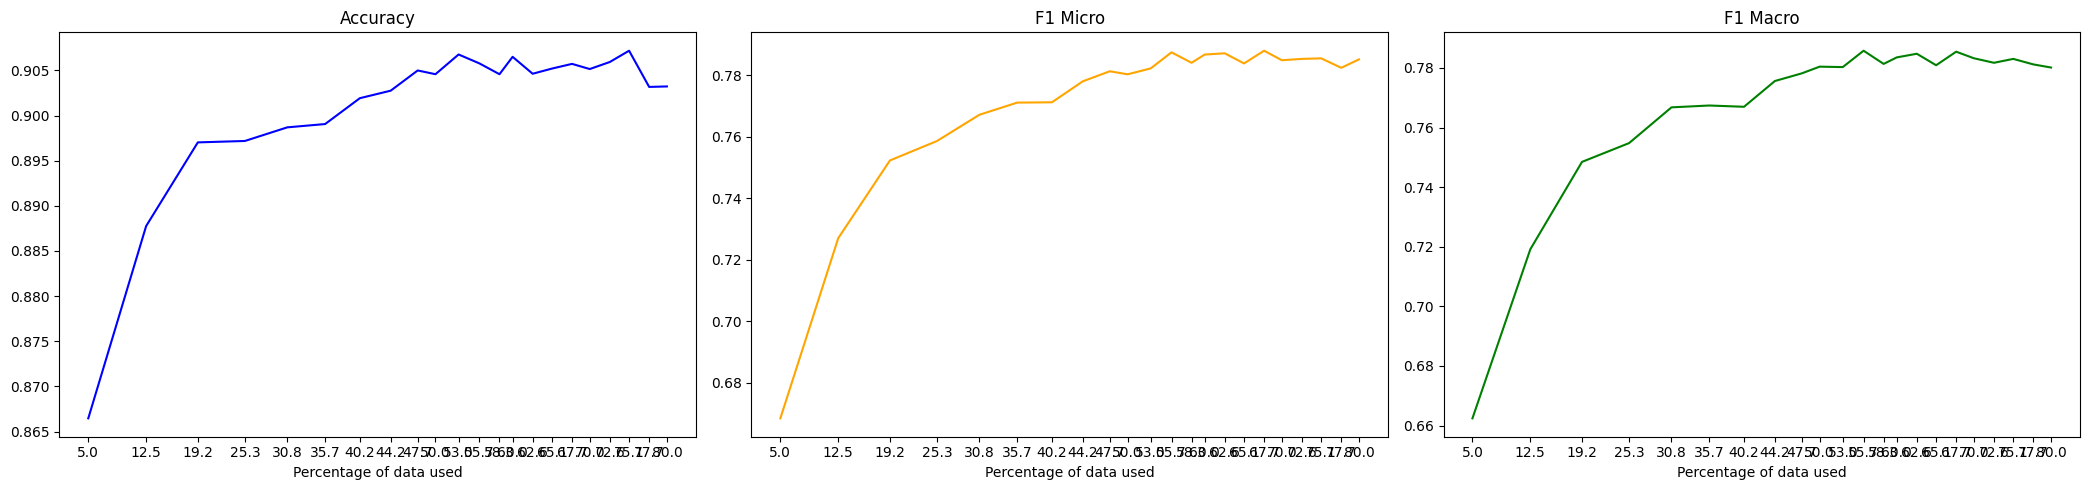

In [20]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: [3, 44, 85]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6311, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.461, Accuracy: 0.7878, F1 Micro: 0.0102, F1 Macro: 0.0093
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4762, Accuracy: 0.8163, F1 Micro: 0.2452, F1 Macro: 0.1696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3711, Accuracy: 0.8416, F1 Micro: 0.5034, F1 Macro: 0.4652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3263, Accuracy: 0.8502, F1 Micro: 0.5686, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.296, Accuracy: 0.8605, F1 Micro: 0.6162, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2432, Accuracy: 0.8637, F1 Micro: 0.6529, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1889, Accuracy: 0.867, F1 Micro: 0.664, F1 Macro: 0.6618
Epoch 9/10, Train Loss: 0.1726, Accuracy: 0.8648, F1 Micro: 0.6137

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6458, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4782, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4997, Accuracy: 0.8066, F1 Micro: 0.1702, F1 Macro: 0.128
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4081, Accuracy: 0.8309, F1 Micro: 0.3702, F1 Macro: 0.2912
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3573, Accuracy: 0.8436, F1 Micro: 0.4967, F1 Macro: 0.4694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3293, Accuracy: 0.8577, F1 Micro: 0.6068, F1 Macro: 0.5983
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2642, Accuracy: 0.8611, F1 Micro: 0.6176, F1 Macro: 0.6128
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2083, Accuracy: 0.865, F1 Micro: 0.6685, F1 Macro: 0.6627
Epoch 9/10, Train Loss: 0.1909, Accuracy: 0.8631, F1 Micro: 0.6131, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5999, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4533, Accuracy: 0.7878, F1 Micro: 0.0102, F1 Macro: 0.0093
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4549, Accuracy: 0.8241, F1 Micro: 0.3159, F1 Macro: 0.2124
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.366, Accuracy: 0.8339, F1 Micro: 0.4661, F1 Macro: 0.4318
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3339, Accuracy: 0.8428, F1 Micro: 0.4836, F1 Macro: 0.454
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3115, Accuracy: 0.8558, F1 Micro: 0.6071, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2574, Accuracy: 0.8616, F1 Micro: 0.6336, F1 Macro: 0.6331
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2035, Accuracy: 0.8645, F1 Micro: 0.6436, F1 Macro: 0.6384
Epoch 9/10, Train Loss: 0.1904, Accuracy: 0.865, F1 Micro: 0.623

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5937, Accuracy: 0.7894, F1 Micro: 0.0246, F1 Macro: 0.0215
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4733, Accuracy: 0.8487, F1 Micro: 0.5328, F1 Macro: 0.4934
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3931, Accuracy: 0.8637, F1 Micro: 0.6455, F1 Macro: 0.6399
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3312, Accuracy: 0.8752, F1 Micro: 0.7184, F1 Macro: 0.7167
Epoch 5/10, Train Loss: 0.2728, Accuracy: 0.8842, F1 Micro: 0.6977, F1 Macro: 0.688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2286, Accuracy: 0.89, F1 Micro: 0.7265, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1687, Accuracy: 0.8941, F1 Micro: 0.7426, F1 Macro: 0.7379
Epoch 8/10, Train Loss: 0.151, Accuracy: 0.8906, F1 Micro: 0.7131, F1 Macro: 0.7085
Epoch 9/10, Train Loss: 0.111, Accuracy: 0.8881, F1 Micro: 0.7131, F1 Macro: 0.709
Epoch 10/10, Train Loss: 0.0899, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.61, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5002, Accuracy: 0.8322, F1 Micro: 0.4073, F1 Macro: 0.3445
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.421, Accuracy: 0.8514, F1 Micro: 0.5675, F1 Macro: 0.4996
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3632, Accuracy: 0.8741, F1 Micro: 0.7024, F1 Macro: 0.6992
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2967, Accuracy: 0.8805, F1 Micro: 0.7125, F1 Macro: 0.7077
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2486, Accuracy: 0.8847, F1 Micro: 0.7207, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1833, Accuracy: 0.8902, F1 Micro: 0.7244, F1 Macro: 0.7187
Epoch 8/10, Train Loss: 0.1558, Accuracy: 0.8873, F1 Micro: 0.7022, F1 Macro: 0.6924
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1196, Accuracy: 0.8888, F1 Micro: 0.728

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5739, Accuracy: 0.7992, F1 Micro: 0.1217, F1 Macro: 0.0984
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.464, Accuracy: 0.8431, F1 Micro: 0.5049, F1 Macro: 0.4727
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3872, Accuracy: 0.8656, F1 Micro: 0.6614, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3329, Accuracy: 0.8753, F1 Micro: 0.7062, F1 Macro: 0.7019
Epoch 5/10, Train Loss: 0.2677, Accuracy: 0.8805, F1 Micro: 0.6929, F1 Macro: 0.675
Epoch 6/10, Train Loss: 0.2253, Accuracy: 0.8797, F1 Micro: 0.6883, F1 Macro: 0.6669
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1763, Accuracy: 0.8889, F1 Micro: 0.72, F1 Macro: 0.7135
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1378, Accuracy: 0.8884, F1 Micro: 0.7256, F1 Macro: 0.7218
Epoch 9/10, Train Loss: 0.1064, Accuracy: 0.8886, F1 Micro: 0.7218, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5762, Accuracy: 0.8322, F1 Micro: 0.3932, F1 Macro: 0.3282
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4189, Accuracy: 0.8586, F1 Micro: 0.5851, F1 Macro: 0.5648
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3479, Accuracy: 0.8827, F1 Micro: 0.7081, F1 Macro: 0.6957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2987, Accuracy: 0.8883, F1 Micro: 0.7442, F1 Macro: 0.7442
Epoch 5/10, Train Loss: 0.2403, Accuracy: 0.893, F1 Micro: 0.7263, F1 Macro: 0.716
Epoch 6/10, Train Loss: 0.1992, Accuracy: 0.895, F1 Micro: 0.7407, F1 Macro: 0.7372
Epoch 7/10, Train Loss: 0.1437, Accuracy: 0.893, F1 Micro: 0.7237, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1167, Accuracy: 0.8931, F1 Micro: 0.75, F1 Macro: 0.7464
Epoch 9/10, Train Loss: 0.0885, Accuracy: 0.8952, F1 Micro: 0.7434, F1 Macro: 0.7376
Epoch 10/10, Train Loss: 0.0726, Accuracy: 0.8959, F1 Micro: 0.7498, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5912, Accuracy: 0.8133, F1 Micro: 0.2975, F1 Macro: 0.2116
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4467, Accuracy: 0.8617, F1 Micro: 0.6026, F1 Macro: 0.5661
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3677, Accuracy: 0.8763, F1 Micro: 0.6806, F1 Macro: 0.6637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3074, Accuracy: 0.8902, F1 Micro: 0.7433, F1 Macro: 0.7429
Epoch 5/10, Train Loss: 0.2486, Accuracy: 0.8872, F1 Micro: 0.6982, F1 Macro: 0.6909
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1966, Accuracy: 0.8928, F1 Micro: 0.7482, F1 Macro: 0.746
Epoch 7/10, Train Loss: 0.1488, Accuracy: 0.8938, F1 Micro: 0.7391, F1 Macro: 0.7314
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1164, Accuracy: 0.8961, F1 Micro: 0.7512, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0856, Accuracy: 0.8955, F1 Micro: 0.7523, F1 Macro: 0.7493
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5615, Accuracy: 0.833, F1 Micro: 0.4335, F1 Macro: 0.3787
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4238, Accuracy: 0.8581, F1 Micro: 0.6232, F1 Macro: 0.613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3462, Accuracy: 0.8802, F1 Micro: 0.7102, F1 Macro: 0.7068
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2961, Accuracy: 0.8856, F1 Micro: 0.7367, F1 Macro: 0.7369
Epoch 5/10, Train Loss: 0.24, Accuracy: 0.8897, F1 Micro: 0.7229, F1 Macro: 0.7145
Epoch 6/10, Train Loss: 0.1941, Accuracy: 0.8916, F1 Micro: 0.7244, F1 Macro: 0.7174
Epoch 7/10, Train Loss: 0.1493, Accuracy: 0.8895, F1 Micro: 0.7207, F1 Macro: 0.708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1209, Accuracy: 0.8916, F1 Micro: 0.7449, F1 Macro: 0.7402
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0877, Accuracy: 0.8928, F1 Micro: 0.745, F1 Macro: 0.742
Epoch 10/10, Train Loss: 0.0722, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5352, Accuracy: 0.8522, F1 Micro: 0.6015, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3863, Accuracy: 0.8817, F1 Micro: 0.7193, F1 Macro: 0.7178
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.333, Accuracy: 0.89, F1 Micro: 0.7231, F1 Macro: 0.7235
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2766, Accuracy: 0.8922, F1 Micro: 0.7298, F1 Macro: 0.7312
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2283, Accuracy: 0.8963, F1 Micro: 0.7359, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1939, Accuracy: 0.9009, F1 Micro: 0.7556, F1 Macro: 0.7522
Epoch 7/10, Train Loss: 0.1402, Accuracy: 0.8995, F1 Micro: 0.7501, F1 Macro: 0.7475
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0999, Accuracy: 0.9002, F1 Micro: 0.7645, F1 Macro: 0.7613
Epoch 9/10, Train Loss: 0.0794, Accuracy: 0.9002, F1 Micro: 0.7549, F1 Macro: 0.7438
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5579, Accuracy: 0.8394, F1 Micro: 0.5519, F1 Macro: 0.4646
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4156, Accuracy: 0.8789, F1 Micro: 0.7189, F1 Macro: 0.716
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3473, Accuracy: 0.8872, F1 Micro: 0.7191, F1 Macro: 0.7214
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2879, Accuracy: 0.8903, F1 Micro: 0.729, F1 Macro: 0.7322
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2386, Accuracy: 0.8973, F1 Micro: 0.7371, F1 Macro: 0.7248
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1968, Accuracy: 0.897, F1 Micro: 0.7553, F1 Macro: 0.7572
Epoch 7/10, Train Loss: 0.1371, Accuracy: 0.8977, F1 Micro: 0.7424, F1 Macro: 0.7415
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1054, Accuracy: 0.9009, F1 Micro: 0.756, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.8995, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5235, Accuracy: 0.8556, F1 Micro: 0.6156, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3899, Accuracy: 0.8773, F1 Micro: 0.694, F1 Macro: 0.6891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3346, Accuracy: 0.8858, F1 Micro: 0.6976, F1 Macro: 0.6958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2746, Accuracy: 0.8908, F1 Micro: 0.7331, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2333, Accuracy: 0.8966, F1 Micro: 0.7462, F1 Macro: 0.7297
Epoch 6/10, Train Loss: 0.1898, Accuracy: 0.8966, F1 Micro: 0.7422, F1 Macro: 0.7351
Epoch 7/10, Train Loss: 0.1379, Accuracy: 0.8939, F1 Micro: 0.7296, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1067, Accuracy: 0.8955, F1 Micro: 0.7538, F1 Macro: 0.7512
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.8961, F1 Micro: 0.7486, F1 Macro: 0.7349
Epoch 10/10, Train Loss: 0.0667, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.524, Accuracy: 0.8708, F1 Micro: 0.6899, F1 Macro: 0.6798
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3814, Accuracy: 0.887, F1 Micro: 0.717, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3054, Accuracy: 0.8956, F1 Micro: 0.7585, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2457, Accuracy: 0.8997, F1 Micro: 0.7694, F1 Macro: 0.7669
Epoch 5/10, Train Loss: 0.2016, Accuracy: 0.9017, F1 Micro: 0.7627, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1514, Accuracy: 0.9028, F1 Micro: 0.7706, F1 Macro: 0.7652
Epoch 7/10, Train Loss: 0.1132, Accuracy: 0.9006, F1 Micro: 0.751, F1 Macro: 0.7456
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.9009, F1 Micro: 0.7661, F1 Macro: 0.7596
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9034, F1 Micro: 0.7641, F1 Macro: 0.7574
Epoch 10/10, Train Loss: 0.0597, Accuracy: 0.902, F1 Micro: 0.7679, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.546, Accuracy: 0.8547, F1 Micro: 0.6244, F1 Macro: 0.5909
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3945, Accuracy: 0.8853, F1 Micro: 0.6964, F1 Macro: 0.6917
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3121, Accuracy: 0.8958, F1 Micro: 0.7534, F1 Macro: 0.7514
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2566, Accuracy: 0.8964, F1 Micro: 0.7691, F1 Macro: 0.7685
Epoch 5/10, Train Loss: 0.2133, Accuracy: 0.9019, F1 Micro: 0.7681, F1 Macro: 0.7636
Epoch 6/10, Train Loss: 0.162, Accuracy: 0.9016, F1 Micro: 0.7672, F1 Macro: 0.7649
Epoch 7/10, Train Loss: 0.1277, Accuracy: 0.9, F1 Micro: 0.7557, F1 Macro: 0.7529
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.898, F1 Micro: 0.7665, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.8992, F1 Micro: 0.7666, F1 Macro: 0.7635
Epoch 10/10, Train Loss: 0.0599, Accuracy: 0.9047, F1 Micro: 0.7621, F1 Macro: 0.759
Model 2 - Iteration 2394:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5184, Accuracy: 0.8639, F1 Micro: 0.6384, F1 Macro: 0.6177
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3836, Accuracy: 0.8875, F1 Micro: 0.715, F1 Macro: 0.7108
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3052, Accuracy: 0.8952, F1 Micro: 0.74, F1 Macro: 0.7333
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2484, Accuracy: 0.8983, F1 Micro: 0.7604, F1 Macro: 0.7569
Epoch 5/10, Train Loss: 0.2007, Accuracy: 0.897, F1 Micro: 0.7425, F1 Macro: 0.7297
Epoch 6/10, Train Loss: 0.1514, Accuracy: 0.8977, F1 Micro: 0.7555, F1 Macro: 0.7516
Epoch 7/10, Train Loss: 0.1201, Accuracy: 0.8998, F1 Micro: 0.7578, F1 Macro: 0.7529
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9, F1 Micro: 0.757, F1 Macro: 0.7464
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.8981, F1 Micro: 0.7549, F1 Macro: 0.7438
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0569, Accuracy: 0.9017, F1 Micro: 0.7647, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.505, Accuracy: 0.8519, F1 Micro: 0.5241, F1 Macro: 0.486
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3712, Accuracy: 0.8908, F1 Micro: 0.742, F1 Macro: 0.7334
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3031, Accuracy: 0.8988, F1 Micro: 0.7596, F1 Macro: 0.757
Epoch 4/10, Train Loss: 0.2437, Accuracy: 0.902, F1 Micro: 0.7584, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1988, Accuracy: 0.9016, F1 Micro: 0.7692, F1 Macro: 0.7686
Epoch 6/10, Train Loss: 0.1613, Accuracy: 0.9009, F1 Micro: 0.7539, F1 Macro: 0.7544
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.9, F1 Micro: 0.7683, F1 Macro: 0.7667
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0935, Accuracy: 0.9013, F1 Micro: 0.7713, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.9011, F1 Micro: 0.7725, F1 Macro: 0.7717
Epoch 10/10, Train Loss: 0.0577, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.8422, F1 Micro: 0.4985, F1 Macro: 0.4211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3838, Accuracy: 0.8898, F1 Micro: 0.7353, F1 Macro: 0.7231
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3133, Accuracy: 0.8992, F1 Micro: 0.7643, F1 Macro: 0.7622
Epoch 4/10, Train Loss: 0.2487, Accuracy: 0.9019, F1 Micro: 0.7518, F1 Macro: 0.7446
Epoch 5/10, Train Loss: 0.2069, Accuracy: 0.8984, F1 Micro: 0.7603, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1593, Accuracy: 0.9039, F1 Micro: 0.7677, F1 Macro: 0.7639
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.9023, F1 Micro: 0.771, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.9019, F1 Micro: 0.7619, F1 Macro: 0.7553
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9003, F1 Micro: 0.767, F1 Macro: 0.7633
Epoch 10/10, Train Loss: 0.0513, Accuracy: 0.9008, F1 Micro: 0.7635, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5031, Accuracy: 0.8466, F1 Micro: 0.4901, F1 Macro: 0.4307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3792, Accuracy: 0.8886, F1 Micro: 0.7298, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3075, Accuracy: 0.8958, F1 Micro: 0.7516, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2445, Accuracy: 0.9008, F1 Micro: 0.7579, F1 Macro: 0.7503
Epoch 5/10, Train Loss: 0.1966, Accuracy: 0.8975, F1 Micro: 0.7539, F1 Macro: 0.7528
Epoch 6/10, Train Loss: 0.1563, Accuracy: 0.898, F1 Micro: 0.745, F1 Macro: 0.7437
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9031, F1 Micro: 0.777, F1 Macro: 0.7756
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9028, F1 Micro: 0.7656, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9, F1 Micro: 0.7681, F1 Macro: 0.7608
Epoch 10/10, Train Loss: 0.0528, Accuracy: 0.9011, F1 Micro: 0.7625, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.499, Accuracy: 0.8662, F1 Micro: 0.6403, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3421, Accuracy: 0.8906, F1 Micro: 0.731, F1 Macro: 0.7159
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2937, Accuracy: 0.9028, F1 Micro: 0.7746, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2402, Accuracy: 0.9053, F1 Micro: 0.7783, F1 Macro: 0.7727
Epoch 5/10, Train Loss: 0.2035, Accuracy: 0.9031, F1 Micro: 0.758, F1 Macro: 0.7495
Epoch 6/10, Train Loss: 0.1472, Accuracy: 0.9023, F1 Micro: 0.7715, F1 Macro: 0.7714
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9031, F1 Micro: 0.7612, F1 Macro: 0.7596
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9016, F1 Micro: 0.774, F1 Macro: 0.7726
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.9019, F1 Micro: 0.7728, F1 Macro: 0.7729
Epoch 10/10, Train Loss: 0.0535, Accuracy: 0.9039, F1 Micro: 0.7652, F1 Macro: 0.7608
Model 1 - Iteration 31

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5237, Accuracy: 0.8611, F1 Micro: 0.6026, F1 Macro: 0.5708
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3536, Accuracy: 0.8931, F1 Micro: 0.7339, F1 Macro: 0.7175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2986, Accuracy: 0.9031, F1 Micro: 0.7757, F1 Macro: 0.7723
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2443, Accuracy: 0.9038, F1 Micro: 0.7766, F1 Macro: 0.7757
Epoch 5/10, Train Loss: 0.205, Accuracy: 0.9028, F1 Micro: 0.7628, F1 Macro: 0.7552
Epoch 6/10, Train Loss: 0.1425, Accuracy: 0.897, F1 Micro: 0.7747, F1 Macro: 0.7764
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.8997, F1 Micro: 0.7538, F1 Macro: 0.7496
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9016, F1 Micro: 0.7579, F1 Macro: 0.7485
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.8998, F1 Micro: 0.7656, F1 Macro: 0.7649
Epoch 10/10, Train Loss: 0.0539, Accuracy: 0.9, F1 Micro: 0.7663, F1 Macro: 0.7649
Model 2 - Iteration 31

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4966, Accuracy: 0.8675, F1 Micro: 0.6287, F1 Macro: 0.6252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3433, Accuracy: 0.8917, F1 Micro: 0.7362, F1 Macro: 0.7229
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2936, Accuracy: 0.8994, F1 Micro: 0.7663, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2412, Accuracy: 0.9041, F1 Micro: 0.7774, F1 Macro: 0.7739
Epoch 5/10, Train Loss: 0.1961, Accuracy: 0.9003, F1 Micro: 0.7692, F1 Macro: 0.7622
Epoch 6/10, Train Loss: 0.1398, Accuracy: 0.8973, F1 Micro: 0.7622, F1 Macro: 0.7598
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9008, F1 Micro: 0.7566, F1 Macro: 0.7529
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.8991, F1 Micro: 0.7759, F1 Macro: 0.7766
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9009, F1 Micro: 0.7609, F1 Macro: 0.7549
Epoch 10/10, Train Loss: 0.0542, Accuracy: 0.8984, F1 Micro: 0.7635, F1 Macro: 0.7565
Model 3 - Iterati

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4802, Accuracy: 0.8675, F1 Micro: 0.6578, F1 Macro: 0.6412
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3312, Accuracy: 0.8933, F1 Micro: 0.7679, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.272, Accuracy: 0.9036, F1 Micro: 0.7687, F1 Macro: 0.7611
Epoch 4/10, Train Loss: 0.2284, Accuracy: 0.9031, F1 Micro: 0.752, F1 Macro: 0.7338
Epoch 5/10, Train Loss: 0.1915, Accuracy: 0.8995, F1 Micro: 0.7398, F1 Macro: 0.729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1417, Accuracy: 0.9019, F1 Micro: 0.7698, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9033, F1 Micro: 0.7622, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9086, F1 Micro: 0.7803, F1 Macro: 0.7804
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.903, F1 Micro: 0.7682, F1 Macro: 0.7634
Epoch 10/10, Train Loss: 0.051, Accuracy: 0.9053, F1 Micro: 0.768, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5022, Accuracy: 0.8627, F1 Micro: 0.6293, F1 Macro: 0.564
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3451, Accuracy: 0.8863, F1 Micro: 0.7607, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2821, Accuracy: 0.9033, F1 Micro: 0.7679, F1 Macro: 0.7612
Epoch 4/10, Train Loss: 0.234, Accuracy: 0.907, F1 Micro: 0.7679, F1 Macro: 0.7534
Epoch 5/10, Train Loss: 0.1929, Accuracy: 0.9047, F1 Micro: 0.7608, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1441, Accuracy: 0.9066, F1 Micro: 0.781, F1 Macro: 0.78
Epoch 7/10, Train Loss: 0.1062, Accuracy: 0.9047, F1 Micro: 0.7686, F1 Macro: 0.7594
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9052, F1 Micro: 0.7639, F1 Macro: 0.7594
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.9027, F1 Micro: 0.7784, F1 Macro: 0.7769
Epoch 10/10, Train Loss: 0.0504, Accuracy: 0.9048, F1 Micro: 0.7767, F1 Macro: 0.7765
Model 2 - Iteration 343

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4791, Accuracy: 0.8691, F1 Micro: 0.6485, F1 Macro: 0.6337
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.337, Accuracy: 0.8908, F1 Micro: 0.7589, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2705, Accuracy: 0.9005, F1 Micro: 0.7642, F1 Macro: 0.7561
Epoch 4/10, Train Loss: 0.228, Accuracy: 0.8972, F1 Micro: 0.7389, F1 Macro: 0.7247
Epoch 5/10, Train Loss: 0.1864, Accuracy: 0.8961, F1 Micro: 0.7278, F1 Macro: 0.7115
Epoch 6/10, Train Loss: 0.1447, Accuracy: 0.9, F1 Micro: 0.7581, F1 Macro: 0.7455
Epoch 7/10, Train Loss: 0.1131, Accuracy: 0.9013, F1 Micro: 0.7613, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9028, F1 Micro: 0.7648, F1 Macro: 0.7598
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9003, F1 Micro: 0.763, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0493, Accuracy: 0.9036, F1 Micro: 0.7722, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4786, Accuracy: 0.8692, F1 Micro: 0.6488, F1 Macro: 0.6364
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3273, Accuracy: 0.8931, F1 Micro: 0.7518, F1 Macro: 0.7451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2783, Accuracy: 0.9014, F1 Micro: 0.7625, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2323, Accuracy: 0.9045, F1 Micro: 0.7748, F1 Macro: 0.771
Epoch 5/10, Train Loss: 0.1847, Accuracy: 0.9066, F1 Micro: 0.773, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1389, Accuracy: 0.9058, F1 Micro: 0.7772, F1 Macro: 0.7749
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.903, F1 Micro: 0.7736, F1 Macro: 0.7709
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9048, F1 Micro: 0.7749, F1 Macro: 0.7682
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.9042, F1 Micro: 0.7737, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0468, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4974, Accuracy: 0.8609, F1 Micro: 0.586, F1 Macro: 0.538
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3355, Accuracy: 0.8919, F1 Micro: 0.7473, F1 Macro: 0.7377
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2829, Accuracy: 0.9027, F1 Micro: 0.768, F1 Macro: 0.7656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2369, Accuracy: 0.9025, F1 Micro: 0.7733, F1 Macro: 0.7714
Epoch 5/10, Train Loss: 0.1927, Accuracy: 0.9058, F1 Micro: 0.7703, F1 Macro: 0.7623
Epoch 6/10, Train Loss: 0.1387, Accuracy: 0.9014, F1 Micro: 0.7645, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1105, Accuracy: 0.8994, F1 Micro: 0.7775, F1 Macro: 0.779
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9008, F1 Micro: 0.7612, F1 Macro: 0.7535
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.8995, F1 Micro: 0.7698, F1 Macro: 0.7674
Epoch 10/10, Train Loss: 0.0503, Accuracy: 0.9044, F1 Micro: 0.7716, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.474, Accuracy: 0.8755, F1 Micro: 0.6604, F1 Macro: 0.6425
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3281, Accuracy: 0.8908, F1 Micro: 0.7483, F1 Macro: 0.7386
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2735, Accuracy: 0.8992, F1 Micro: 0.7572, F1 Macro: 0.7519
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2257, Accuracy: 0.9022, F1 Micro: 0.7704, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1803, Accuracy: 0.905, F1 Micro: 0.7731, F1 Macro: 0.7638
Epoch 6/10, Train Loss: 0.1382, Accuracy: 0.902, F1 Micro: 0.7611, F1 Macro: 0.7551
Epoch 7/10, Train Loss: 0.1042, Accuracy: 0.8994, F1 Micro: 0.7629, F1 Macro: 0.7535
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.8992, F1 Micro: 0.7569, F1 Macro: 0.7498
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.8988, F1 Micro: 0.7654, F1 Macro: 0.76
Epoch 10/10, Train Loss: 0.0483, Accuracy: 0.9027, F1 Micro: 0.7704, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4675, Accuracy: 0.8709, F1 Micro: 0.65, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3155, Accuracy: 0.8916, F1 Micro: 0.7086, F1 Macro: 0.687
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2633, Accuracy: 0.9036, F1 Micro: 0.777, F1 Macro: 0.7744
Epoch 4/10, Train Loss: 0.2094, Accuracy: 0.9045, F1 Micro: 0.7728, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.9064, F1 Micro: 0.7852, F1 Macro: 0.7833
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.9022, F1 Micro: 0.7652, F1 Macro: 0.7605
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.9019, F1 Micro: 0.7618, F1 Macro: 0.7554
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9011, F1 Micro: 0.7778, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.905, F1 Micro: 0.7751, F1 Macro: 0.7717
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.9013, F1 Micro: 0.7633, F1 Macro: 0.7585
Model 1 - Iteration 388

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4905, Accuracy: 0.8705, F1 Micro: 0.6626, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3309, Accuracy: 0.8892, F1 Micro: 0.6994, F1 Macro: 0.6752
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2726, Accuracy: 0.9027, F1 Micro: 0.7825, F1 Macro: 0.7804
Epoch 4/10, Train Loss: 0.221, Accuracy: 0.9044, F1 Micro: 0.7732, F1 Macro: 0.7674
Epoch 5/10, Train Loss: 0.1894, Accuracy: 0.9047, F1 Micro: 0.7798, F1 Macro: 0.7754
Epoch 6/10, Train Loss: 0.1311, Accuracy: 0.9023, F1 Micro: 0.7621, F1 Macro: 0.7541
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9006, F1 Micro: 0.7717, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.902, F1 Micro: 0.7721, F1 Macro: 0.767
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9022, F1 Micro: 0.7767, F1 Macro: 0.7749
Epoch 10/10, Train Loss: 0.0464, Accuracy: 0.9019, F1 Micro: 0.765, F1 Macro: 0.7572
Model 2 - Iteration 3886: Accuracy: 0.9027, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4634, Accuracy: 0.8702, F1 Micro: 0.6737, F1 Macro: 0.6762
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3192, Accuracy: 0.8952, F1 Micro: 0.7249, F1 Macro: 0.7041
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2569, Accuracy: 0.9016, F1 Micro: 0.7793, F1 Macro: 0.7738
Epoch 4/10, Train Loss: 0.2115, Accuracy: 0.9008, F1 Micro: 0.7547, F1 Macro: 0.7404
Epoch 5/10, Train Loss: 0.176, Accuracy: 0.9044, F1 Micro: 0.7691, F1 Macro: 0.7615
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.9003, F1 Micro: 0.7602, F1 Macro: 0.7516
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9009, F1 Micro: 0.7671, F1 Macro: 0.7569
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.8992, F1 Micro: 0.7709, F1 Macro: 0.7634
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9014, F1 Micro: 0.7678, F1 Macro: 0.7611
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0.9014, F1 Micro: 0.7667, F1 Macro: 0.7559
Model 3 - Iteration 3886: Accuracy: 0.9016, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4599, Accuracy: 0.8727, F1 Micro: 0.6667, F1 Macro: 0.6664
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3175, Accuracy: 0.8966, F1 Micro: 0.7394, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2671, Accuracy: 0.9014, F1 Micro: 0.7463, F1 Macro: 0.7303
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2249, Accuracy: 0.8983, F1 Micro: 0.7742, F1 Macro: 0.7734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1687, Accuracy: 0.9073, F1 Micro: 0.7862, F1 Macro: 0.7828
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9019, F1 Micro: 0.7686, F1 Macro: 0.7634
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9047, F1 Micro: 0.7749, F1 Macro: 0.7685
Epoch 8/10, Train Loss: 0.0716, Accuracy: 0.9044, F1 Micro: 0.7836, F1 Macro: 0.7828
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.908, F1 Micro: 0.7864, F1 Macro: 0.7839
Epoch 10/10, Train Loss: 0.0439, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4736, Accuracy: 0.8748, F1 Micro: 0.693, F1 Macro: 0.6954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.323, Accuracy: 0.8978, F1 Micro: 0.7419, F1 Macro: 0.7371
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2704, Accuracy: 0.9025, F1 Micro: 0.7532, F1 Macro: 0.7361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2242, Accuracy: 0.9002, F1 Micro: 0.7815, F1 Macro: 0.7815
Epoch 5/10, Train Loss: 0.1694, Accuracy: 0.9031, F1 Micro: 0.7685, F1 Macro: 0.7615
Epoch 6/10, Train Loss: 0.126, Accuracy: 0.9039, F1 Micro: 0.7682, F1 Macro: 0.7638
Epoch 7/10, Train Loss: 0.0936, Accuracy: 0.9034, F1 Micro: 0.7736, F1 Macro: 0.7687
Epoch 8/10, Train Loss: 0.0752, Accuracy: 0.9016, F1 Micro: 0.7745, F1 Macro: 0.7711
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.902, F1 Micro: 0.7689, F1 Macro: 0.7671
Epoch 10/10, Train Loss: 0.047, Accuracy: 0.9042, F1 Micro: 0.7775, F1 Macro: 0.7747
Model 2 - Iteration 41

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4555, Accuracy: 0.8686, F1 Micro: 0.6594, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.317, Accuracy: 0.8969, F1 Micro: 0.7454, F1 Macro: 0.7413
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2666, Accuracy: 0.8991, F1 Micro: 0.7467, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2207, Accuracy: 0.902, F1 Micro: 0.7836, F1 Macro: 0.7808
Epoch 5/10, Train Loss: 0.1684, Accuracy: 0.9006, F1 Micro: 0.7707, F1 Macro: 0.7642
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9047, F1 Micro: 0.7717, F1 Macro: 0.7665
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9061, F1 Micro: 0.7814, F1 Macro: 0.7764
Epoch 8/10, Train Loss: 0.0757, Accuracy: 0.9028, F1 Micro: 0.7672, F1 Macro: 0.7594
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9028, F1 Micro: 0.7771, F1 Macro: 0.776
Epoch 10/10, Train Loss: 0.05, Accuracy: 0.9038, F1 Micro: 0.7735, F1 Macro: 0.7686
Model 3 - Iteration 412

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4563, Accuracy: 0.8723, F1 Micro: 0.6636, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3039, Accuracy: 0.8997, F1 Micro: 0.7712, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2557, Accuracy: 0.9031, F1 Micro: 0.7745, F1 Macro: 0.7734
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2105, Accuracy: 0.9061, F1 Micro: 0.785, F1 Macro: 0.7828
Epoch 5/10, Train Loss: 0.1671, Accuracy: 0.9033, F1 Micro: 0.7718, F1 Macro: 0.7683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9067, F1 Micro: 0.7856, F1 Macro: 0.7859
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9053, F1 Micro: 0.7762, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9042, F1 Micro: 0.7788, F1 Macro: 0.7727
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9052, F1 Micro: 0.7776, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.0446, Accuracy: 0.903, F1 Micro: 0.7796, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4723, Accuracy: 0.87, F1 Micro: 0.6698, F1 Macro: 0.6652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3109, Accuracy: 0.8972, F1 Micro: 0.765, F1 Macro: 0.7631
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2582, Accuracy: 0.9003, F1 Micro: 0.7668, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.214, Accuracy: 0.9055, F1 Micro: 0.7828, F1 Macro: 0.781
Epoch 5/10, Train Loss: 0.1663, Accuracy: 0.9027, F1 Micro: 0.7681, F1 Macro: 0.7627
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.9033, F1 Micro: 0.7688, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.9036, F1 Micro: 0.7764, F1 Macro: 0.77
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9014, F1 Micro: 0.7703, F1 Macro: 0.765
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9008, F1 Micro: 0.768, F1 Macro: 0.7668
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.9008, F1 Micro: 0.7707, F1 Macro: 0.7668
Model 2 - Iteration 4330: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4535, Accuracy: 0.8658, F1 Micro: 0.6484, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3073, Accuracy: 0.897, F1 Micro: 0.7592, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2583, Accuracy: 0.9016, F1 Micro: 0.7667, F1 Macro: 0.7639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2129, Accuracy: 0.9039, F1 Micro: 0.7773, F1 Macro: 0.7696
Epoch 5/10, Train Loss: 0.165, Accuracy: 0.8981, F1 Micro: 0.7525, F1 Macro: 0.7431
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1357, Accuracy: 0.9067, F1 Micro: 0.7812, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9039, F1 Micro: 0.7815, F1 Macro: 0.7763
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9019, F1 Micro: 0.7776, F1 Macro: 0.7758
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9036, F1 Micro: 0.7732, F1 Macro: 0.7719
Epoch 10/10, Train Loss: 0.0456, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4383, Accuracy: 0.8773, F1 Micro: 0.6954, F1 Macro: 0.6869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3053, Accuracy: 0.8956, F1 Micro: 0.7668, F1 Macro: 0.7637
Epoch 3/10, Train Loss: 0.2593, Accuracy: 0.9016, F1 Micro: 0.7573, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2203, Accuracy: 0.9086, F1 Micro: 0.7782, F1 Macro: 0.7745
Epoch 5/10, Train Loss: 0.1741, Accuracy: 0.9003, F1 Micro: 0.767, F1 Macro: 0.7642
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9031, F1 Micro: 0.7765, F1 Macro: 0.7693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0957, Accuracy: 0.9058, F1 Micro: 0.779, F1 Macro: 0.7741
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9039, F1 Micro: 0.7781, F1 Macro: 0.7742
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9044, F1 Micro: 0.7698, F1 Macro: 0.7597
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.9025, F1 Micro: 0.7744, F1 Macro: 0.7677
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4569, Accuracy: 0.8686, F1 Micro: 0.6583, F1 Macro: 0.6309
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3164, Accuracy: 0.8956, F1 Micro: 0.763, F1 Macro: 0.7601
Epoch 3/10, Train Loss: 0.2596, Accuracy: 0.9028, F1 Micro: 0.7538, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2238, Accuracy: 0.9044, F1 Micro: 0.7666, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1702, Accuracy: 0.9033, F1 Micro: 0.7701, F1 Macro: 0.7656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.126, Accuracy: 0.9062, F1 Micro: 0.782, F1 Macro: 0.7747
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.9036, F1 Micro: 0.7796, F1 Macro: 0.7716
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9016, F1 Micro: 0.7745, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9042, F1 Micro: 0.7693, F1 Macro: 0.7617
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0406, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4366, Accuracy: 0.8712, F1 Micro: 0.6738, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3088, Accuracy: 0.8964, F1 Micro: 0.7689, F1 Macro: 0.7643
Epoch 3/10, Train Loss: 0.2569, Accuracy: 0.8994, F1 Micro: 0.7475, F1 Macro: 0.7362
Epoch 4/10, Train Loss: 0.2171, Accuracy: 0.9022, F1 Micro: 0.7623, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9, F1 Micro: 0.7756, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9019, F1 Micro: 0.7803, F1 Macro: 0.7736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9028, F1 Micro: 0.7848, F1 Macro: 0.7783
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9014, F1 Micro: 0.7739, F1 Macro: 0.7687
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9023, F1 Micro: 0.7701, F1 Macro: 0.7629
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.9036, F1 Micro: 0.7749, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4409, Accuracy: 0.8813, F1 Micro: 0.7008, F1 Macro: 0.6956
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3064, Accuracy: 0.9052, F1 Micro: 0.77, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2469, Accuracy: 0.9036, F1 Micro: 0.7754, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2056, Accuracy: 0.9056, F1 Micro: 0.7794, F1 Macro: 0.7734
Epoch 5/10, Train Loss: 0.156, Accuracy: 0.9023, F1 Micro: 0.7751, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9069, F1 Micro: 0.7855, F1 Macro: 0.7845
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.9083, F1 Micro: 0.7794, F1 Macro: 0.777
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9045, F1 Micro: 0.7736, F1 Macro: 0.7694
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9055, F1 Micro: 0.7679, F1 Macro: 0.7601
Epoch 10/10, Train Loss: 0.0442, Accuracy: 0.9066, F1 Micro: 0.7846, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.46, Accuracy: 0.8763, F1 Micro: 0.6806, F1 Macro: 0.669
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3151, Accuracy: 0.9, F1 Micro: 0.7581, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2494, Accuracy: 0.9039, F1 Micro: 0.7668, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2099, Accuracy: 0.9053, F1 Micro: 0.7804, F1 Macro: 0.7728
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.9045, F1 Micro: 0.7766, F1 Macro: 0.7725
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9058, F1 Micro: 0.7744, F1 Macro: 0.769
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9028, F1 Micro: 0.7701, F1 Macro: 0.7682
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.8995, F1 Micro: 0.7534, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9081, F1 Micro: 0.7851, F1 Macro: 0.7845
Epoch 10/10, Train Loss: 0.038, Accuracy: 0.9038, F1 Micro: 0.7734, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4369, Accuracy: 0.8841, F1 Micro: 0.714, F1 Macro: 0.6973
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3087, Accuracy: 0.8986, F1 Micro: 0.7507, F1 Macro: 0.745
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2447, Accuracy: 0.9011, F1 Micro: 0.7704, F1 Macro: 0.7658
Epoch 4/10, Train Loss: 0.2061, Accuracy: 0.9002, F1 Micro: 0.7697, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.9023, F1 Micro: 0.7761, F1 Macro: 0.7708
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.9027, F1 Micro: 0.7673, F1 Macro: 0.7613
Epoch 7/10, Train Loss: 0.0933, Accuracy: 0.9009, F1 Micro: 0.7731, F1 Macro: 0.7708
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.9033, F1 Micro: 0.7712, F1 Macro: 0.7675
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9033, F1 Micro: 0.7742, F1 Macro: 0.769
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.8998, F1 Micro: 0.7829, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4261, Accuracy: 0.8791, F1 Micro: 0.6762, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2893, Accuracy: 0.9003, F1 Micro: 0.7768, F1 Macro: 0.7733
Epoch 3/10, Train Loss: 0.2387, Accuracy: 0.9016, F1 Micro: 0.7543, F1 Macro: 0.7455
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.9086, F1 Micro: 0.7797, F1 Macro: 0.7738
Epoch 5/10, Train Loss: 0.1622, Accuracy: 0.9062, F1 Micro: 0.7746, F1 Macro: 0.7639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.9087, F1 Micro: 0.7819, F1 Macro: 0.7795
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9045, F1 Micro: 0.7837, F1 Macro: 0.7829
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9059, F1 Micro: 0.778, F1 Macro: 0.7726
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9067, F1 Micro: 0.7762, F1 Macro: 0.775
Epoch 10/10, Train Loss: 0.0419, Accuracy: 0.9048, F1 Micro: 0.7826, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4429, Accuracy: 0.8831, F1 Micro: 0.7145, F1 Macro: 0.7132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2964, Accuracy: 0.8983, F1 Micro: 0.7732, F1 Macro: 0.7691
Epoch 3/10, Train Loss: 0.2432, Accuracy: 0.8994, F1 Micro: 0.7457, F1 Macro: 0.7379
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2028, Accuracy: 0.9059, F1 Micro: 0.7739, F1 Macro: 0.7683
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.9025, F1 Micro: 0.7629, F1 Macro: 0.7564
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9036, F1 Micro: 0.7734, F1 Macro: 0.7686
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.9056, F1 Micro: 0.7691, F1 Macro: 0.7599
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.9022, F1 Micro: 0.7707, F1 Macro: 0.7644
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9025, F1 Micro: 0.7703, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0424, Accuracy: 0.9031, F1 Micro: 0.7787, F1 Macro: 0.7739
Model 2 - Iterati

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4245, Accuracy: 0.8866, F1 Micro: 0.7307, F1 Macro: 0.7259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2925, Accuracy: 0.8983, F1 Micro: 0.772, F1 Macro: 0.766
Epoch 3/10, Train Loss: 0.2371, Accuracy: 0.9034, F1 Micro: 0.7595, F1 Macro: 0.7497
Epoch 4/10, Train Loss: 0.1994, Accuracy: 0.9034, F1 Micro: 0.7625, F1 Macro: 0.7549
Epoch 5/10, Train Loss: 0.1612, Accuracy: 0.9039, F1 Micro: 0.7713, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9041, F1 Micro: 0.7771, F1 Macro: 0.7723
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9045, F1 Micro: 0.7756, F1 Macro: 0.7695
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.902, F1 Micro: 0.7718, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.905, F1 Micro: 0.7778, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.9022, F1 Micro: 0.7822, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4174, Accuracy: 0.8827, F1 Micro: 0.6911, F1 Macro: 0.668
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2867, Accuracy: 0.8989, F1 Micro: 0.7619, F1 Macro: 0.7496
Epoch 3/10, Train Loss: 0.2339, Accuracy: 0.9033, F1 Micro: 0.7605, F1 Macro: 0.7538
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1904, Accuracy: 0.9002, F1 Micro: 0.773, F1 Macro: 0.7698
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.903, F1 Micro: 0.7696, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.9053, F1 Micro: 0.7777, F1 Macro: 0.7715
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9036, F1 Micro: 0.7752, F1 Macro: 0.7725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9034, F1 Micro: 0.7833, F1 Macro: 0.7794
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.9045, F1 Micro: 0.7793, F1 Macro: 0.776
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.9025, F1 Micro: 0.7685, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4299, Accuracy: 0.8834, F1 Micro: 0.6907, F1 Macro: 0.6714
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2923, Accuracy: 0.897, F1 Micro: 0.7627, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2374, Accuracy: 0.9053, F1 Micro: 0.7671, F1 Macro: 0.7608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1898, Accuracy: 0.9031, F1 Micro: 0.7763, F1 Macro: 0.7721
Epoch 5/10, Train Loss: 0.1506, Accuracy: 0.9058, F1 Micro: 0.7751, F1 Macro: 0.7709
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9064, F1 Micro: 0.7715, F1 Macro: 0.7633
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9045, F1 Micro: 0.7702, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9067, F1 Micro: 0.7816, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9033, F1 Micro: 0.7821, F1 Macro: 0.7805
Epoch 10/10, Train Loss: 0.0385, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4161, Accuracy: 0.8814, F1 Micro: 0.6841, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2898, Accuracy: 0.898, F1 Micro: 0.7672, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2376, Accuracy: 0.9044, F1 Micro: 0.7691, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1898, Accuracy: 0.9017, F1 Micro: 0.7786, F1 Macro: 0.7718
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.9041, F1 Micro: 0.7726, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9014, F1 Micro: 0.779, F1 Macro: 0.7747
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.902, F1 Micro: 0.7736, F1 Macro: 0.7735
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9058, F1 Micro: 0.772, F1 Macro: 0.7622
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9056, F1 Micro: 0.7753, F1 Macro: 0.7721
Epoch 10/10, Train Loss: 0.0381, Accuracy: 0.9039, F1 Micro: 0.7785, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4064, Accuracy: 0.8722, F1 Micro: 0.6396, F1 Macro: 0.6186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2814, Accuracy: 0.8975, F1 Micro: 0.7411, F1 Macro: 0.7201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2336, Accuracy: 0.9075, F1 Micro: 0.7811, F1 Macro: 0.7684
Epoch 4/10, Train Loss: 0.1844, Accuracy: 0.9062, F1 Micro: 0.776, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9031, F1 Micro: 0.7834, F1 Macro: 0.7813
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9058, F1 Micro: 0.7696, F1 Macro: 0.7567
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9019, F1 Micro: 0.7793, F1 Macro: 0.7787
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9036, F1 Micro: 0.7816, F1 Macro: 0.7803
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9059, F1 Micro: 0.778, F1 Macro: 0.7744
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.9045, F1 Micro: 0.7812, F1 Macro: 0.779
Model 1 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4209, Accuracy: 0.8719, F1 Micro: 0.6339, F1 Macro: 0.6092
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.285, Accuracy: 0.8964, F1 Micro: 0.7393, F1 Macro: 0.7184
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2351, Accuracy: 0.9066, F1 Micro: 0.7805, F1 Macro: 0.7702
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9062, F1 Micro: 0.7734, F1 Macro: 0.766
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.9003, F1 Micro: 0.7769, F1 Macro: 0.7694
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9038, F1 Micro: 0.7781, F1 Macro: 0.7705
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9033, F1 Micro: 0.774, F1 Macro: 0.7714
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9053, F1 Micro: 0.7742, F1 Macro: 0.7678
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9041, F1 Micro: 0.7721, F1 Macro: 0.7633
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.9027, F1 Micro: 0.7793, F1 Macro: 0.7765
Model 2 - Iteration 5263: Accuracy: 0.9066, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4075, Accuracy: 0.8784, F1 Micro: 0.6641, F1 Macro: 0.6422
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2783, Accuracy: 0.8995, F1 Micro: 0.752, F1 Macro: 0.7371
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2299, Accuracy: 0.9034, F1 Micro: 0.7723, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.9052, F1 Micro: 0.7785, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1443, Accuracy: 0.8995, F1 Micro: 0.7793, F1 Macro: 0.7756
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.903, F1 Micro: 0.7754, F1 Macro: 0.7649
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9009, F1 Micro: 0.7745, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.905, F1 Micro: 0.7825, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.9048, F1 Micro: 0.7739, F1 Macro: 0.7692
Epoch 10/10, Train Loss: 0.0346, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3965, Accuracy: 0.8873, F1 Micro: 0.7428, F1 Macro: 0.74
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2685, Accuracy: 0.8981, F1 Micro: 0.7564, F1 Macro: 0.7408
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2243, Accuracy: 0.8998, F1 Micro: 0.7803, F1 Macro: 0.7795
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9019, F1 Micro: 0.7657, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.9087, F1 Micro: 0.7895, F1 Macro: 0.7853
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9038, F1 Micro: 0.7713, F1 Macro: 0.7607
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9013, F1 Micro: 0.7693, F1 Macro: 0.7597
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.8967, F1 Micro: 0.7754, F1 Macro: 0.7718
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.8992, F1 Micro: 0.7766, F1 Macro: 0.7735
Epoch 10/10, Train Loss: 0.0362, Accuracy: 0.8981, F1 Micro: 0.7766, F1 Macro: 0.7752
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4136, Accuracy: 0.8839, F1 Micro: 0.7253, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2748, Accuracy: 0.9023, F1 Micro: 0.7677, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.226, Accuracy: 0.8967, F1 Micro: 0.7783, F1 Macro: 0.7783
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9016, F1 Micro: 0.7651, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9041, F1 Micro: 0.7824, F1 Macro: 0.7789
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9031, F1 Micro: 0.7688, F1 Macro: 0.7592
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.8933, F1 Micro: 0.7742, F1 Macro: 0.7795
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9042, F1 Micro: 0.778, F1 Macro: 0.7736
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9017, F1 Micro: 0.7788, F1 Macro: 0.7757
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0.9042, F1 Micro: 0.7819, F1 Macro: 0.7794
Model 2 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3978, Accuracy: 0.8852, F1 Micro: 0.7334, F1 Macro: 0.7306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.269, Accuracy: 0.898, F1 Micro: 0.7529, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2235, Accuracy: 0.898, F1 Micro: 0.7781, F1 Macro: 0.7783
Epoch 4/10, Train Loss: 0.1776, Accuracy: 0.9014, F1 Micro: 0.757, F1 Macro: 0.7461
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9062, F1 Micro: 0.7848, F1 Macro: 0.7808
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9014, F1 Micro: 0.7689, F1 Macro: 0.7578
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9013, F1 Micro: 0.7746, F1 Macro: 0.7708
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9017, F1 Micro: 0.7812, F1 Macro: 0.7778
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.9038, F1 Micro: 0.78, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.0355, Accuracy: 0.9016, F1 Micro: 0.7831, F1 Macro: 0.7821
Model 3 - Iteration 544

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3961, Accuracy: 0.8916, F1 Micro: 0.7463, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.9011, F1 Micro: 0.7699, F1 Macro: 0.769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9064, F1 Micro: 0.7807, F1 Macro: 0.774
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9066, F1 Micro: 0.7792, F1 Macro: 0.7743
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9019, F1 Micro: 0.7705, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9058, F1 Micro: 0.787, F1 Macro: 0.7846
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9034, F1 Micro: 0.7785, F1 Macro: 0.7761
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9025, F1 Micro: 0.7776, F1 Macro: 0.7768
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9036, F1 Micro: 0.7759, F1 Macro: 0.7709
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9, F1 Micro: 0.7778, F1 Macro: 0.7773
Model 1 - Iteration 564

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4159, Accuracy: 0.8898, F1 Micro: 0.7443, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.9033, F1 Micro: 0.7663, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.9059, F1 Micro: 0.7811, F1 Macro: 0.7743
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.903, F1 Micro: 0.7756, F1 Macro: 0.7708
Epoch 5/10, Train Loss: 0.1314, Accuracy: 0.9, F1 Micro: 0.7686, F1 Macro: 0.7656
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.8973, F1 Micro: 0.7689, F1 Macro: 0.7668
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9013, F1 Micro: 0.774, F1 Macro: 0.7707
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9006, F1 Micro: 0.7749, F1 Macro: 0.7707
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9028, F1 Micro: 0.7761, F1 Macro: 0.7739
Epoch 10/10, Train Loss: 0.0375, Accuracy: 0.8998, F1 Micro: 0.7734, F1 Macro: 0.7706
Model 2 - Iteration 5641: Accuracy: 0.9059, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3974, Accuracy: 0.8894, F1 Micro: 0.7376, F1 Macro: 0.7257
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.9028, F1 Micro: 0.7715, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9045, F1 Micro: 0.7755, F1 Macro: 0.7699
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9003, F1 Micro: 0.7665, F1 Macro: 0.7637
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.9009, F1 Micro: 0.7671, F1 Macro: 0.7633
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.9031, F1 Micro: 0.7704, F1 Macro: 0.7641
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.9016, F1 Micro: 0.7752, F1 Macro: 0.7748
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.902, F1 Micro: 0.7732, F1 Macro: 0.7684
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9023, F1 Micro: 0.7689, F1 Macro: 0.7625
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.902, F1 Micro: 0.7685, F1 Macro: 0.7628
Model 3 - Iteration 5641: Accuracy: 0.9045, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3751, Accuracy: 0.8909, F1 Micro: 0.7471, F1 Macro: 0.7431
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2504, Accuracy: 0.9, F1 Micro: 0.7668, F1 Macro: 0.7584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.9061, F1 Micro: 0.779, F1 Macro: 0.7752
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.9048, F1 Micro: 0.7732, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9052, F1 Micro: 0.7838, F1 Macro: 0.781
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.9044, F1 Micro: 0.777, F1 Macro: 0.7718
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9047, F1 Micro: 0.7766, F1 Macro: 0.7728
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9002, F1 Micro: 0.776, F1 Macro: 0.7746
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9066, F1 Micro: 0.783, F1 Macro: 0.7804
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.9067, F1 Micro: 0.7755, F1 Macro: 0.7678
Model 1 - Iteration 5841:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3954, Accuracy: 0.8909, F1 Micro: 0.7413, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2558, Accuracy: 0.9013, F1 Micro: 0.7693, F1 Macro: 0.7614
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.9036, F1 Micro: 0.7596, F1 Macro: 0.7437
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9084, F1 Micro: 0.7813, F1 Macro: 0.7721
Epoch 5/10, Train Loss: 0.1335, Accuracy: 0.9014, F1 Micro: 0.7746, F1 Macro: 0.77
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9041, F1 Micro: 0.7801, F1 Macro: 0.7795
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9045, F1 Micro: 0.7826, F1 Macro: 0.7785
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.8995, F1 Micro: 0.7791, F1 Macro: 0.7784
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9022, F1 Micro: 0.7641, F1 Macro: 0.7589
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9047, F1 Micro: 0.7764, F1 Macro: 0.7682
Model 2 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.378, Accuracy: 0.8898, F1 Micro: 0.7465, F1 Macro: 0.7407
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2528, Accuracy: 0.9008, F1 Micro: 0.7623, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2085, Accuracy: 0.9044, F1 Micro: 0.7646, F1 Macro: 0.7499
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9027, F1 Micro: 0.7669, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1278, Accuracy: 0.9025, F1 Micro: 0.7752, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9039, F1 Micro: 0.7792, F1 Macro: 0.7769
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9017, F1 Micro: 0.7784, F1 Macro: 0.7756
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9005, F1 Micro: 0.7721, F1 Macro: 0.7709
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9058, F1 Micro: 0.7789, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3674, Accuracy: 0.8898, F1 Micro: 0.7322, F1 Macro: 0.7233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.9013, F1 Micro: 0.7636, F1 Macro: 0.7599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.192, Accuracy: 0.9044, F1 Micro: 0.7684, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9073, F1 Micro: 0.7755, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9045, F1 Micro: 0.7785, F1 Macro: 0.7764
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.897, F1 Micro: 0.7727, F1 Macro: 0.7726
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.9025, F1 Micro: 0.7741, F1 Macro: 0.7677
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9058, F1 Micro: 0.7763, F1 Macro: 0.7751
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9034, F1 Micro: 0.7733, F1 Macro: 0.7713
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0286, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3835, Accuracy: 0.892, F1 Micro: 0.7298, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.9013, F1 Micro: 0.7619, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.9061, F1 Micro: 0.7709, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9064, F1 Micro: 0.7749, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9009, F1 Micro: 0.7786, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.8966, F1 Micro: 0.7802, F1 Macro: 0.7802
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9061, F1 Micro: 0.7731, F1 Macro: 0.7615
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9053, F1 Micro: 0.777, F1 Macro: 0.7729
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9045, F1 Micro: 0.7759, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3687, Accuracy: 0.8909, F1 Micro: 0.7366, F1 Macro: 0.7315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2413, Accuracy: 0.8975, F1 Micro: 0.7517, F1 Macro: 0.7397
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9056, F1 Micro: 0.7721, F1 Macro: 0.7592
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.9047, F1 Micro: 0.7661, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1194, Accuracy: 0.9019, F1 Micro: 0.7821, F1 Macro: 0.7783
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.8992, F1 Micro: 0.7789, F1 Macro: 0.7772
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9031, F1 Micro: 0.7757, F1 Macro: 0.7702
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9056, F1 Micro: 0.7763, F1 Macro: 0.7698
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9036, F1 Micro: 0.7729, F1 Macro: 0.7728
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9006, F1 Micro: 0.7709, F1 Macro: 0.7718
Model 3 - Iterati

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3608, Accuracy: 0.8923, F1 Micro: 0.7426, F1 Macro: 0.7379
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2314, Accuracy: 0.8994, F1 Micro: 0.7799, F1 Macro: 0.7779
Epoch 3/10, Train Loss: 0.1955, Accuracy: 0.9044, F1 Micro: 0.7701, F1 Macro: 0.7604
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9036, F1 Micro: 0.7631, F1 Macro: 0.7514
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9036, F1 Micro: 0.7794, F1 Macro: 0.7779
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.8973, F1 Micro: 0.7763, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9069, F1 Micro: 0.7823, F1 Macro: 0.7824
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9019, F1 Micro: 0.7743, F1 Macro: 0.7691
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9039, F1 Micro: 0.7803, F1 Macro: 0.779
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9042, F1 Micro: 0.7715, F1 Macro: 0.7646
Model 1 - Iteration 6218: Accuracy: 0.9069, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3791, Accuracy: 0.8911, F1 Micro: 0.7272, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.9009, F1 Micro: 0.7826, F1 Macro: 0.7788
Epoch 3/10, Train Loss: 0.1984, Accuracy: 0.9047, F1 Micro: 0.77, F1 Macro: 0.7586
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9022, F1 Micro: 0.7627, F1 Macro: 0.7545
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.9031, F1 Micro: 0.775, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.9031, F1 Micro: 0.7869, F1 Macro: 0.7865
Epoch 7/10, Train Loss: 0.0607, Accuracy: 0.903, F1 Micro: 0.7607, F1 Macro: 0.7546
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.8992, F1 Micro: 0.776, F1 Macro: 0.7739
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9011, F1 Micro: 0.7656, F1 Macro: 0.7534
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9042, F1 Micro: 0.7725, F1 Macro: 0.7687
Model 2 - Iteration 6218: Accuracy: 0.9031, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3589, Accuracy: 0.8908, F1 Micro: 0.7357, F1 Macro: 0.7297
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2316, Accuracy: 0.9006, F1 Micro: 0.7805, F1 Macro: 0.7767
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.9056, F1 Micro: 0.7743, F1 Macro: 0.7632
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9016, F1 Micro: 0.7658, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9034, F1 Micro: 0.7838, F1 Macro: 0.7826
Epoch 6/10, Train Loss: 0.0825, Accuracy: 0.9003, F1 Micro: 0.778, F1 Macro: 0.7762
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.902, F1 Micro: 0.7684, F1 Macro: 0.7652
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.9033, F1 Micro: 0.7763, F1 Macro: 0.773
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.902, F1 Micro: 0.7724, F1 Macro: 0.7671
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9036, F1 Micro: 0.7699, F1 Macro: 0.7654
Model 3 - Iteration 6218: Accuracy: 0.9034, F1 Micro: 0

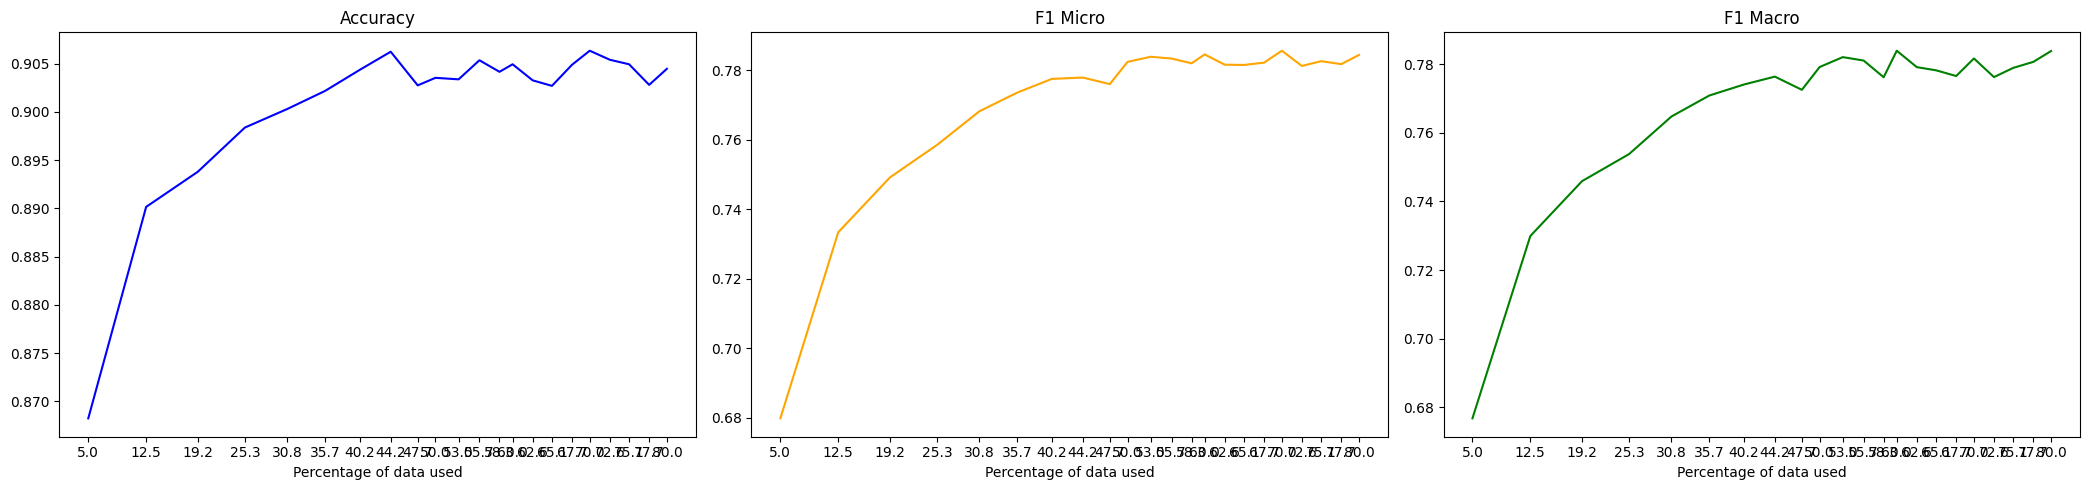

In [21]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: [94, 21, 5]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5781, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.432, Accuracy: 0.788, F1 Micro: 0.0117, F1 Macro: 0.0106
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3729, Accuracy: 0.8223, F1 Micro: 0.2889, F1 Macro: 0.2126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3601, Accuracy: 0.83, F1 Micro: 0.3747, F1 Macro: 0.2926
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2934, Accuracy: 0.8384, F1 Micro: 0.4405, F1 Macro: 0.3659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2592, Accuracy: 0.8566, F1 Micro: 0.5816, F1 Macro: 0.5611
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2344, Accuracy: 0.8592, F1 Micro: 0.588, F1 Macro: 0.5698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1829, Accuracy: 0.8694, F1 Micro: 0.6384, F1 Macro: 0.6256
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1544, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5897, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4473, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3959, Accuracy: 0.8066, F1 Micro: 0.1702, F1 Macro: 0.1278
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3926, Accuracy: 0.8258, F1 Micro: 0.3197, F1 Macro: 0.2231
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3251, Accuracy: 0.8391, F1 Micro: 0.4372, F1 Macro: 0.3627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2762, Accuracy: 0.8562, F1 Micro: 0.5611, F1 Macro: 0.5364
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2538, Accuracy: 0.8605, F1 Micro: 0.6061, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1942, Accuracy: 0.8698, F1 Micro: 0.6481, F1 Macro: 0.6419
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1598, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5583, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.43, Accuracy: 0.7978, F1 Micro: 0.0989, F1 Macro: 0.0805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.363, Accuracy: 0.8225, F1 Micro: 0.2996, F1 Macro: 0.2036
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3502, Accuracy: 0.8367, F1 Micro: 0.4397, F1 Macro: 0.3464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2882, Accuracy: 0.85, F1 Micro: 0.5289, F1 Macro: 0.4943
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.24, Accuracy: 0.857, F1 Micro: 0.6037, F1 Macro: 0.5962
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2211, Accuracy: 0.8647, F1 Micro: 0.6264, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1673, Accuracy: 0.867, F1 Micro: 0.6352, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1339, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5575, Accuracy: 0.7958, F1 Micro: 0.0828, F1 Macro: 0.0737
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4423, Accuracy: 0.8475, F1 Micro: 0.5091, F1 Macro: 0.4617
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3578, Accuracy: 0.8702, F1 Micro: 0.6648, F1 Macro: 0.6615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2758, Accuracy: 0.8834, F1 Micro: 0.6985, F1 Macro: 0.6901
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2386, Accuracy: 0.8875, F1 Micro: 0.7134, F1 Macro: 0.7092
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1877, Accuracy: 0.8925, F1 Micro: 0.7308, F1 Macro: 0.7267
Epoch 7/10, Train Loss: 0.154, Accuracy: 0.8873, F1 Micro: 0.6969, F1 Macro: 0.6879
Epoch 8/10, Train Loss: 0.1202, Accuracy: 0.8928, F1 Micro: 0.7258, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.096, Accuracy: 0.8931, F1 Micro: 0.7423, F1 Macro: 0.7362
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.573, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4758, Accuracy: 0.8481, F1 Micro: 0.5277, F1 Macro: 0.4819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3721, Accuracy: 0.8672, F1 Micro: 0.6499, F1 Macro: 0.6471
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2872, Accuracy: 0.8714, F1 Micro: 0.652, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2455, Accuracy: 0.8883, F1 Micro: 0.7257, F1 Macro: 0.7242
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.196, Accuracy: 0.8922, F1 Micro: 0.7307, F1 Macro: 0.7319
Epoch 7/10, Train Loss: 0.1587, Accuracy: 0.8859, F1 Micro: 0.688, F1 Macro: 0.6792
Epoch 8/10, Train Loss: 0.1265, Accuracy: 0.8927, F1 Micro: 0.7167, F1 Macro: 0.7081
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1027, Accuracy: 0.8916, F1 Micro: 0.7592, F1 Macro: 0.7591
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.547, Accuracy: 0.8027, F1 Micro: 0.1483, F1 Macro: 0.1163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4348, Accuracy: 0.8486, F1 Micro: 0.5138, F1 Macro: 0.4671
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3483, Accuracy: 0.8686, F1 Micro: 0.6651, F1 Macro: 0.665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2683, Accuracy: 0.8794, F1 Micro: 0.6737, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2288, Accuracy: 0.8913, F1 Micro: 0.7358, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1835, Accuracy: 0.8928, F1 Micro: 0.7417, F1 Macro: 0.7376
Epoch 7/10, Train Loss: 0.1429, Accuracy: 0.8911, F1 Micro: 0.7152, F1 Macro: 0.7076
Epoch 8/10, Train Loss: 0.1163, Accuracy: 0.8902, F1 Micro: 0.7191, F1 Macro: 0.7134
Epoch 9/10, Train Loss: 0.0864, Accuracy: 0.8928, F1 Micro: 0.7347, F1 Macro: 0.7306
Epoch 10/10, Train Loss: 0.0708, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5394, Accuracy: 0.8317, F1 Micro: 0.5656, F1 Macro: 0.4912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.414, Accuracy: 0.8719, F1 Micro: 0.6787, F1 Macro: 0.6666
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3398, Accuracy: 0.8872, F1 Micro: 0.7171, F1 Macro: 0.7108
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2692, Accuracy: 0.8927, F1 Micro: 0.7418, F1 Macro: 0.7283
Epoch 5/10, Train Loss: 0.2252, Accuracy: 0.8917, F1 Micro: 0.7216, F1 Macro: 0.7107
Epoch 6/10, Train Loss: 0.1623, Accuracy: 0.8919, F1 Micro: 0.7159, F1 Macro: 0.7076
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1366, Accuracy: 0.8936, F1 Micro: 0.7445, F1 Macro: 0.7376
Epoch 8/10, Train Loss: 0.1056, Accuracy: 0.8919, F1 Micro: 0.7387, F1 Macro: 0.7309
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.8936, F1 Micro: 0.7537, F1 Macro: 0.7524
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5581, Accuracy: 0.8173, F1 Micro: 0.4099, F1 Macro: 0.2864
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4279, Accuracy: 0.8712, F1 Micro: 0.6831, F1 Macro: 0.6772
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.343, Accuracy: 0.8873, F1 Micro: 0.7193, F1 Macro: 0.7103
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2701, Accuracy: 0.892, F1 Micro: 0.7263, F1 Macro: 0.71
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.232, Accuracy: 0.8928, F1 Micro: 0.7293, F1 Macro: 0.7215
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1692, Accuracy: 0.8944, F1 Micro: 0.7414, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1267, Accuracy: 0.8955, F1 Micro: 0.7514, F1 Macro: 0.7447
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1006, Accuracy: 0.8958, F1 Micro: 0.7629, F1 Macro: 0.7578
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.8972, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5241, Accuracy: 0.8391, F1 Micro: 0.5893, F1 Macro: 0.5101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4103, Accuracy: 0.8716, F1 Micro: 0.6851, F1 Macro: 0.6855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3338, Accuracy: 0.8897, F1 Micro: 0.728, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2571, Accuracy: 0.8922, F1 Micro: 0.7292, F1 Macro: 0.7079
Epoch 5/10, Train Loss: 0.2208, Accuracy: 0.8902, F1 Micro: 0.7155, F1 Macro: 0.7075
Epoch 6/10, Train Loss: 0.1571, Accuracy: 0.893, F1 Micro: 0.7237, F1 Macro: 0.7099
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.136, Accuracy: 0.8973, F1 Micro: 0.7488, F1 Macro: 0.7451
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.895, F1 Micro: 0.7419, F1 Macro: 0.7377
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.8923, F1 Micro: 0.7387, F1 Macro: 0.7367
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0572, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5279, Accuracy: 0.8464, F1 Micro: 0.561, F1 Macro: 0.5281
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3901, Accuracy: 0.8841, F1 Micro: 0.7252, F1 Macro: 0.716
Epoch 3/10, Train Loss: 0.3189, Accuracy: 0.8895, F1 Micro: 0.7157, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2754, Accuracy: 0.8945, F1 Micro: 0.7452, F1 Macro: 0.7386
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2179, Accuracy: 0.8944, F1 Micro: 0.761, F1 Macro: 0.7629
Epoch 6/10, Train Loss: 0.1724, Accuracy: 0.8958, F1 Micro: 0.7484, F1 Macro: 0.7421
Epoch 7/10, Train Loss: 0.1273, Accuracy: 0.8988, F1 Micro: 0.7538, F1 Macro: 0.7499
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.8956, F1 Micro: 0.7289, F1 Macro: 0.7196
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.8983, F1 Micro: 0.7581, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0562, Accuracy: 0.8991, F1 Micro: 0.7695, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5462, Accuracy: 0.85, F1 Micro: 0.5652, F1 Macro: 0.5225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3977, Accuracy: 0.8791, F1 Micro: 0.7068, F1 Macro: 0.7077
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3163, Accuracy: 0.8941, F1 Micro: 0.732, F1 Macro: 0.7305
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2715, Accuracy: 0.8983, F1 Micro: 0.7559, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2152, Accuracy: 0.8945, F1 Micro: 0.7716, F1 Macro: 0.7727
Epoch 6/10, Train Loss: 0.1709, Accuracy: 0.8994, F1 Micro: 0.7588, F1 Macro: 0.7543
Epoch 7/10, Train Loss: 0.1269, Accuracy: 0.9003, F1 Micro: 0.7572, F1 Macro: 0.7538
Epoch 8/10, Train Loss: 0.0999, Accuracy: 0.8986, F1 Micro: 0.729, F1 Macro: 0.7194
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9017, F1 Micro: 0.7643, F1 Macro: 0.7612
Epoch 10/10, Train Loss: 0.0546, Accuracy: 0.9005, F1 Micro: 0.7688, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5162, Accuracy: 0.8508, F1 Micro: 0.6003, F1 Macro: 0.5422
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.384, Accuracy: 0.8852, F1 Micro: 0.7318, F1 Macro: 0.7233
Epoch 3/10, Train Loss: 0.3064, Accuracy: 0.8909, F1 Micro: 0.7208, F1 Macro: 0.7199
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2659, Accuracy: 0.8964, F1 Micro: 0.7529, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2071, Accuracy: 0.8948, F1 Micro: 0.7654, F1 Macro: 0.7656
Epoch 6/10, Train Loss: 0.1672, Accuracy: 0.8947, F1 Micro: 0.7601, F1 Macro: 0.7575
Epoch 7/10, Train Loss: 0.1265, Accuracy: 0.8995, F1 Micro: 0.7556, F1 Macro: 0.7477
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.8953, F1 Micro: 0.7296, F1 Macro: 0.7231
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.8963, F1 Micro: 0.7456, F1 Macro: 0.7416
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0567, Accuracy: 0.8981, F1 Micro: 0.7655, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5175, Accuracy: 0.8503, F1 Micro: 0.5186, F1 Macro: 0.4454
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3761, Accuracy: 0.8853, F1 Micro: 0.7228, F1 Macro: 0.7213
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3108, Accuracy: 0.8925, F1 Micro: 0.7394, F1 Macro: 0.7364
Epoch 4/10, Train Loss: 0.2559, Accuracy: 0.8891, F1 Micro: 0.6921, F1 Macro: 0.6594
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2138, Accuracy: 0.9009, F1 Micro: 0.7617, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1602, Accuracy: 0.902, F1 Micro: 0.7691, F1 Macro: 0.7683
Epoch 7/10, Train Loss: 0.1168, Accuracy: 0.897, F1 Micro: 0.7674, F1 Macro: 0.7675
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9019, F1 Micro: 0.7683, F1 Macro: 0.7668
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.8992, F1 Micro: 0.7687, F1 Macro: 0.7693
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0578, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5332, Accuracy: 0.8511, F1 Micro: 0.5468, F1 Macro: 0.4921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3791, Accuracy: 0.8853, F1 Micro: 0.7213, F1 Macro: 0.7176
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3111, Accuracy: 0.8986, F1 Micro: 0.7556, F1 Macro: 0.7525
Epoch 4/10, Train Loss: 0.2566, Accuracy: 0.8941, F1 Micro: 0.7065, F1 Macro: 0.682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2074, Accuracy: 0.9034, F1 Micro: 0.7586, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1632, Accuracy: 0.9038, F1 Micro: 0.7763, F1 Macro: 0.7737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.123, Accuracy: 0.9052, F1 Micro: 0.7795, F1 Macro: 0.7762
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.902, F1 Micro: 0.7765, F1 Macro: 0.7757
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9019, F1 Micro: 0.7585, F1 Macro: 0.7559
Epoch 10/10, Train Loss: 0.0551, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5099, Accuracy: 0.8508, F1 Micro: 0.5279, F1 Macro: 0.4579
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3693, Accuracy: 0.89, F1 Micro: 0.7335, F1 Macro: 0.7296
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3037, Accuracy: 0.898, F1 Micro: 0.7586, F1 Macro: 0.7567
Epoch 4/10, Train Loss: 0.2505, Accuracy: 0.8922, F1 Micro: 0.7064, F1 Macro: 0.681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2109, Accuracy: 0.9038, F1 Micro: 0.766, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1616, Accuracy: 0.903, F1 Micro: 0.7754, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1174, Accuracy: 0.8981, F1 Micro: 0.7763, F1 Macro: 0.7797
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.8986, F1 Micro: 0.7735, F1 Macro: 0.776
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9022, F1 Micro: 0.7618, F1 Macro: 0.7607
Epoch 10/10, Train Loss: 0.0534, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4913, Accuracy: 0.86, F1 Micro: 0.5931, F1 Macro: 0.543
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3599, Accuracy: 0.8917, F1 Micro: 0.754, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2849, Accuracy: 0.8977, F1 Micro: 0.7586, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2317, Accuracy: 0.9017, F1 Micro: 0.7702, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1941, Accuracy: 0.9033, F1 Micro: 0.7774, F1 Macro: 0.7735
Epoch 6/10, Train Loss: 0.1456, Accuracy: 0.902, F1 Micro: 0.7684, F1 Macro: 0.7681
Epoch 7/10, Train Loss: 0.1079, Accuracy: 0.8966, F1 Micro: 0.7768, F1 Macro: 0.7767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9019, F1 Micro: 0.7816, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9017, F1 Micro: 0.7719, F1 Macro: 0.769
Epoch 10/10, Train Loss: 0.0516, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5044, Accuracy: 0.8634, F1 Micro: 0.6074, F1 Macro: 0.5868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3607, Accuracy: 0.8903, F1 Micro: 0.7438, F1 Macro: 0.7437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2834, Accuracy: 0.8994, F1 Micro: 0.7692, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2337, Accuracy: 0.902, F1 Micro: 0.7762, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1953, Accuracy: 0.9052, F1 Micro: 0.7811, F1 Macro: 0.7795
Epoch 6/10, Train Loss: 0.1517, Accuracy: 0.9055, F1 Micro: 0.7725, F1 Macro: 0.769
Epoch 7/10, Train Loss: 0.1075, Accuracy: 0.9006, F1 Micro: 0.7746, F1 Macro: 0.7724
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.9038, F1 Micro: 0.7805, F1 Macro: 0.7777
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9005, F1 Micro: 0.7636, F1 Macro: 0.7571
Epoch 10/10, Train Loss: 0.0459, Accuracy: 0.9031, F1 Micro: 0.7688, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4814, Accuracy: 0.8656, F1 Micro: 0.6248, F1 Macro: 0.5889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.356, Accuracy: 0.8942, F1 Micro: 0.7559, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2806, Accuracy: 0.8991, F1 Micro: 0.7688, F1 Macro: 0.7663
Epoch 4/10, Train Loss: 0.2321, Accuracy: 0.902, F1 Micro: 0.7631, F1 Macro: 0.7595
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1887, Accuracy: 0.9038, F1 Micro: 0.7808, F1 Macro: 0.7814
Epoch 6/10, Train Loss: 0.1404, Accuracy: 0.9039, F1 Micro: 0.7685, F1 Macro: 0.7678
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9005, F1 Micro: 0.7792, F1 Macro: 0.7808
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9019, F1 Micro: 0.7743, F1 Macro: 0.7697
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.9019, F1 Micro: 0.7736, F1 Macro: 0.7709
Epoch 10/10, Train Loss: 0.0502, Accuracy: 0.9031, F1 Micro: 0.7707, F1 Macro: 0.7667
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4821, Accuracy: 0.8545, F1 Micro: 0.5871, F1 Macro: 0.5574
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3462, Accuracy: 0.8925, F1 Micro: 0.7516, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2823, Accuracy: 0.8977, F1 Micro: 0.7631, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.236, Accuracy: 0.8967, F1 Micro: 0.7739, F1 Macro: 0.7747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.208, Accuracy: 0.9047, F1 Micro: 0.7809, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1484, Accuracy: 0.9064, F1 Micro: 0.7816, F1 Macro: 0.7802
Epoch 7/10, Train Loss: 0.1146, Accuracy: 0.9017, F1 Micro: 0.7789, F1 Macro: 0.7806
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.9022, F1 Micro: 0.7654, F1 Macro: 0.7668
Epoch 9/10, Train Loss: 0.0682, Accuracy: 0.9009, F1 Micro: 0.7529, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.492, Accuracy: 0.8637, F1 Micro: 0.6179, F1 Macro: 0.587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.342, Accuracy: 0.8916, F1 Micro: 0.7465, F1 Macro: 0.7457
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2773, Accuracy: 0.9011, F1 Micro: 0.7722, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2353, Accuracy: 0.9042, F1 Micro: 0.7819, F1 Macro: 0.7821
Epoch 5/10, Train Loss: 0.19, Accuracy: 0.9042, F1 Micro: 0.7724, F1 Macro: 0.7702
Epoch 6/10, Train Loss: 0.143, Accuracy: 0.9052, F1 Micro: 0.7719, F1 Macro: 0.7639
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.8977, F1 Micro: 0.7773, F1 Macro: 0.7791
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9042, F1 Micro: 0.7691, F1 Macro: 0.7683
Epoch 9/10, Train Loss: 0.0663, Accuracy: 0.9031, F1 Micro: 0.7606, F1 Macro: 0.7553
Epoch 10/10, Train Loss: 0.0524, Accuracy: 0.9036, F1 Micro: 0.7747, F1 Macro: 0.7708
Model 2 - Iteration 312

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4731, Accuracy: 0.8642, F1 Micro: 0.6405, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3395, Accuracy: 0.8942, F1 Micro: 0.7501, F1 Macro: 0.7488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2777, Accuracy: 0.9, F1 Micro: 0.7676, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2271, Accuracy: 0.8986, F1 Micro: 0.7764, F1 Macro: 0.7757
Epoch 5/10, Train Loss: 0.1936, Accuracy: 0.9052, F1 Micro: 0.7736, F1 Macro: 0.7703
Epoch 6/10, Train Loss: 0.1428, Accuracy: 0.905, F1 Micro: 0.7755, F1 Macro: 0.7751
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9041, F1 Micro: 0.7744, F1 Macro: 0.7719
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.9042, F1 Micro: 0.7661, F1 Macro: 0.7669
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9023, F1 Micro: 0.7649, F1 Macro: 0.7611
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0565, Accuracy: 0.9016, F1 Micro: 0.7768, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4682, Accuracy: 0.8586, F1 Micro: 0.5869, F1 Macro: 0.5427
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3321, Accuracy: 0.893, F1 Micro: 0.7317, F1 Macro: 0.7237
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2738, Accuracy: 0.9003, F1 Micro: 0.7721, F1 Macro: 0.766
Epoch 4/10, Train Loss: 0.2345, Accuracy: 0.9005, F1 Micro: 0.7679, F1 Macro: 0.7584
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1796, Accuracy: 0.9064, F1 Micro: 0.784, F1 Macro: 0.7838
Epoch 6/10, Train Loss: 0.134, Accuracy: 0.9034, F1 Micro: 0.7689, F1 Macro: 0.7634
Epoch 7/10, Train Loss: 0.103, Accuracy: 0.9023, F1 Micro: 0.7601, F1 Macro: 0.7544
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9022, F1 Micro: 0.7683, F1 Macro: 0.7638
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9002, F1 Micro: 0.7704, F1 Macro: 0.7692
Epoch 10/10, Train Loss: 0.0471, Accuracy: 0.9006, F1 Micro: 0.758, F1 Macro: 0.7543
Model 1 - Iteration 343

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.478, Accuracy: 0.8597, F1 Micro: 0.5929, F1 Macro: 0.5519
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3318, Accuracy: 0.8966, F1 Micro: 0.746, F1 Macro: 0.7404
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2726, Accuracy: 0.9011, F1 Micro: 0.7689, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2319, Accuracy: 0.9008, F1 Micro: 0.7728, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.181, Accuracy: 0.9039, F1 Micro: 0.7743, F1 Macro: 0.7742
Epoch 6/10, Train Loss: 0.1355, Accuracy: 0.9005, F1 Micro: 0.7597, F1 Macro: 0.7527
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9041, F1 Micro: 0.7669, F1 Macro: 0.7615
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9047, F1 Micro: 0.7652, F1 Macro: 0.7596
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9003, F1 Micro: 0.7788, F1 Macro: 0.7793
Epoch 10/10, Train Loss: 0.0461, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4605, Accuracy: 0.8691, F1 Micro: 0.6272, F1 Macro: 0.5988
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3278, Accuracy: 0.8934, F1 Micro: 0.7263, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2665, Accuracy: 0.9023, F1 Micro: 0.772, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2272, Accuracy: 0.9056, F1 Micro: 0.7843, F1 Macro: 0.7794
Epoch 5/10, Train Loss: 0.1801, Accuracy: 0.905, F1 Micro: 0.7819, F1 Macro: 0.7832
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9055, F1 Micro: 0.7752, F1 Macro: 0.7723
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9038, F1 Micro: 0.7677, F1 Macro: 0.7669
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9039, F1 Micro: 0.7604, F1 Macro: 0.7538
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.9052, F1 Micro: 0.7806, F1 Macro: 0.7822
Epoch 10/10, Train Loss: 0.0501, Accuracy: 0.9036, F1 Micro: 0.7817, F1 Macro: 0.7818
Model 3 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4632, Accuracy: 0.8813, F1 Micro: 0.6979, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3368, Accuracy: 0.8911, F1 Micro: 0.731, F1 Macro: 0.7127
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2759, Accuracy: 0.9006, F1 Micro: 0.7589, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.228, Accuracy: 0.9086, F1 Micro: 0.7844, F1 Macro: 0.7808
Epoch 5/10, Train Loss: 0.1754, Accuracy: 0.9042, F1 Micro: 0.7742, F1 Macro: 0.7723
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.8981, F1 Micro: 0.7411, F1 Macro: 0.727
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.9028, F1 Micro: 0.7771, F1 Macro: 0.7762
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9016, F1 Micro: 0.7539, F1 Macro: 0.7517
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9041, F1 Micro: 0.7841, F1 Macro: 0.7839
Epoch 10/10, Train Loss: 0.0499, Accuracy: 0.9047, F1 Micro: 0.7686, F1 Macro: 0.7662
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.476, Accuracy: 0.8686, F1 Micro: 0.6509, F1 Macro: 0.6408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.338, Accuracy: 0.8931, F1 Micro: 0.7334, F1 Macro: 0.7092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2769, Accuracy: 0.903, F1 Micro: 0.7697, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2264, Accuracy: 0.9055, F1 Micro: 0.7704, F1 Macro: 0.7632
Epoch 5/10, Train Loss: 0.1781, Accuracy: 0.9023, F1 Micro: 0.756, F1 Macro: 0.7498
Epoch 6/10, Train Loss: 0.1377, Accuracy: 0.9019, F1 Micro: 0.7653, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1033, Accuracy: 0.9045, F1 Micro: 0.7748, F1 Macro: 0.7712
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9025, F1 Micro: 0.7701, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9033, F1 Micro: 0.7748, F1 Macro: 0.7689
Epoch 10/10, Train Loss: 0.0487, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4567, Accuracy: 0.8817, F1 Micro: 0.7014, F1 Macro: 0.6984
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3369, Accuracy: 0.8952, F1 Micro: 0.7386, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2745, Accuracy: 0.9033, F1 Micro: 0.772, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.224, Accuracy: 0.9067, F1 Micro: 0.7775, F1 Macro: 0.771
Epoch 5/10, Train Loss: 0.1787, Accuracy: 0.9045, F1 Micro: 0.7729, F1 Macro: 0.7709
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.902, F1 Micro: 0.7604, F1 Macro: 0.752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1083, Accuracy: 0.9013, F1 Micro: 0.7781, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9038, F1 Micro: 0.7809, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9059, F1 Micro: 0.7792, F1 Macro: 0.7766
Epoch 10/10, Train Loss: 0.0489, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4597, Accuracy: 0.8802, F1 Micro: 0.7323, F1 Macro: 0.7317
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.324, Accuracy: 0.8939, F1 Micro: 0.7603, F1 Macro: 0.7621
Epoch 3/10, Train Loss: 0.2649, Accuracy: 0.9008, F1 Micro: 0.7449, F1 Macro: 0.7332
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2208, Accuracy: 0.9016, F1 Micro: 0.7811, F1 Macro: 0.7794
Epoch 5/10, Train Loss: 0.1726, Accuracy: 0.8984, F1 Micro: 0.776, F1 Macro: 0.7755
Epoch 6/10, Train Loss: 0.1326, Accuracy: 0.9033, F1 Micro: 0.7745, F1 Macro: 0.7712
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9025, F1 Micro: 0.7659, F1 Macro: 0.759
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9022, F1 Micro: 0.7767, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9062, F1 Micro: 0.7753, F1 Macro: 0.7683
Epoch 10/10, Train Loss: 0.0463, Accuracy: 0.9039, F1 Micro: 0.7689, F1 Macro: 0.7621
Model 1 - Iteration 3886: Accuracy: 0.9016, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4734, Accuracy: 0.8755, F1 Micro: 0.7101, F1 Macro: 0.7139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3231, Accuracy: 0.8983, F1 Micro: 0.7652, F1 Macro: 0.7652
Epoch 3/10, Train Loss: 0.2641, Accuracy: 0.9013, F1 Micro: 0.7462, F1 Macro: 0.737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2205, Accuracy: 0.9017, F1 Micro: 0.7798, F1 Macro: 0.7793
Epoch 5/10, Train Loss: 0.1703, Accuracy: 0.9008, F1 Micro: 0.7793, F1 Macro: 0.7766
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9013, F1 Micro: 0.7752, F1 Macro: 0.7744
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9045, F1 Micro: 0.7678, F1 Macro: 0.7617
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9041, F1 Micro: 0.7787, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9048, F1 Micro: 0.7728, F1 Macro: 0.7669
Epoch 10/10, Train Loss: 0.0446, Accuracy: 0.9036, F1 Micro: 0.7671, F1 Macro: 0.7642
Model 2 - Iteration 3886: Accuracy: 0.9017, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4533, Accuracy: 0.8747, F1 Micro: 0.7142, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3212, Accuracy: 0.8964, F1 Micro: 0.7673, F1 Macro: 0.7671
Epoch 3/10, Train Loss: 0.2627, Accuracy: 0.905, F1 Micro: 0.7669, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2207, Accuracy: 0.8986, F1 Micro: 0.7816, F1 Macro: 0.782
Epoch 5/10, Train Loss: 0.1729, Accuracy: 0.898, F1 Micro: 0.7808, F1 Macro: 0.7816
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9019, F1 Micro: 0.7773, F1 Macro: 0.7753
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.9028, F1 Micro: 0.7688, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0771, Accuracy: 0.9041, F1 Micro: 0.7832, F1 Macro: 0.7808
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.907, F1 Micro: 0.7792, F1 Macro: 0.7812
Epoch 10/10, Train Loss: 0.0462, Accuracy: 0.9034, F1 Micro: 0.7779, F1 Macro: 0.7761
Model 3 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4512, Accuracy: 0.8736, F1 Micro: 0.6625, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3197, Accuracy: 0.8966, F1 Micro: 0.7563, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2565, Accuracy: 0.9002, F1 Micro: 0.7584, F1 Macro: 0.7548
Epoch 4/10, Train Loss: 0.2212, Accuracy: 0.9014, F1 Micro: 0.7553, F1 Macro: 0.7429
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1681, Accuracy: 0.9019, F1 Micro: 0.7653, F1 Macro: 0.7604
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9028, F1 Micro: 0.757, F1 Macro: 0.7463
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.9039, F1 Micro: 0.768, F1 Macro: 0.7629
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9027, F1 Micro: 0.7652, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9028, F1 Micro: 0.7698, F1 Macro: 0.7641
Epoch 10/10, Train Loss: 0.043, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4663, Accuracy: 0.8761, F1 Micro: 0.6722, F1 Macro: 0.6676
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3178, Accuracy: 0.9023, F1 Micro: 0.7681, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2535, Accuracy: 0.9038, F1 Micro: 0.7717, F1 Macro: 0.7684
Epoch 4/10, Train Loss: 0.2165, Accuracy: 0.903, F1 Micro: 0.7656, F1 Macro: 0.7582
Epoch 5/10, Train Loss: 0.1674, Accuracy: 0.9019, F1 Micro: 0.7684, F1 Macro: 0.7674
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.9053, F1 Micro: 0.7676, F1 Macro: 0.7609
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.9058, F1 Micro: 0.7678, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9025, F1 Micro: 0.7718, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.903, F1 Micro: 0.7761, F1 Macro: 0.7705
Epoch 10/10, Train Loss: 0.0427, Accuracy: 0.9016, F1 Micro: 0.7682, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4448, Accuracy: 0.8806, F1 Micro: 0.6859, F1 Macro: 0.6834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3159, Accuracy: 0.8992, F1 Micro: 0.7619, F1 Macro: 0.7523
Epoch 3/10, Train Loss: 0.2541, Accuracy: 0.903, F1 Micro: 0.7592, F1 Macro: 0.7544
Epoch 4/10, Train Loss: 0.2164, Accuracy: 0.903, F1 Micro: 0.7618, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1694, Accuracy: 0.9023, F1 Micro: 0.7696, F1 Macro: 0.7654
Epoch 6/10, Train Loss: 0.134, Accuracy: 0.9036, F1 Micro: 0.7593, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.9039, F1 Micro: 0.7748, F1 Macro: 0.7743
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.8978, F1 Micro: 0.7606, F1 Macro: 0.7558
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9019, F1 Micro: 0.7771, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.9016, F1 Micro: 0.7724, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4421, Accuracy: 0.8825, F1 Micro: 0.6905, F1 Macro: 0.672
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3057, Accuracy: 0.8972, F1 Micro: 0.7496, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2677, Accuracy: 0.9038, F1 Micro: 0.7663, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2123, Accuracy: 0.9013, F1 Micro: 0.7775, F1 Macro: 0.7755
Epoch 5/10, Train Loss: 0.172, Accuracy: 0.9003, F1 Micro: 0.7752, F1 Macro: 0.771
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9048, F1 Micro: 0.7624, F1 Macro: 0.7523
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.8995, F1 Micro: 0.7647, F1 Macro: 0.7624
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9039, F1 Micro: 0.7723, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9055, F1 Micro: 0.7788, F1 Macro: 0.7751
Epoch 10/10, Train Loss: 0.0453, Accuracy: 0.9033, F1 Micro: 0.7733, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4511, Accuracy: 0.8697, F1 Micro: 0.6345, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3064, Accuracy: 0.8994, F1 Micro: 0.7527, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2679, Accuracy: 0.9058, F1 Micro: 0.7747, F1 Macro: 0.7695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.21, Accuracy: 0.9038, F1 Micro: 0.7809, F1 Macro: 0.7776
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.9041, F1 Micro: 0.781, F1 Macro: 0.7771
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.9025, F1 Micro: 0.7679, F1 Macro: 0.7624
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9031, F1 Micro: 0.77, F1 Macro: 0.7665
Epoch 8/10, Train Loss: 0.0633, Accuracy: 0.905, F1 Micro: 0.7786, F1 Macro: 0.7758
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9017, F1 Micro: 0.7693, F1 Macro: 0.763
Epoch 10/10, Train Loss: 0.0472, Accuracy: 0.9013, F1 Micro: 0.7676, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4352, Accuracy: 0.8784, F1 Micro: 0.6734, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3025, Accuracy: 0.9, F1 Micro: 0.7517, F1 Macro: 0.7397
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2625, Accuracy: 0.9059, F1 Micro: 0.7759, F1 Macro: 0.7682
Epoch 4/10, Train Loss: 0.2103, Accuracy: 0.9036, F1 Micro: 0.7721, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9031, F1 Micro: 0.7843, F1 Macro: 0.7819
Epoch 6/10, Train Loss: 0.1239, Accuracy: 0.9019, F1 Micro: 0.759, F1 Macro: 0.7512
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9045, F1 Micro: 0.7829, F1 Macro: 0.7828
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.9023, F1 Micro: 0.7784, F1 Macro: 0.7779
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9047, F1 Micro: 0.7665, F1 Macro: 0.7625
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0.902, F1 Micro: 0.7637, F1 Macro: 0.7567
Model 3 - Iteration 43

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4362, Accuracy: 0.8838, F1 Micro: 0.6946, F1 Macro: 0.6796
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3027, Accuracy: 0.8984, F1 Micro: 0.7455, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2567, Accuracy: 0.9008, F1 Micro: 0.7588, F1 Macro: 0.7406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2048, Accuracy: 0.902, F1 Micro: 0.7846, F1 Macro: 0.7812
Epoch 5/10, Train Loss: 0.1643, Accuracy: 0.9025, F1 Micro: 0.7708, F1 Macro: 0.7655
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9041, F1 Micro: 0.7777, F1 Macro: 0.7701
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.9047, F1 Micro: 0.7774, F1 Macro: 0.7728
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9058, F1 Micro: 0.7651, F1 Macro: 0.7544
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9062, F1 Micro: 0.7791, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.9044, F1 Micro: 0.7763, F1 Macro: 0.7705
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4449, Accuracy: 0.8808, F1 Micro: 0.6905, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3028, Accuracy: 0.8998, F1 Micro: 0.7491, F1 Macro: 0.7413
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2587, Accuracy: 0.9056, F1 Micro: 0.7698, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.206, Accuracy: 0.9066, F1 Micro: 0.7873, F1 Macro: 0.7819
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.9031, F1 Micro: 0.7752, F1 Macro: 0.7723
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.903, F1 Micro: 0.7731, F1 Macro: 0.7649
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.902, F1 Micro: 0.7685, F1 Macro: 0.7619
Epoch 8/10, Train Loss: 0.0686, Accuracy: 0.8977, F1 Micro: 0.7593, F1 Macro: 0.7538
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9042, F1 Micro: 0.7847, F1 Macro: 0.7822
Epoch 10/10, Train Loss: 0.0393, Accuracy: 0.9028, F1 Micro: 0.7735, F1 Macro: 0.7671
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4287, Accuracy: 0.883, F1 Micro: 0.6878, F1 Macro: 0.67
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2995, Accuracy: 0.9002, F1 Micro: 0.7505, F1 Macro: 0.7428
Epoch 3/10, Train Loss: 0.2608, Accuracy: 0.9008, F1 Micro: 0.7497, F1 Macro: 0.7354
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2051, Accuracy: 0.9038, F1 Micro: 0.7808, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1685, Accuracy: 0.9016, F1 Micro: 0.7853, F1 Macro: 0.7843
Epoch 6/10, Train Loss: 0.1237, Accuracy: 0.9066, F1 Micro: 0.7779, F1 Macro: 0.7727
Epoch 7/10, Train Loss: 0.089, Accuracy: 0.9034, F1 Micro: 0.7746, F1 Macro: 0.7694
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9016, F1 Micro: 0.7748, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9044, F1 Micro: 0.7789, F1 Macro: 0.7804
Epoch 10/10, Train Loss: 0.0407, Accuracy: 0.8992, F1 Micro: 0.773, F1 Macro: 0.7722
Model 3 - Iteration 45

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4224, Accuracy: 0.8834, F1 Micro: 0.7208, F1 Macro: 0.7178
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2918, Accuracy: 0.9011, F1 Micro: 0.7572, F1 Macro: 0.7452
Epoch 3/10, Train Loss: 0.2443, Accuracy: 0.8988, F1 Micro: 0.7492, F1 Macro: 0.7463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2078, Accuracy: 0.9053, F1 Micro: 0.7761, F1 Macro: 0.7651
Epoch 5/10, Train Loss: 0.1579, Accuracy: 0.9017, F1 Micro: 0.7649, F1 Macro: 0.7567
Epoch 6/10, Train Loss: 0.116, Accuracy: 0.9036, F1 Micro: 0.7674, F1 Macro: 0.7608
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.902, F1 Micro: 0.7819, F1 Macro: 0.7824
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9027, F1 Micro: 0.7683, F1 Macro: 0.765
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9034, F1 Micro: 0.7699, F1 Macro: 0.7644
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.9038, F1 Micro: 0.7672, F1 Macro: 0.7563
Model 1 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4309, Accuracy: 0.8839, F1 Micro: 0.7119, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2929, Accuracy: 0.903, F1 Micro: 0.7631, F1 Macro: 0.7435
Epoch 3/10, Train Loss: 0.2439, Accuracy: 0.9022, F1 Micro: 0.7616, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2073, Accuracy: 0.9072, F1 Micro: 0.7865, F1 Macro: 0.7791
Epoch 5/10, Train Loss: 0.1596, Accuracy: 0.9027, F1 Micro: 0.7699, F1 Macro: 0.7617
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.9064, F1 Micro: 0.781, F1 Macro: 0.7775
Epoch 7/10, Train Loss: 0.0936, Accuracy: 0.9002, F1 Micro: 0.7664, F1 Macro: 0.7636
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.9048, F1 Micro: 0.771, F1 Macro: 0.766
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.903, F1 Micro: 0.7696, F1 Macro: 0.7602
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.9027, F1 Micro: 0.7809, F1 Macro: 0.7805
Model 2 - Iteration 4663: Accuracy: 0.9072, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4188, Accuracy: 0.8842, F1 Micro: 0.7236, F1 Macro: 0.7202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2918, Accuracy: 0.9014, F1 Micro: 0.7581, F1 Macro: 0.7439
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2436, Accuracy: 0.9013, F1 Micro: 0.764, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2091, Accuracy: 0.9059, F1 Micro: 0.7847, F1 Macro: 0.7783
Epoch 5/10, Train Loss: 0.1586, Accuracy: 0.9023, F1 Micro: 0.7632, F1 Macro: 0.7547
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9041, F1 Micro: 0.7749, F1 Macro: 0.7705
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.903, F1 Micro: 0.78, F1 Macro: 0.7798
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.902, F1 Micro: 0.7769, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9022, F1 Micro: 0.7722, F1 Macro: 0.7704
Epoch 10/10, Train Loss: 0.0398, Accuracy: 0.9017, F1 Micro: 0.7769, F1 Macro: 0.7728
Model 3 - Iteration 46

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4195, Accuracy: 0.882, F1 Micro: 0.6969, F1 Macro: 0.6777
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2888, Accuracy: 0.8955, F1 Micro: 0.7344, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2416, Accuracy: 0.9014, F1 Micro: 0.7679, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1931, Accuracy: 0.9067, F1 Micro: 0.7721, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.8992, F1 Micro: 0.7799, F1 Macro: 0.782
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.8994, F1 Micro: 0.7442, F1 Macro: 0.732
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9017, F1 Micro: 0.7659, F1 Macro: 0.7603
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9023, F1 Micro: 0.7731, F1 Macro: 0.7674
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9033, F1 Micro: 0.7785, F1 Macro: 0.7766
Epoch 10/10, Train Loss: 0.0405, Accuracy: 0.9048, F1 Micro: 0.7749, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4323, Accuracy: 0.8817, F1 Micro: 0.6794, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2912, Accuracy: 0.8966, F1 Micro: 0.7313, F1 Macro: 0.7071
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2392, Accuracy: 0.9047, F1 Micro: 0.7707, F1 Macro: 0.7631
Epoch 4/10, Train Loss: 0.1967, Accuracy: 0.9062, F1 Micro: 0.7656, F1 Macro: 0.7589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.9036, F1 Micro: 0.7827, F1 Macro: 0.7788
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9039, F1 Micro: 0.7612, F1 Macro: 0.7495
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9047, F1 Micro: 0.7803, F1 Macro: 0.773
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9038, F1 Micro: 0.7805, F1 Macro: 0.7765
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9067, F1 Micro: 0.7798, F1 Macro: 0.7756
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0414, Accuracy: 0.9077, F1 Micro: 0.7876, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4137, Accuracy: 0.8866, F1 Micro: 0.7199, F1 Macro: 0.701
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.287, Accuracy: 0.8998, F1 Micro: 0.7511, F1 Macro: 0.7369
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2391, Accuracy: 0.9009, F1 Micro: 0.7624, F1 Macro: 0.7521
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.19, Accuracy: 0.9064, F1 Micro: 0.7737, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.9005, F1 Micro: 0.7798, F1 Macro: 0.7786
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9033, F1 Micro: 0.7564, F1 Macro: 0.7433
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9042, F1 Micro: 0.775, F1 Macro: 0.7698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0626, Accuracy: 0.9064, F1 Micro: 0.7826, F1 Macro: 0.7781
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.907, F1 Micro: 0.7834, F1 Macro: 0.7801
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4054, Accuracy: 0.8881, F1 Micro: 0.743, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.278, Accuracy: 0.897, F1 Micro: 0.7527, F1 Macro: 0.7488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2308, Accuracy: 0.9052, F1 Micro: 0.7847, F1 Macro: 0.7795
Epoch 4/10, Train Loss: 0.1906, Accuracy: 0.9045, F1 Micro: 0.7663, F1 Macro: 0.7636
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9019, F1 Micro: 0.7688, F1 Macro: 0.7613
Epoch 6/10, Train Loss: 0.1103, Accuracy: 0.8931, F1 Micro: 0.7718, F1 Macro: 0.7733
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9027, F1 Micro: 0.7804, F1 Macro: 0.7788
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.902, F1 Micro: 0.7702, F1 Macro: 0.7654
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9022, F1 Micro: 0.7697, F1 Macro: 0.7649
Epoch 10/10, Train Loss: 0.037, Accuracy: 0.9036, F1 Micro: 0.7754, F1 Macro: 0.7706
Model 1 - Iteration 5063: Accuracy: 0.9052, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4126, Accuracy: 0.8866, F1 Micro: 0.7495, F1 Macro: 0.7478
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2792, Accuracy: 0.8997, F1 Micro: 0.766, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2323, Accuracy: 0.9069, F1 Micro: 0.7906, F1 Macro: 0.7891
Epoch 4/10, Train Loss: 0.1899, Accuracy: 0.9045, F1 Micro: 0.7686, F1 Macro: 0.7643
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9077, F1 Micro: 0.7801, F1 Macro: 0.7726
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.8977, F1 Micro: 0.782, F1 Macro: 0.7858
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9056, F1 Micro: 0.783, F1 Macro: 0.7788
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9022, F1 Micro: 0.7774, F1 Macro: 0.7709
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9044, F1 Micro: 0.7781, F1 Macro: 0.771
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.9023, F1 Micro: 0.7757, F1 Macro: 0.7691
Model 2 - Iteration 5063: Accuracy: 0.9069, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3991, Accuracy: 0.8883, F1 Micro: 0.7429, F1 Macro: 0.7354
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.277, Accuracy: 0.9006, F1 Micro: 0.763, F1 Macro: 0.7589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2293, Accuracy: 0.9062, F1 Micro: 0.7883, F1 Macro: 0.7833
Epoch 4/10, Train Loss: 0.1899, Accuracy: 0.9081, F1 Micro: 0.7804, F1 Macro: 0.7772
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9061, F1 Micro: 0.776, F1 Macro: 0.768
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.8963, F1 Micro: 0.7758, F1 Macro: 0.7802
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9064, F1 Micro: 0.7886, F1 Macro: 0.7887
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9042, F1 Micro: 0.7778, F1 Macro: 0.7764
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9061, F1 Micro: 0.7757, F1 Macro: 0.7693
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9041, F1 Micro: 0.7749, F1 Macro: 0.7705
Model 3 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3942, Accuracy: 0.8891, F1 Micro: 0.7349, F1 Macro: 0.7279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.8977, F1 Micro: 0.7495, F1 Macro: 0.7429
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2243, Accuracy: 0.9017, F1 Micro: 0.7676, F1 Macro: 0.7547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9081, F1 Micro: 0.7824, F1 Macro: 0.7776
Epoch 5/10, Train Loss: 0.1376, Accuracy: 0.9033, F1 Micro: 0.7703, F1 Macro: 0.7623
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9027, F1 Micro: 0.7661, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9066, F1 Micro: 0.7832, F1 Macro: 0.7788
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9033, F1 Micro: 0.7663, F1 Macro: 0.7575
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.8972, F1 Micro: 0.7795, F1 Macro: 0.7783
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.9011, F1 Micro: 0.7794, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4042, Accuracy: 0.8877, F1 Micro: 0.7282, F1 Macro: 0.7258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2746, Accuracy: 0.9036, F1 Micro: 0.7549, F1 Macro: 0.7482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2239, Accuracy: 0.9031, F1 Micro: 0.7695, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1869, Accuracy: 0.907, F1 Micro: 0.7842, F1 Macro: 0.7802
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9067, F1 Micro: 0.7856, F1 Macro: 0.7793
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9066, F1 Micro: 0.7833, F1 Macro: 0.7773
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9027, F1 Micro: 0.7792, F1 Macro: 0.7761
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9041, F1 Micro: 0.7795, F1 Macro: 0.7779
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.9008, F1 Micro: 0.782, F1 Macro: 0.7816
Epoch 10/10, Train Loss: 0.0362, Accuracy: 0.9036, F1 Micro: 0.7676, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8919, F1 Micro: 0.7433, F1 Macro: 0.734
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2745, Accuracy: 0.9014, F1 Micro: 0.755, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2215, Accuracy: 0.905, F1 Micro: 0.7781, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1894, Accuracy: 0.9075, F1 Micro: 0.7784, F1 Macro: 0.771
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.9059, F1 Micro: 0.7809, F1 Macro: 0.7752
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9052, F1 Micro: 0.7739, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9039, F1 Micro: 0.7841, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9062, F1 Micro: 0.7763, F1 Macro: 0.7714
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9027, F1 Micro: 0.7815, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0365, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.389, Accuracy: 0.8891, F1 Micro: 0.725, F1 Macro: 0.7205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2695, Accuracy: 0.9, F1 Micro: 0.7729, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2203, Accuracy: 0.9028, F1 Micro: 0.7821, F1 Macro: 0.7819
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9036, F1 Micro: 0.7633, F1 Macro: 0.7512
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.9052, F1 Micro: 0.7787, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.9066, F1 Micro: 0.7832, F1 Macro: 0.7755
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9048, F1 Micro: 0.7762, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9039, F1 Micro: 0.7844, F1 Macro: 0.7802
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9062, F1 Micro: 0.7835, F1 Macro: 0.7806
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9052, F1 Micro: 0.7774, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3983, Accuracy: 0.8902, F1 Micro: 0.7242, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2694, Accuracy: 0.9031, F1 Micro: 0.7794, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2177, Accuracy: 0.9073, F1 Micro: 0.7825, F1 Macro: 0.7784
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9034, F1 Micro: 0.7528, F1 Macro: 0.7341
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.908, F1 Micro: 0.7846, F1 Macro: 0.7796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9061, F1 Micro: 0.785, F1 Macro: 0.7792
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9102, F1 Micro: 0.7839, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9066, F1 Micro: 0.7878, F1 Macro: 0.7835
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.9053, F1 Micro: 0.7767, F1 Macro: 0.7701
Epoch 10/10, Train Loss: 0.0316, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3837, Accuracy: 0.8888, F1 Micro: 0.7186, F1 Macro: 0.711
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2671, Accuracy: 0.9023, F1 Micro: 0.7786, F1 Macro: 0.7757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2186, Accuracy: 0.9044, F1 Micro: 0.7806, F1 Macro: 0.7761
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.9059, F1 Micro: 0.7735, F1 Macro: 0.7638
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9056, F1 Micro: 0.7751, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9069, F1 Micro: 0.7859, F1 Macro: 0.7813
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9067, F1 Micro: 0.7783, F1 Macro: 0.7717
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9048, F1 Micro: 0.7785, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9047, F1 Micro: 0.7691, F1 Macro: 0.7654
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9036, F1 Micro: 0.7828, F1 Macro: 0.7818
Model 3 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3872, Accuracy: 0.8869, F1 Micro: 0.703, F1 Macro: 0.6772
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.9014, F1 Micro: 0.7688, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9047, F1 Micro: 0.7872, F1 Macro: 0.7832
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.8989, F1 Micro: 0.7834, F1 Macro: 0.7837
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.902, F1 Micro: 0.7762, F1 Macro: 0.7693
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.8958, F1 Micro: 0.7759, F1 Macro: 0.7714
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9025, F1 Micro: 0.7734, F1 Macro: 0.7731
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9005, F1 Micro: 0.7654, F1 Macro: 0.7611
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9034, F1 Micro: 0.7821, F1 Macro: 0.7816
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.9008, F1 Micro: 0.7722, F1 Macro: 0.7661
Model 1 - Iteration 5641: Accuracy: 0.9047, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3914, Accuracy: 0.8883, F1 Micro: 0.7099, F1 Macro: 0.6861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2564, Accuracy: 0.9039, F1 Micro: 0.767, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.211, Accuracy: 0.9066, F1 Micro: 0.7825, F1 Macro: 0.777
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.8994, F1 Micro: 0.782, F1 Macro: 0.7801
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9045, F1 Micro: 0.7803, F1 Macro: 0.7753
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.8975, F1 Micro: 0.7787, F1 Macro: 0.7774
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9048, F1 Micro: 0.7781, F1 Macro: 0.7759
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9031, F1 Micro: 0.7707, F1 Macro: 0.7587
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.907, F1 Micro: 0.7794, F1 Macro: 0.7709
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9017, F1 Micro: 0.7728, F1 Macro: 0.7689
Model 2 - Iteration 5641: Accuracy: 0.9066, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3814, Accuracy: 0.8908, F1 Micro: 0.7125, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.9023, F1 Micro: 0.7677, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9009, F1 Micro: 0.7824, F1 Macro: 0.7767
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9052, F1 Micro: 0.7912, F1 Macro: 0.7912
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9014, F1 Micro: 0.7819, F1 Macro: 0.7791
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9022, F1 Micro: 0.7793, F1 Macro: 0.7776
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9052, F1 Micro: 0.7734, F1 Macro: 0.7717
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9053, F1 Micro: 0.7785, F1 Macro: 0.7752
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9055, F1 Micro: 0.7802, F1 Macro: 0.7781
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.9058, F1 Micro: 0.7734, F1 Macro: 0.7658
Model 3 - Iterati

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3739, Accuracy: 0.8888, F1 Micro: 0.7219, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.8981, F1 Micro: 0.7413, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.9033, F1 Micro: 0.7758, F1 Macro: 0.7734
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9072, F1 Micro: 0.7848, F1 Macro: 0.7769
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9047, F1 Micro: 0.7736, F1 Macro: 0.7711
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.8917, F1 Micro: 0.7706, F1 Macro: 0.7686
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9022, F1 Micro: 0.7819, F1 Macro: 0.7797
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9039, F1 Micro: 0.7793, F1 Macro: 0.775
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9059, F1 Micro: 0.7759, F1 Macro: 0.7725
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9028, F1 Micro: 0.7831, F1 Macro: 0.7803
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.887, F1 Micro: 0.719, F1 Macro: 0.7159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2474, Accuracy: 0.8998, F1 Micro: 0.7433, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.9052, F1 Micro: 0.7696, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9097, F1 Micro: 0.7915, F1 Macro: 0.7863
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9094, F1 Micro: 0.7776, F1 Macro: 0.7699
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.9077, F1 Micro: 0.7823, F1 Macro: 0.775
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9023, F1 Micro: 0.7718, F1 Macro: 0.7652
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.9011, F1 Micro: 0.7795, F1 Macro: 0.7768
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9059, F1 Micro: 0.7737, F1 Macro: 0.7667
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0.902, F1 Micro: 0.7762, F1 Macro: 0.7704
Model 2 - Iteration 5841: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3683, Accuracy: 0.8895, F1 Micro: 0.7207, F1 Macro: 0.7104
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2467, Accuracy: 0.9009, F1 Micro: 0.7571, F1 Macro: 0.7443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9045, F1 Micro: 0.7721, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9061, F1 Micro: 0.7885, F1 Macro: 0.7854
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.9039, F1 Micro: 0.7675, F1 Macro: 0.7607
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.903, F1 Micro: 0.7831, F1 Macro: 0.7812
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9031, F1 Micro: 0.7699, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.9011, F1 Micro: 0.7822, F1 Macro: 0.7828
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9092, F1 Micro: 0.7887, F1 Macro: 0.7832
Epoch 10/10, Train Loss: 0.0279, Accuracy: 0.9002, F1 Micro: 0.7776, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3586, Accuracy: 0.8881, F1 Micro: 0.7159, F1 Macro: 0.7079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2392, Accuracy: 0.8988, F1 Micro: 0.7755, F1 Macro: 0.7725
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1998, Accuracy: 0.9062, F1 Micro: 0.7788, F1 Macro: 0.7723
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9084, F1 Micro: 0.7823, F1 Macro: 0.7754
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9066, F1 Micro: 0.7858, F1 Macro: 0.7838
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9061, F1 Micro: 0.7825, F1 Macro: 0.7786
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9067, F1 Micro: 0.7867, F1 Macro: 0.7826
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9044, F1 Micro: 0.7822, F1 Macro: 0.7795
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9044, F1 Micro: 0.7648, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3647, Accuracy: 0.892, F1 Micro: 0.7393, F1 Macro: 0.7363
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.237, Accuracy: 0.9002, F1 Micro: 0.7805, F1 Macro: 0.7786
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9089, F1 Micro: 0.784, F1 Macro: 0.7778
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9061, F1 Micro: 0.7883, F1 Macro: 0.7841
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9038, F1 Micro: 0.7905, F1 Macro: 0.7889
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9083, F1 Micro: 0.7731, F1 Macro: 0.7643
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9069, F1 Micro: 0.782, F1 Macro: 0.7765
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.9083, F1 Micro: 0.7838, F1 Macro: 0.7752
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.9083, F1 Micro: 0.7769, F1 Macro: 0.7639
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0326, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3521, Accuracy: 0.8919, F1 Micro: 0.7265, F1 Macro: 0.721
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2357, Accuracy: 0.9006, F1 Micro: 0.7784, F1 Macro: 0.7718
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1997, Accuracy: 0.9061, F1 Micro: 0.7831, F1 Macro: 0.778
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9047, F1 Micro: 0.7821, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9048, F1 Micro: 0.7855, F1 Macro: 0.7848
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9023, F1 Micro: 0.7662, F1 Macro: 0.7585
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9048, F1 Micro: 0.776, F1 Macro: 0.7742
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9008, F1 Micro: 0.7717, F1 Macro: 0.7686
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.903, F1 Micro: 0.778, F1 Macro: 0.7753
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9002, F1 Micro: 0.7833, F1 Macro: 0.7858
Model 3 - Iteration 604

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3509, Accuracy: 0.8908, F1 Micro: 0.7345, F1 Macro: 0.724
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2311, Accuracy: 0.8981, F1 Micro: 0.7739, F1 Macro: 0.7678
Epoch 3/10, Train Loss: 0.1931, Accuracy: 0.9019, F1 Micro: 0.766, F1 Macro: 0.7614
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9042, F1 Micro: 0.7652, F1 Macro: 0.7561
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9019, F1 Micro: 0.7601, F1 Macro: 0.7407
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.9034, F1 Micro: 0.7844, F1 Macro: 0.7817
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.9073, F1 Micro: 0.7798, F1 Macro: 0.7729
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.9055, F1 Micro: 0.7802, F1 Macro: 0.7758
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9031, F1 Micro: 0.7794, F1 Macro: 0.7731
Epoch 10/10, Train Loss: 0.0279, Accuracy: 0.9075, F1 Micro: 0.7761, F1 Macro: 0.7701
Model 1 - Iteration 6218: Accuracy: 0.9034, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3554, Accuracy: 0.8906, F1 Micro: 0.7266, F1 Macro: 0.7038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2297, Accuracy: 0.9011, F1 Micro: 0.7783, F1 Macro: 0.7755
Epoch 3/10, Train Loss: 0.1902, Accuracy: 0.9069, F1 Micro: 0.7771, F1 Macro: 0.7707
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.9073, F1 Micro: 0.7758, F1 Macro: 0.7664
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.903, F1 Micro: 0.7665, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9028, F1 Micro: 0.7839, F1 Macro: 0.7827
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9058, F1 Micro: 0.7787, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9081, F1 Micro: 0.7943, F1 Macro: 0.7891
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.8984, F1 Micro: 0.7738, F1 Macro: 0.7698
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9055, F1 Micro: 0.7656, F1 Macro: 0.7562
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3479, Accuracy: 0.8889, F1 Micro: 0.7202, F1 Macro: 0.7012
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2293, Accuracy: 0.8986, F1 Micro: 0.7719, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.9073, F1 Micro: 0.7775, F1 Macro: 0.7736
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9042, F1 Micro: 0.7696, F1 Macro: 0.7615
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9019, F1 Micro: 0.7581, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.9055, F1 Micro: 0.7828, F1 Macro: 0.7793
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.9011, F1 Micro: 0.7709, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0484, Accuracy: 0.9041, F1 Micro: 0.7887, F1 Macro: 0.7875
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9027, F1 Micro: 0.7801, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9061, F1 Micro: 0.7772, F

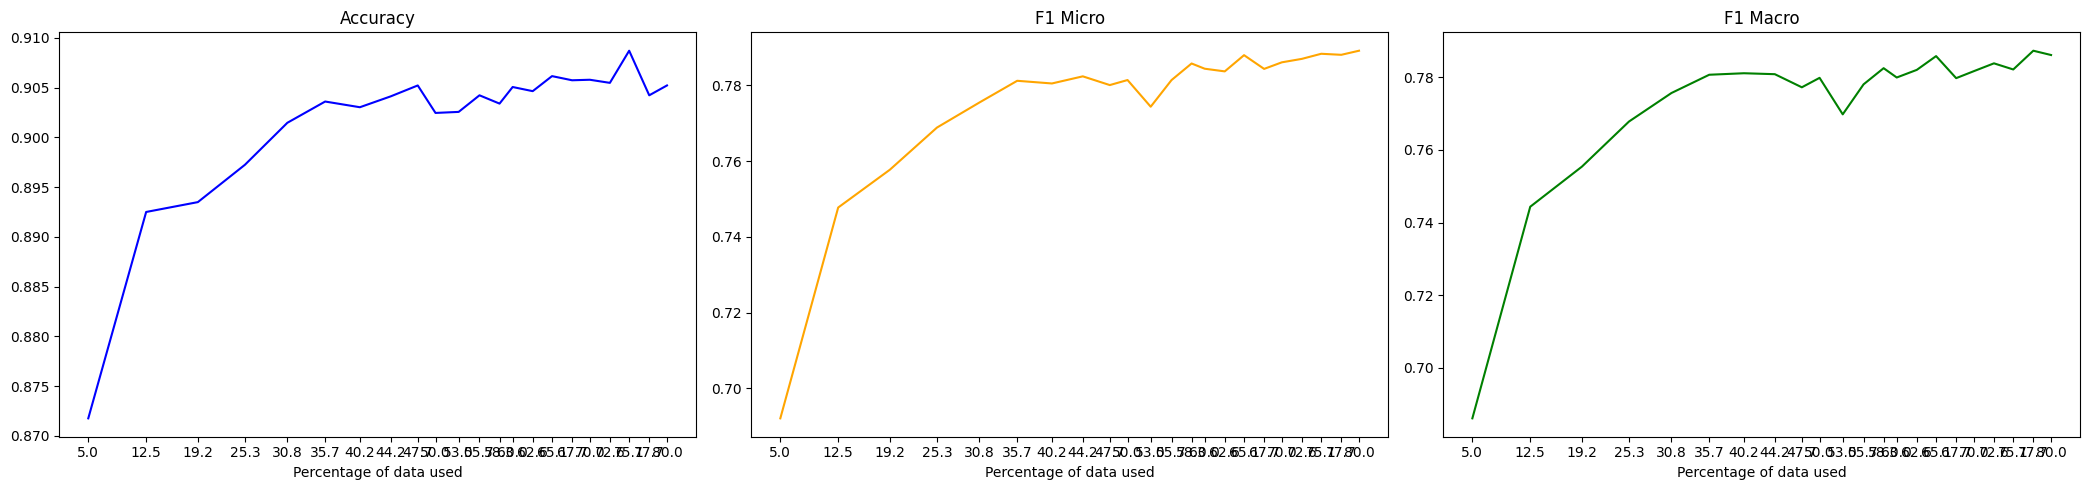

In [ ]:
active_learning(seeds[4], 4)